In [1]:
import pandas as pd

# Load the uploaded Excel file to check its structure
file_path = '../dataset/rab107row.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows to understand the structure
data.head()

namaproyek           rab  waktu     provinsi  tahun       luas  \
0  Gedung Apartemen  2.641914e+10    196   Jawa Barat   2019   17401.00   
1  Gedung Apartemen  8.821079e+10    273  DKI Jakarta   2022   16320.59   
2  Gedung Apartemen  8.171200e+10    348  DKI Jakarta   2023   23688.00   
3  Gedung Apartemen  3.690000e+11    830       Banten   2021   55000.00   
4  Gedung Apartemen  5.400316e+11    700  DKI Jakarta   2023  150000.00   

   subitem  tinggi  lantai     ikk    ihbp  inflasi  
0        4    21.8       6  103.03  143.72     3.21  
1        6    47.6      14  121.48  107.66     4.21  
2        5    34.0      10  116.73  113.88     2.28  
3        6    49.8      16   97.64  109.64     1.91  
4        6   105.0      30  116.73  113.88     2.28

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [3]:
import numpy as np

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Retry applying log transformation with numpy properly imported
transformed_data = data.copy()
for col in numerical_columns:
    transformed_data[col] = data[col].apply(lambda x: np.log1p(x) if x > 0 else x)

In [4]:
transformed_data.head()

namaproyek        rab     waktu     provinsi     tahun       luas  \
0  Gedung Apartemen  23.997354  5.283204   Jawa Barat  7.610853   9.764340   
1  Gedung Apartemen  25.202995  5.613128  DKI Jakarta  7.612337   9.700244   
2  Gedung Apartemen  25.126467  5.855072  DKI Jakarta  7.612831  10.072766   
3  Gedung Apartemen  26.634062  6.722630       Banten  7.611842  10.915107   
4  Gedung Apartemen  27.014893  6.552508  DKI Jakarta  7.612831  11.918397   

    subitem    tinggi    lantai       ikk      ihbp   inflasi  
0  1.609438  3.126761  1.945910  4.644679  4.974801  1.437463  
1  1.945910  3.883624  2.708050  4.807948  4.688224  1.650580  
2  1.791759  3.555348  2.397895  4.768394  4.743888  1.187843  
3  1.945910  3.927896  2.833213  4.591477  4.706282  1.068153  
4  1.945910  4.663439  3.433987  4.768394  4.743888  1.187843

In [5]:
cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat

namaproyek        rab     waktu provinsi     tahun       luas  \
22  Gedung Apartemen  26.146404  6.594413   Banten  7.611348  10.465096   

     subitem    tinggi    lantai       ikk      ihbp   inflasi  
22  1.791759  4.697293  3.465736  4.585478  4.650908  0.896088

In [6]:
transformed_data = transformed_data.drop_duplicates()

cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat, transformed_data.shape

(Empty DataFrame
 Columns: [namaproyek, rab, waktu, provinsi, tahun, luas, subitem, tinggi, lantai, ikk, ihbp, inflasi]
 Index: [],
 (106, 12))

In [7]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analisis outlier untuk setiap kolom numerik
outlier_results = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(transformed_data, col)
    outlier_results[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Menampilkan hasil analisis outlier
outlier_results

{'rab': {'outliers_count': 0,
  'lower_bound': 19.942509309324343,
  'upper_bound': 29.878975866310945},
 'waktu': {'outliers_count': 0,
  'lower_bound': 4.115594293821956,
  'upper_bound': 7.292699322311036},
 'tahun': {'outliers_count': 0,
  'lower_bound': 7.60788543037709,
  'upper_bound': 7.615798390425516},
 'luas': {'outliers_count': 0,
  'lower_bound': 4.626135712885208,
  'upper_bound': 13.50521030326389},
 'subitem': {'outliers_count': 24,
  'lower_bound': 1.5605334494871674,
  'upper_bound': 2.1771361687962005},
 'tinggi': {'outliers_count': 0,
  'lower_bound': 0.5451998640506068,
  'upper_bound': 6.24499765950352},
 'lantai': {'outliers_count': 0,
  'lower_bound': -0.6446193937132167,
  'upper_bound': 4.9199129867178755},
 'ikk': {'outliers_count': 1,
  'lower_bound': 4.459107497071852,
  'upper_bound': 4.953965689101057},
 'ihbp': {'outliers_count': 0,
  'lower_bound': 4.2583580911778816,
  'upper_bound': 5.404666491032535},
 'inflasi': {'outliers_count': 2,
  'lower_bound'

In [8]:
# Fungsi untuk mendeteksi dan menghapus baris yang mengandung outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Hapus baris yang memiliki nilai outlier
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Hapus outlier untuk setiap kolom numerik
data_cleaned = transformed_data.copy()
for col in numerical_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

In [9]:
data_cleaned.shape

(80, 12)

In [10]:
# Label encoding kolom 'Provinsi' dan nama proyek karena nilainya kategorikal
label_encoder = LabelEncoder()
data_cleaned['label_provinsi'] = label_encoder.fit_transform(data_cleaned['provinsi'])
data_cleaned['label_namaproyek'] = label_encoder.fit_transform(data_cleaned['namaproyek'])

# Melihat nilai unik dari hasil encoding kolom 'provinsi_encoded'
provinsi_unik = data_cleaned[['provinsi', 'label_provinsi']].drop_duplicates().sort_values(
    by='label_provinsi')

# Melihat nilai unik dari hasil encoding kolom 'namaproyek_encoded'
namaproyek_unik = data_cleaned[['namaproyek', 'label_namaproyek']].drop_duplicates().sort_values(
    by='label_namaproyek')

In [11]:
provinsi_unik

provinsi  label_provinsi
95                 Bali               0
3                Banten               1
1           DKI Jakarta               2
0            Jawa Barat               3
23          Jawa Tengah               4
59           Jawa Timur               5
66     Kalimantan Timur               6
55       Kepulauan Riau               7
25  Nusa Tenggara Barat               8
41                Papua               9
70     Sulawesi Selatan              10

In [12]:
namaproyek_unik

namaproyek  label_namaproyek
0       Gedung Apartemen                 0
35         Gedung Asrama                 1
43         Gedung Gudang                 2
45          Gedung Hotel                 3
49         Gedung Kampus                 4
55         Gedung Kantor                 5
76   Gedung Laboratorium                 6
81       Gedung Olahraga                 7
83         Gedung Pabrik                 8
84         Gedung Parkir                 9
88    Gedung Rumah Sakit                10
96    Gedung Rumah Susun                11
102       Gedung Sekolah                12
105        Gedung Wisata                13

In [11]:
# 4. Normalisasi Kolom Numerik
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

numerical_columns = ['waktu', 'tahun', 'luas', 'subitem', 
                     'tinggi', 'lantai', 'ikk', 'ihbp', 'inflasi']
# 4. Normalisasi Kolom Numerik
scalerMinMax = MinMaxScaler()
data_cleaned[numerical_columns] = scalerMinMax.fit_transform(data_cleaned[numerical_columns])

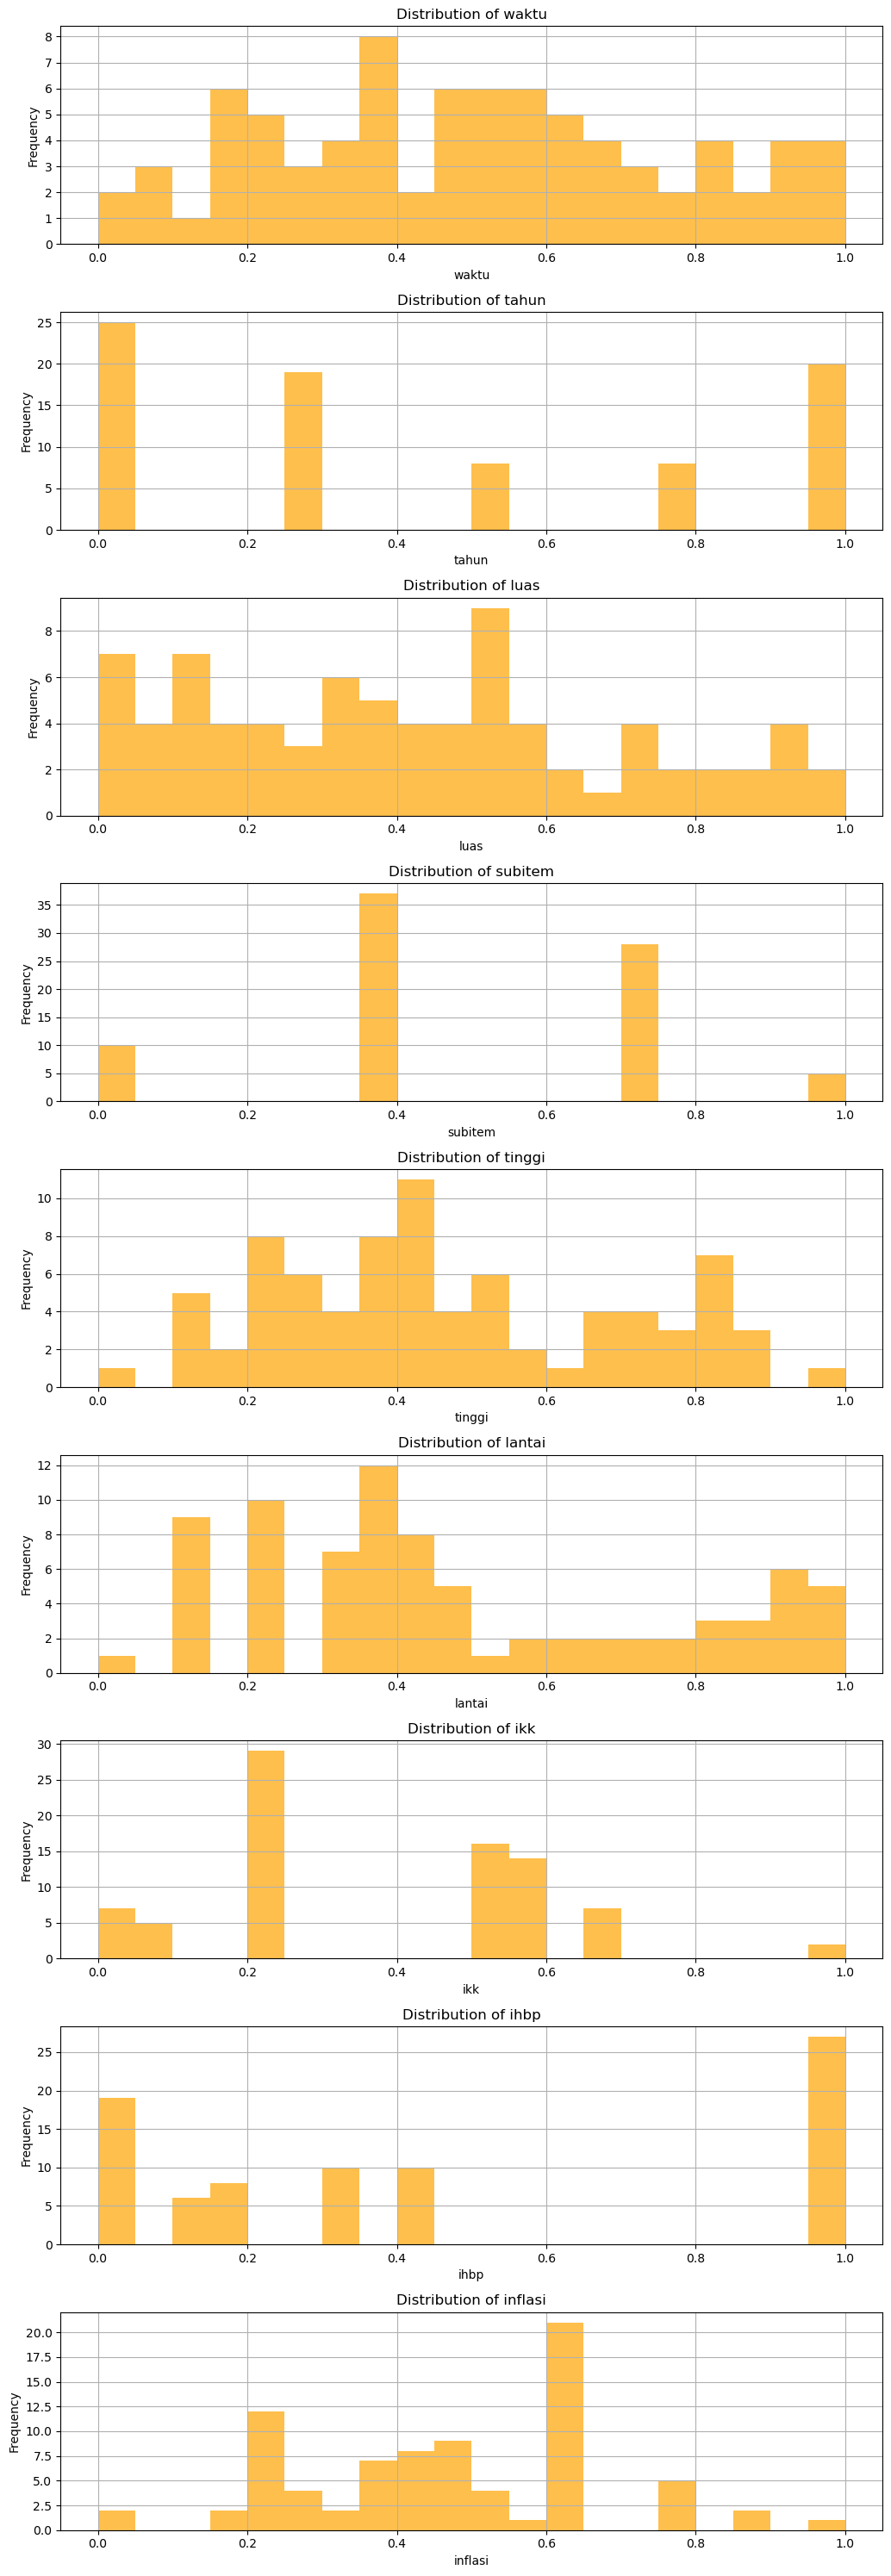

In [12]:
# Compare distributions before and after transformation using histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data_cleaned[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

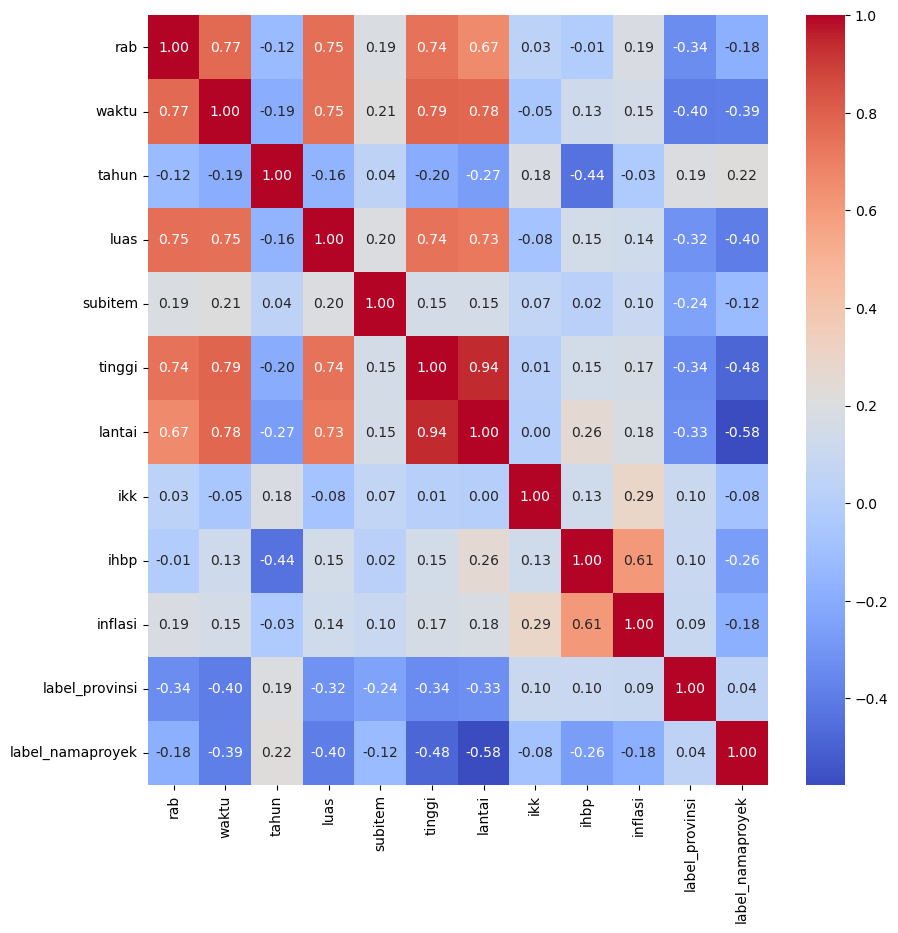

In [13]:
# Digunakan untuk membuat visualisasi dalam bentuk grafik atau plot
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi korelasi antar fitur atau kolom apakah saling berpengaruh atau tidak
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data_cleaned.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [14]:
# Split data into features and target
X1 = data_cleaned.drop(columns=[
    'rab', 'namaproyek', 'provinsi', 'lantai'])
y1 = data_cleaned['rab']

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, 
    test_size=0.3, 
    random_state=42)

# Split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X1, y1, 
    test_size=0.2, 
    random_state=42)

Stacking Regressor 70:30

Stacking 1

In [15]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        ('br', br),
        ('xgboost', xgboost),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.581
Root Mean Squared Error (MSE):  0.727
R² Score:  0.799
Testing
Mean Absolute Error (MAE):  0.453
Root Mean Squared Error (MSE):  0.651
R² Score:  0.802


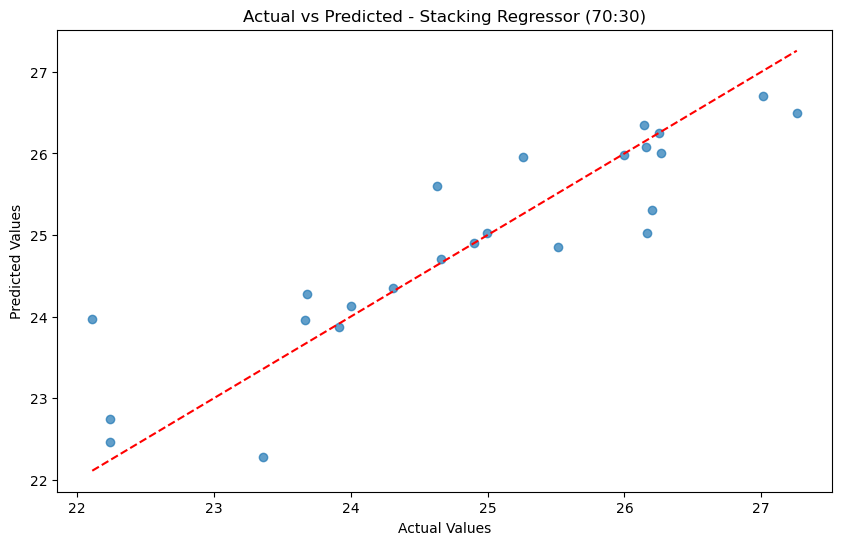

In [16]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = stacking_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (70:30)")
plt.show()

In [17]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.279140
0   23.997354  24.128014
27  26.199729  25.306853
39  22.237415  22.461243
21  26.146404  26.348871


In [18]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.739.228.458
0    Rp 26.419.136.187   Rp 30.106.708.077
27  Rp 239.000.000.001   Rp 97.864.864.305
39    Rp 4.545.551.009    Rp 5.685.832.485
21  Rp 226.589.000.001  Rp 277.440.063.997
35    Rp 4.545.551.009    Rp 7.512.369.960
10  Rp 120.781.089.488   Rp 61.983.848.191
92  Rp 228.530.000.001  Rp 211.101.362.931
4   Rp 540.031.588.145  Rp 393.743.226.816
13  Rp 195.596.000.001  Rp 190.999.626.265
64   Rp 65.000.000.001   Rp 65.461.759.402
41   Rp 24.322.000.001   Rp 23.294.109.368
88   Rp 35.905.245.001   Rp 37.710.246.070
43   Rp 18.970.782.261   Rp 25.406.575.492
89   Rp 93.541.144.803  Rp 187.034.240.902
59    Rp 3.997.225.850   Rp 25.831.786.838
95  Rp 690.000.000.001  Rp 321.719.968.224
78   Rp 49.559.404.693  Rp 131.031.637.086
72  Rp 230.570.298.290   Rp 73.604.569.370
52  Rp 254.967.000.193  Rp 196.778.592.174
9   Rp 251.146.002.001  Rp 252.638.581.109
83   Rp 71.420.000.001   Rp 74.045.054.958
5    Rp 51.

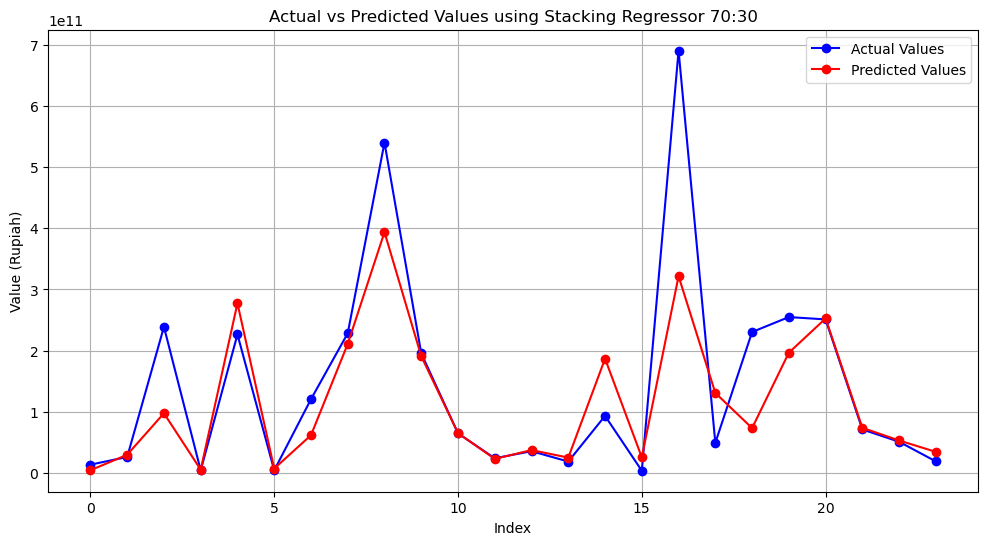

In [19]:
# Predict on the test data
y_pred_log1 = stacking_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

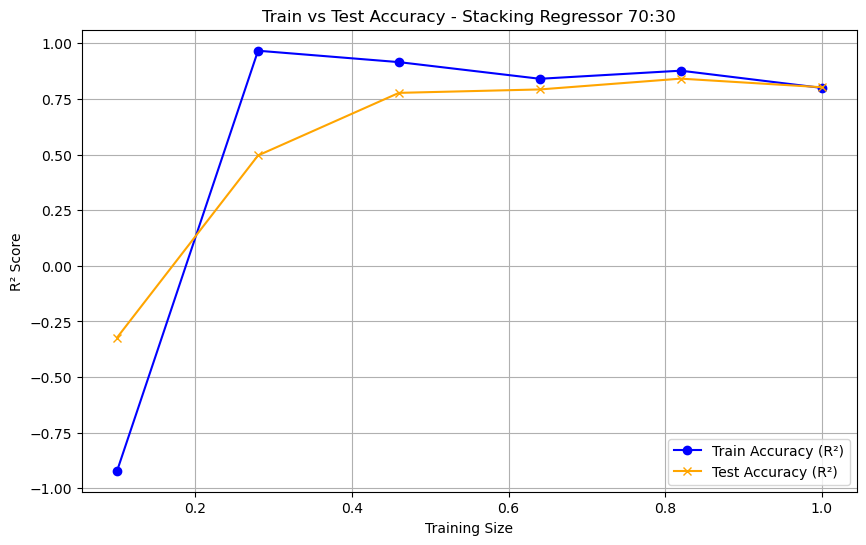

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    stacking_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = stacking_regressor.predict(X_train_subset)
    y_test_pred = stacking_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Stacking 2

In [21]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        ('br', br),
        # ('xgboost', xgboost),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.555
Root Mean Squared Error (MSE):  0.698
R² Score:  0.815
Testing
Mean Absolute Error (MAE):  0.457
Root Mean Squared Error (MSE):  0.652
R² Score:  0.802


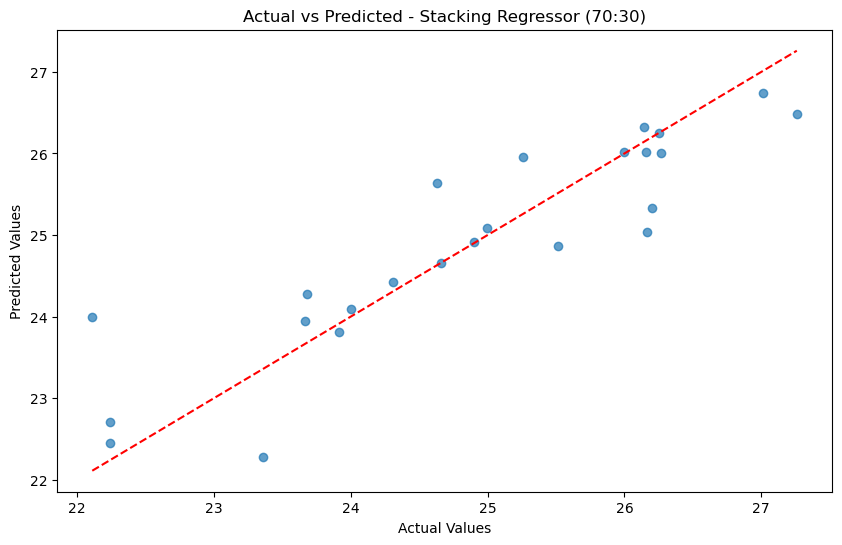

In [22]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = stacking_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (70:30)")
plt.show()

In [23]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.277505
0   23.997354  24.086623
27  26.199729  25.326484
39  22.237415  22.453356
21  26.146404  26.322418


In [24]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.731.486.802
0    Rp 26.419.136.187   Rp 28.885.997.810
27  Rp 239.000.000.001   Rp 99.805.011.506
39    Rp 4.545.551.009    Rp 5.641.165.152
21  Rp 226.589.000.001  Rp 270.197.302.246
35    Rp 4.545.551.009    Rp 7.268.189.723
10  Rp 120.781.089.488   Rp 62.767.777.570
92  Rp 228.530.000.001  Rp 199.029.538.941
4   Rp 540.031.588.145  Rp 411.544.608.891
13  Rp 195.596.000.001  Rp 198.917.347.001
64   Rp 65.000.000.001   Rp 66.228.827.875
41   Rp 24.322.000.001   Rp 21.821.940.951
88   Rp 35.905.245.001   Rp 40.456.747.061
43   Rp 18.970.782.261   Rp 24.977.159.171
89   Rp 93.541.144.803  Rp 186.567.267.339
59    Rp 3.997.225.850   Rp 26.266.357.408
95  Rp 690.000.000.001  Rp 318.982.694.641
78   Rp 49.559.404.693  Rp 136.281.538.035
72  Rp 230.570.298.290   Rp 74.505.597.850
52  Rp 254.967.000.193  Rp 195.946.199.193
9   Rp 251.146.002.001  Rp 250.427.664.184
83   Rp 71.420.000.001   Rp 78.616.240.401
5    Rp 51.

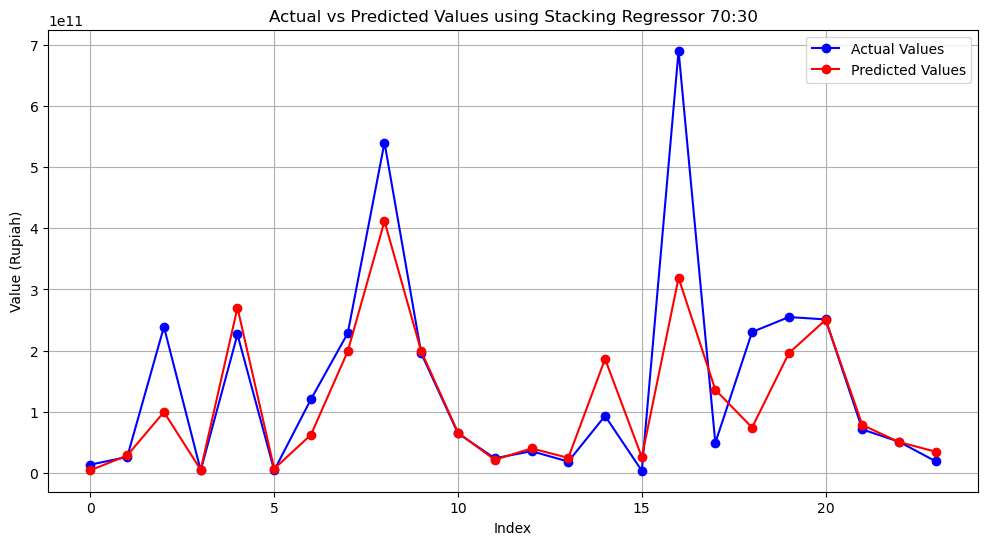

In [25]:
# Predict on the test data
y_pred_log1 = stacking_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

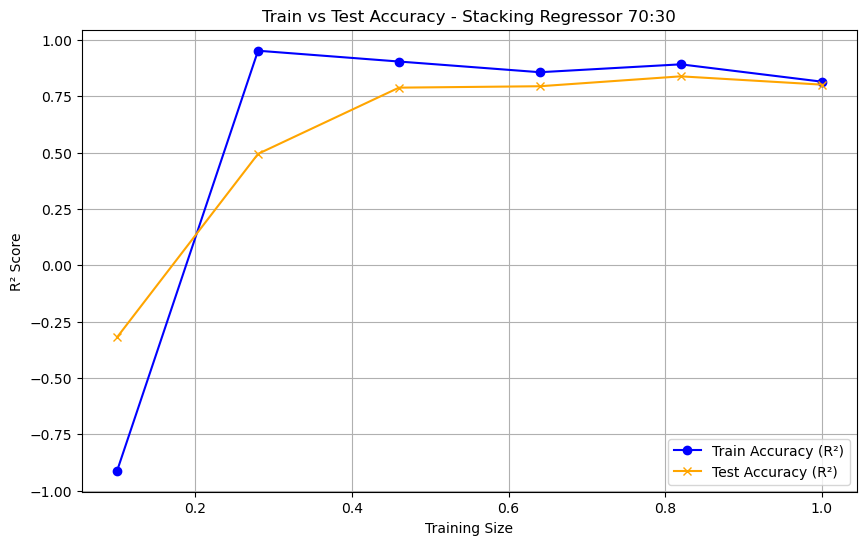

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    stacking_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = stacking_regressor.predict(X_train_subset)
    y_test_pred = stacking_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Stacking 3

In [27]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.527
Root Mean Squared Error (MSE):  0.654
R² Score:  0.837
Testing
Mean Absolute Error (MAE):  0.470
Root Mean Squared Error (MSE):  0.642
R² Score:  0.808


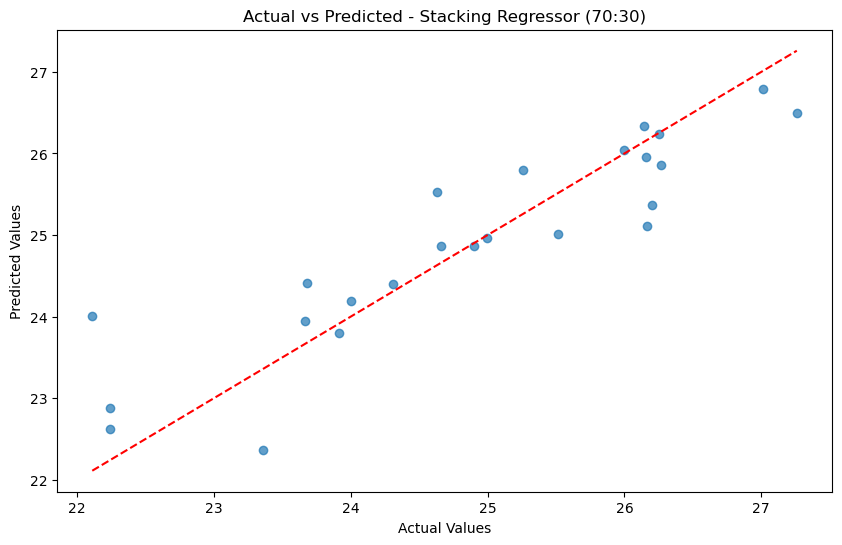

In [29]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = stacking_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (70:30)")
plt.show()

In [30]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.366196
0   23.997354  24.187826
27  26.199729  25.365474
39  22.237415  22.625328
21  26.146404  26.335170


In [31]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.170.298.105
0    Rp 26.419.136.187   Rp 31.962.383.155
27  Rp 239.000.000.001  Rp 103.773.259.950
39    Rp 4.545.551.009    Rp 6.699.694.217
21  Rp 226.589.000.001  Rp 273.664.903.643
35    Rp 4.545.551.009    Rp 8.588.652.378
10  Rp 120.781.089.488   Rp 72.452.893.886
92  Rp 228.530.000.001  Rp 186.433.051.947
4   Rp 540.031.588.145  Rp 430.130.100.120
13  Rp 195.596.000.001  Rp 204.477.872.769
64   Rp 65.000.000.001   Rp 63.250.257.737
41   Rp 24.322.000.001   Rp 21.523.436.432
88   Rp 35.905.245.001   Rp 39.294.641.164
43   Rp 18.970.782.261   Rp 25.166.937.240
89   Rp 93.541.144.803  Rp 159.433.002.711
59    Rp 3.997.225.850   Rp 26.675.568.920
95  Rp 690.000.000.001  Rp 321.777.843.682
78   Rp 49.559.404.693  Rp 121.868.824.198
72  Rp 230.570.298.290   Rp 80.773.524.113
52  Rp 254.967.000.193  Rp 169.301.858.250
9   Rp 251.146.002.001  Rp 247.057.028.887
83   Rp 71.420.000.001   Rp 69.384.116.980
5    Rp 51.

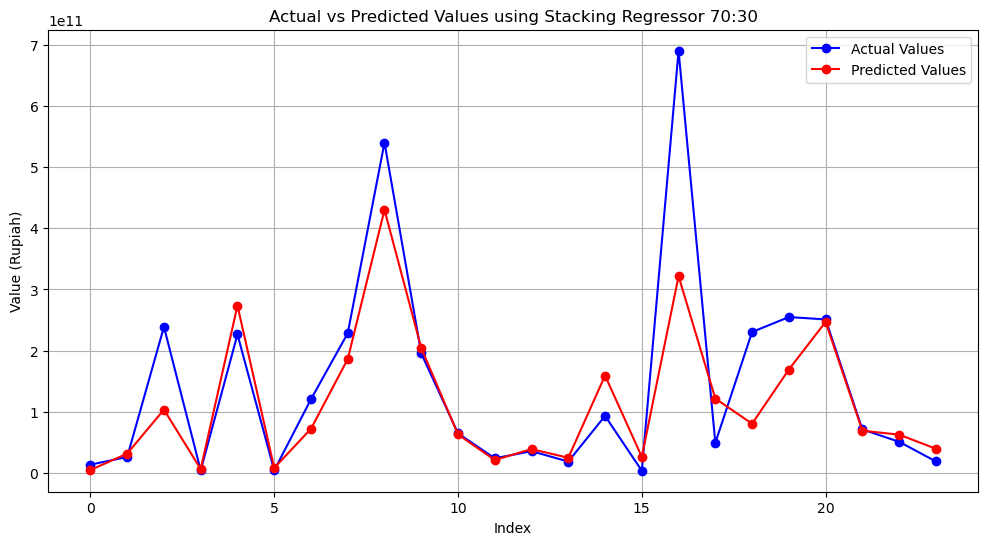

In [32]:
# Predict on the test data
y_pred_log1 = stacking_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

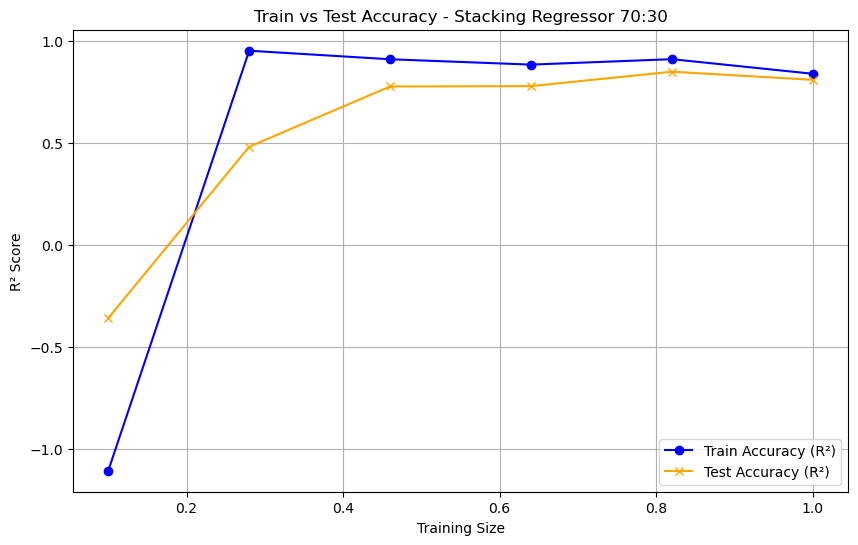

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    stacking_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = stacking_regressor.predict(X_train_subset)
    y_test_pred = stacking_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Stacking 4

In [34]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        # ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.515
Root Mean Squared Error (MSE):  0.672
R² Score:  0.828
Testing
Mean Absolute Error (MAE):  0.455
Root Mean Squared Error (MSE):  0.628
R² Score:  0.816


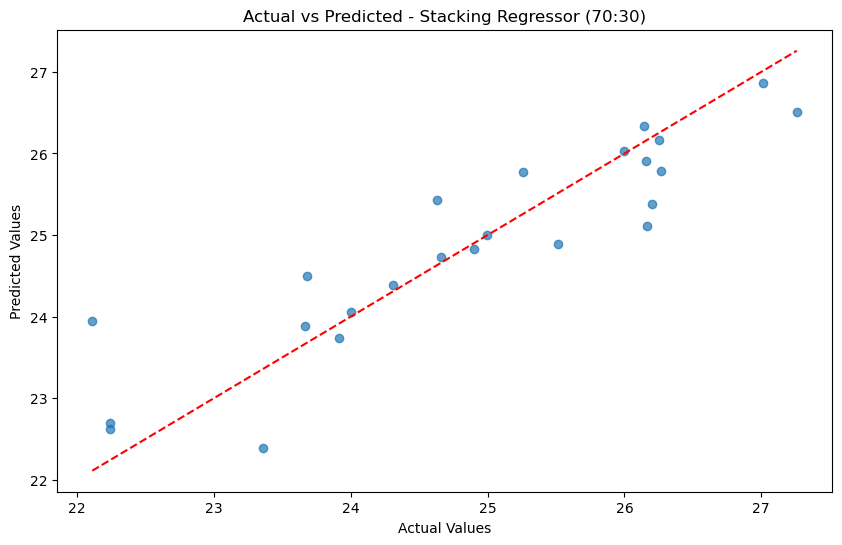

In [35]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = stacking_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (70:30)")
plt.show()

In [36]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.388954
0   23.997354  24.051726
27  26.199729  25.385847
39  22.237415  22.624513
21  26.146404  26.332544


In [37]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.289.310.275
0    Rp 26.419.136.187   Rp 27.895.359.879
27  Rp 239.000.000.001  Rp 105.909.048.689
39    Rp 4.545.551.009    Rp 6.694.239.987
21  Rp 226.589.000.001  Rp 272.947.238.813
35    Rp 4.545.551.009    Rp 7.176.360.862
10  Rp 120.781.089.488   Rp 64.308.841.142
92  Rp 228.530.000.001  Rp 178.675.542.169
4   Rp 540.031.588.145  Rp 466.517.651.231
13  Rp 195.596.000.001  Rp 202.550.636.564
64   Rp 65.000.000.001   Rp 60.849.853.333
41   Rp 24.322.000.001   Rp 20.240.057.522
88   Rp 35.905.245.001   Rp 39.113.595.291
43   Rp 18.970.782.261   Rp 23.606.443.990
89   Rp 93.541.144.803  Rp 155.873.274.283
59    Rp 3.997.225.850   Rp 25.151.372.153
95  Rp 690.000.000.001  Rp 325.747.960.824
78   Rp 49.559.404.693  Rp 110.536.740.597
72  Rp 230.570.298.290   Rp 80.081.853.081
52  Rp 254.967.000.193  Rp 158.648.281.267
9   Rp 251.146.002.001  Rp 230.584.546.967
83   Rp 71.420.000.001   Rp 72.384.998.951
5    Rp 51.

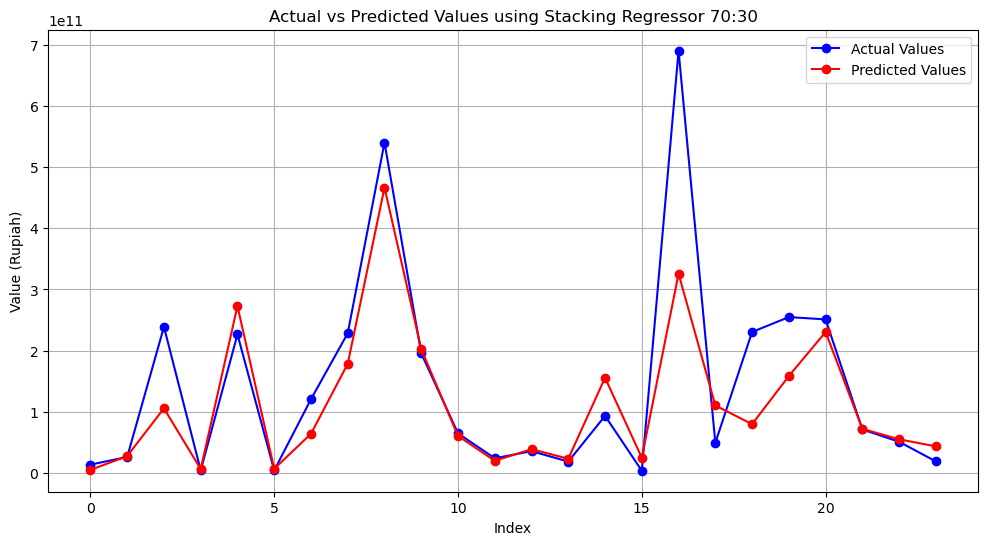

In [38]:
# Predict on the test data
y_pred_log1 = stacking_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

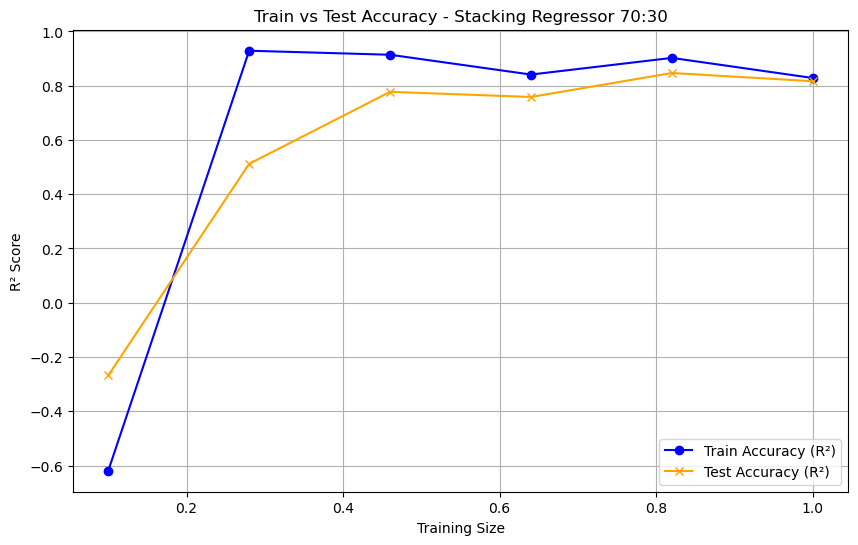

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    stacking_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = stacking_regressor.predict(X_train_subset)
    y_test_pred = stacking_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Stacking 5

In [41]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)
xgboost = xgb.XGBRegressor()
br = BayesianRidge()
gb = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()
adb = AdaBoostRegressor(random_state=42)


meta_model = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor = StackingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        # ('gb', gb),
        # ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
    ],
    final_estimator=meta_model)

# 4. Melatih Stacking Regressor
stacking_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_stacking = stacking_regressor.predict(X_train1)
mae_train_stacking = mean_absolute_error(y_train1, y_train_pred_stacking)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train1, y_train_pred_stacking))
r2_train_stacking = r2_score(y_train1, y_train_pred_stacking)

# Testing
y_test_pred_stacking = stacking_regressor.predict(X_test1)
mae_test_stacking = mean_absolute_error(y_test1, y_test_pred_stacking)
rmse_test_stacking = np.sqrt(mean_squared_error(y_test1, y_test_pred_stacking))
r2_test_stacking = r2_score(y_test1, y_test_pred_stacking)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking))

Training
Mean Absolute Error (MAE):  0.532
Root Mean Squared Error (MSE):  0.695
R² Score:  0.817
Testing
Mean Absolute Error (MAE):  0.457
Root Mean Squared Error (MSE):  0.629
R² Score:  0.815


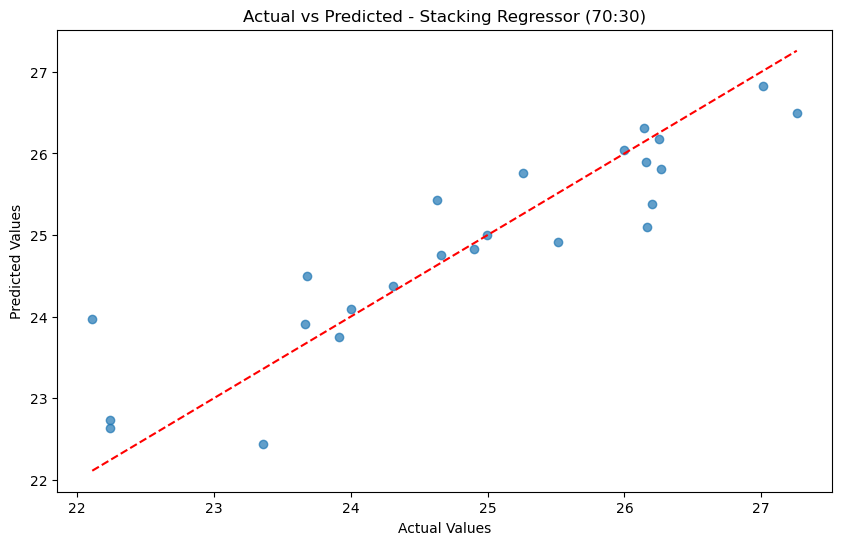

In [42]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = stacking_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (70:30)")
plt.show()

In [43]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.432267
0   23.997354  24.086978
27  26.199729  25.381627
39  22.237415  22.634928
21  26.146404  26.308651


In [44]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.523.441.288
0    Rp 26.419.136.187   Rp 28.896.256.161
27  Rp 239.000.000.001  Rp 105.463.096.020
39    Rp 4.545.551.009    Rp 6.764.323.492
21  Rp 226.589.000.001  Rp 266.502.883.370
35    Rp 4.545.551.009    Rp 7.478.016.126
10  Rp 120.781.089.488   Rp 66.054.742.666
92  Rp 228.530.000.001  Rp 176.769.313.363
4   Rp 540.031.588.145  Rp 449.879.917.844
13  Rp 195.596.000.001  Rp 203.924.170.889
64   Rp 65.000.000.001   Rp 60.560.921.499
41   Rp 24.322.000.001   Rp 20.654.411.832
88   Rp 35.905.245.001   Rp 38.514.395.109
43   Rp 18.970.782.261   Rp 24.187.099.602
89   Rp 93.541.144.803  Rp 153.316.715.909
59    Rp 3.997.225.850   Rp 25.761.848.039
95  Rp 690.000.000.001  Rp 321.542.530.554
78   Rp 49.559.404.693  Rp 111.124.990.233
72  Rp 230.570.298.290   Rp 79.492.940.020
52  Rp 254.967.000.193  Rp 162.201.856.640
9   Rp 251.146.002.001  Rp 233.480.298.429
83   Rp 71.420.000.001   Rp 72.229.611.044
5    Rp 51.

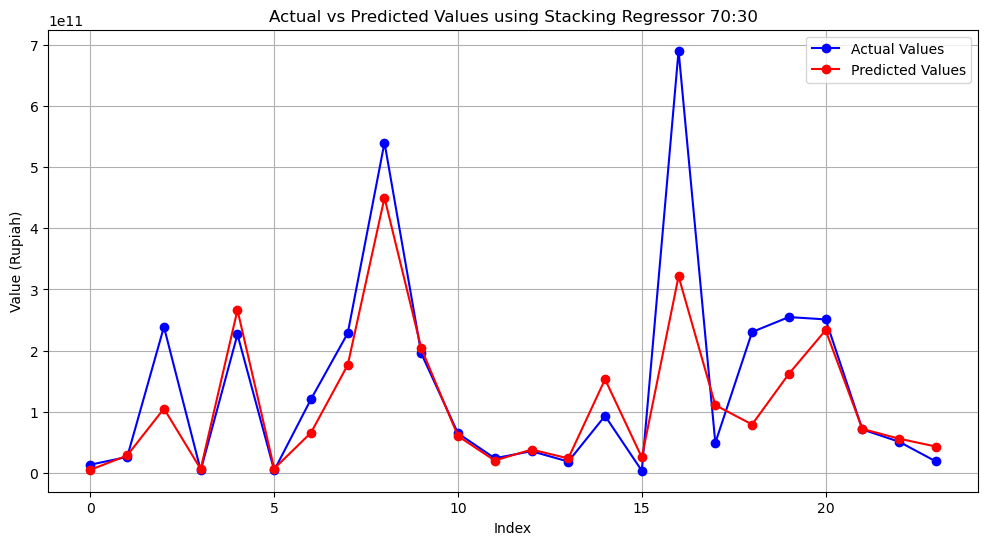

In [45]:
# Predict on the test data
y_pred_log1 = stacking_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

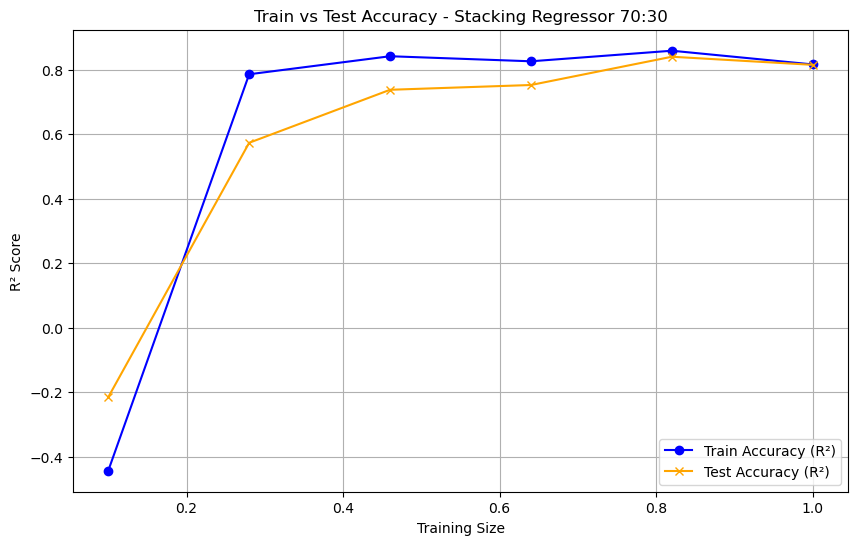

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    stacking_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = stacking_regressor.predict(X_train_subset)
    y_test_pred = stacking_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting Regressor 70:30

Voting 1

In [47]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        ('br', br),
        ('xgboost', xgboost),
        ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.341
Root Mean Squared Error (MSE):  0.424
R² Score:  0.932
Testing
Mean Absolute Error (MAE):  0.451
Root Mean Squared Error (MSE):  0.630
R² Score:  0.815


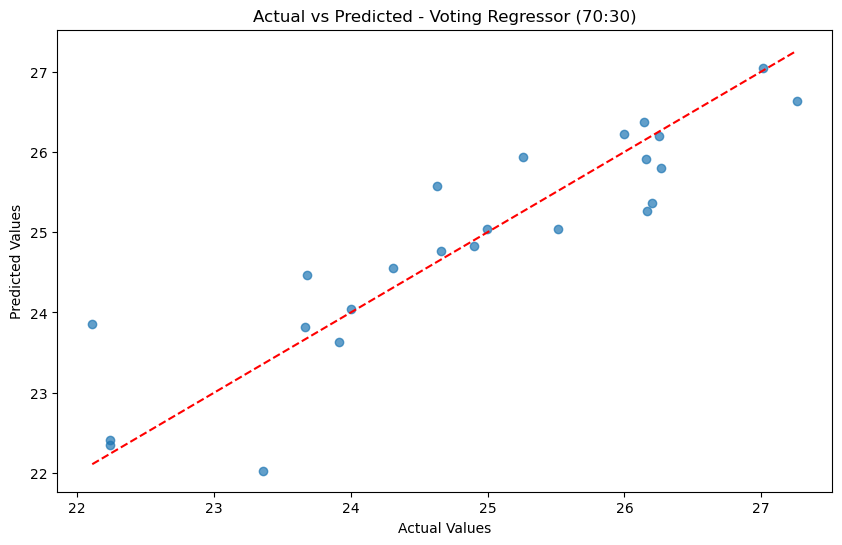

In [49]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [50]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.027691
0   23.997354  24.047622
27  26.199729  25.368275
39  22.237415  22.348085
21  26.146404  26.377474


In [51]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.685.568.178
0    Rp 26.419.136.187   Rp 27.781.113.257
27  Rp 239.000.000.001  Rp 104.064.347.937
39    Rp 4.545.551.009    Rp 5.077.501.434
21  Rp 226.589.000.001  Rp 285.490.232.304
35    Rp 4.545.551.009    Rp 5.429.968.933
10  Rp 120.781.089.488   Rp 74.562.862.357
92  Rp 228.530.000.001  Rp 178.894.286.214
4   Rp 540.031.588.145  Rp 559.845.447.908
13  Rp 195.596.000.001  Rp 243.375.956.528
64   Rp 65.000.000.001   Rp 60.816.285.335
41   Rp 24.322.000.001   Rp 18.267.014.632
88   Rp 35.905.245.001   Rp 45.974.197.782
43   Rp 18.970.782.261   Rp 22.024.398.156
89   Rp 93.541.144.803  Rp 184.045.567.821
59    Rp 3.997.225.850   Rp 22.830.439.227
95  Rp 690.000.000.001  Rp 368.858.261.338
78   Rp 49.559.404.693  Rp 127.444.609.665
72  Rp 230.570.298.290   Rp 93.628.979.828
52  Rp 254.967.000.193  Rp 159.220.788.434
9   Rp 251.146.002.001  Rp 239.649.563.923
83   Rp 71.420.000.001   Rp 75.053.357.641
5    Rp 51.

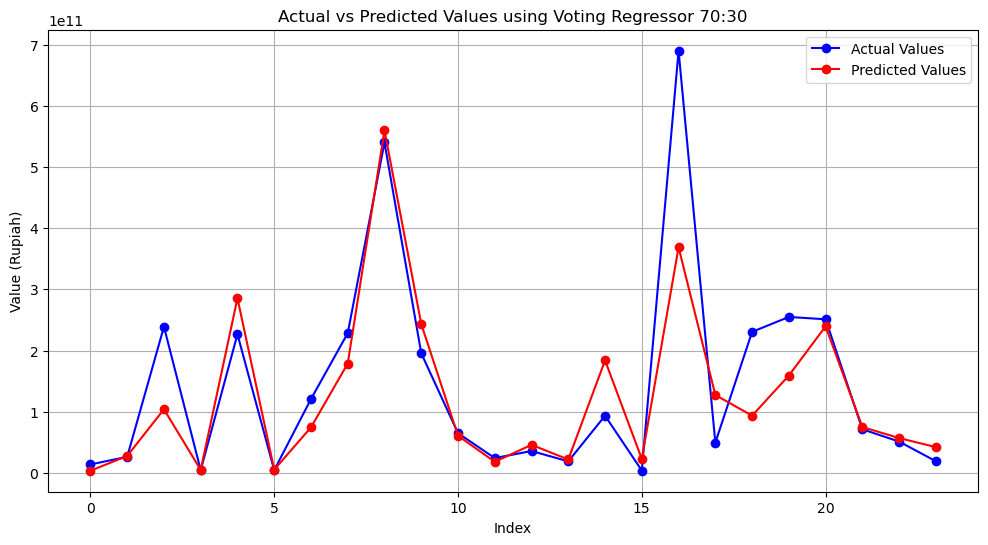

In [53]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

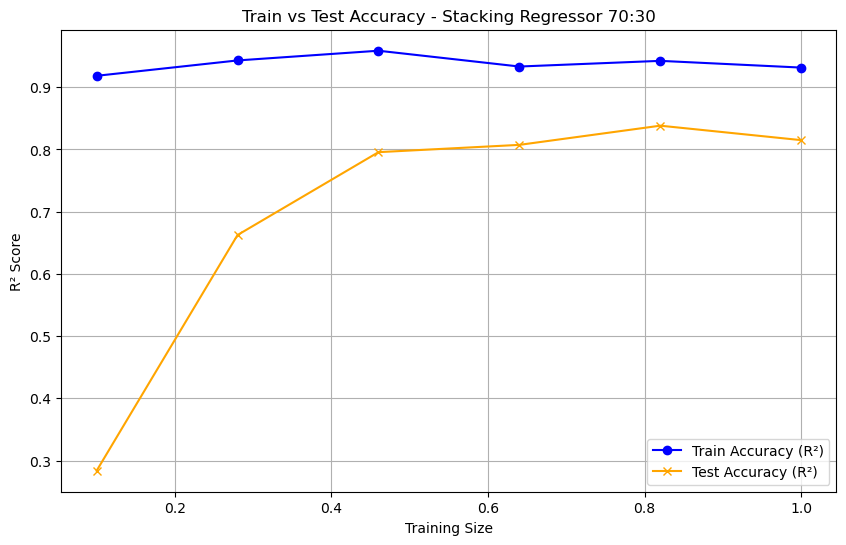

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting 2

In [55]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        ('br', br),
        ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.311
Root Mean Squared Error (MSE):  0.380
R² Score:  0.945
Testing
Mean Absolute Error (MAE):  0.466
Root Mean Squared Error (MSE):  0.627
R² Score:  0.817


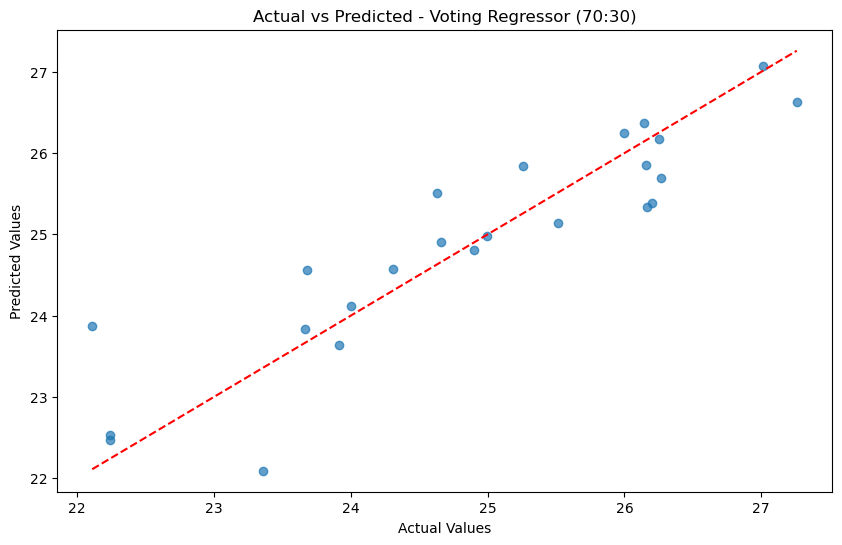

In [56]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [57]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.090133
0   23.997354  24.119138
27  26.199729  25.391010
39  22.237415  22.466750
21  26.146404  26.364810


In [58]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.923.039.712
0    Rp 26.419.136.187   Rp 29.840.655.083
27  Rp 239.000.000.001  Rp 106.457.275.659
39    Rp 4.545.551.009    Rp 5.717.226.534
21  Rp 226.589.000.001  Rp 281.897.782.435
35    Rp 4.545.551.009    Rp 6.066.321.333
10  Rp 120.781.089.488   Rp 83.008.696.180
92  Rp 228.530.000.001  Rp 168.932.560.650
4   Rp 540.031.588.145  Rp 570.389.100.266
13  Rp 195.596.000.001  Rp 249.211.303.140
64   Rp 65.000.000.001   Rp 59.600.293.577
41   Rp 24.322.000.001   Rp 18.347.914.178
88   Rp 35.905.245.001   Rp 46.862.254.936
43   Rp 18.970.782.261   Rp 22.397.317.952
89   Rp 93.541.144.803  Rp 167.753.264.911
59    Rp 3.997.225.850   Rp 23.292.029.470
95  Rp 690.000.000.001  Rp 366.444.072.246
78   Rp 49.559.404.693  Rp 120.316.276.818
72  Rp 230.570.298.290  Rp 100.303.961.837
52  Rp 254.967.000.193  Rp 143.850.179.245
9   Rp 251.146.002.001  Rp 233.794.132.848
83   Rp 71.420.000.001   Rp 70.349.693.628
5    Rp 51.

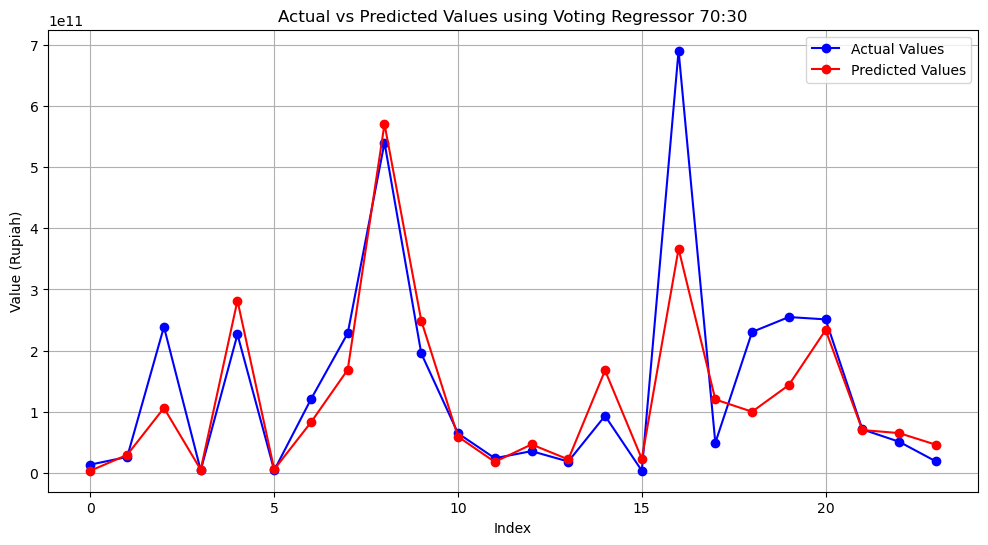

In [59]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

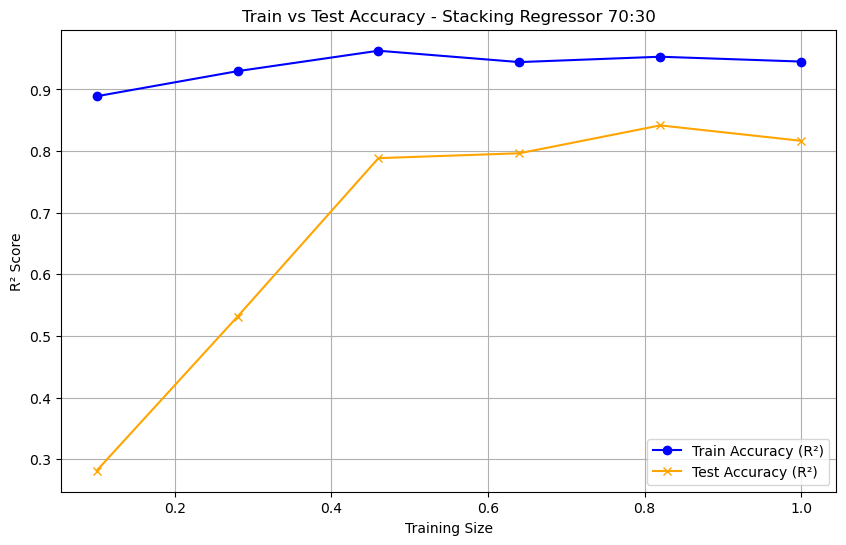

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting 3

In [61]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.373
Root Mean Squared Error (MSE):  0.456
R² Score:  0.921
Testing
Mean Absolute Error (MAE):  0.458
Root Mean Squared Error (MSE):  0.621
R² Score:  0.820


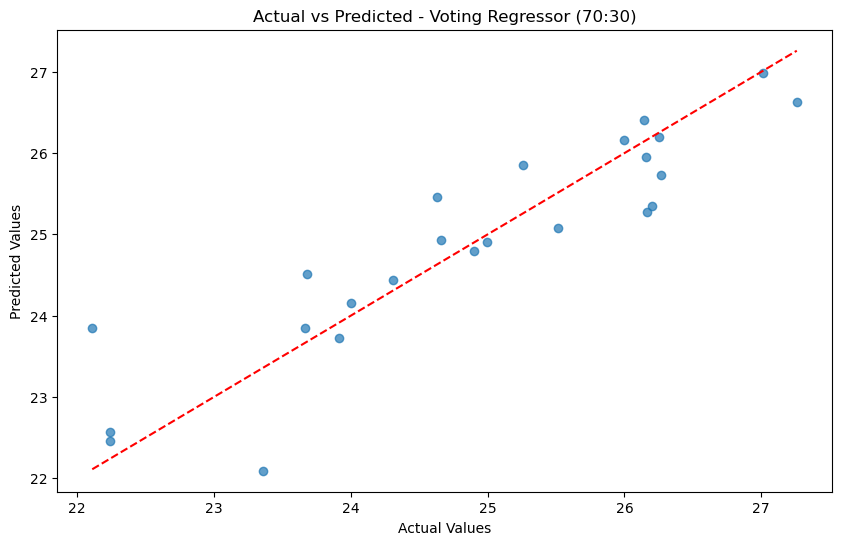

In [62]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [63]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.090811
0   23.997354  24.154135
27  26.199729  25.354297
39  22.237415  22.454495
21  26.146404  26.401900


In [64]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.925.703.607
0    Rp 26.419.136.187   Rp 30.903.487.957
27  Rp 239.000.000.001  Rp 102.619.844.484
39    Rp 4.545.551.009    Rp 5.647.591.626
21  Rp 226.589.000.001  Rp 292.549.521.073
35    Rp 4.545.551.009    Rp 6.298.324.692
10  Rp 120.781.089.488   Rp 77.948.333.635
92  Rp 228.530.000.001  Rp 186.875.041.718
4   Rp 540.031.588.145  Rp 522.395.835.213
13  Rp 195.596.000.001  Rp 229.389.925.281
64   Rp 65.000.000.001   Rp 58.791.639.967
41   Rp 24.322.000.001   Rp 20.143.746.988
88   Rp 35.905.245.001   Rp 41.214.808.677
43   Rp 18.970.782.261   Rp 22.824.713.422
89   Rp 93.541.144.803  Rp 169.907.140.962
59    Rp 3.997.225.850   Rp 22.686.269.547
95  Rp 690.000.000.001  Rp 367.151.681.922
78   Rp 49.559.404.693  Rp 114.440.309.983
72  Rp 230.570.298.290   Rp 94.694.220.117
52  Rp 254.967.000.193  Rp 149.334.922.075
9   Rp 251.146.002.001  Rp 238.473.575.943
83   Rp 71.420.000.001   Rp 65.139.724.621
5    Rp 51.

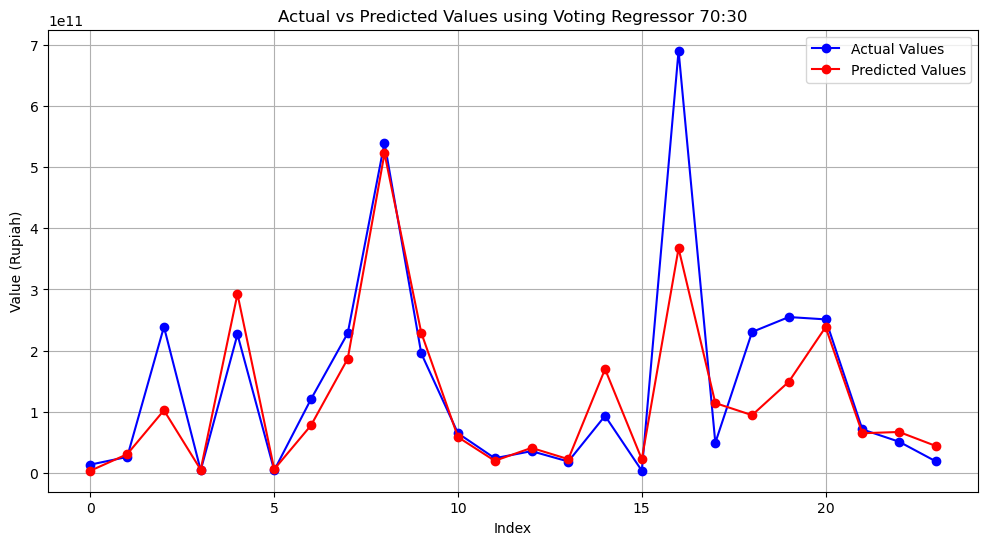

In [65]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

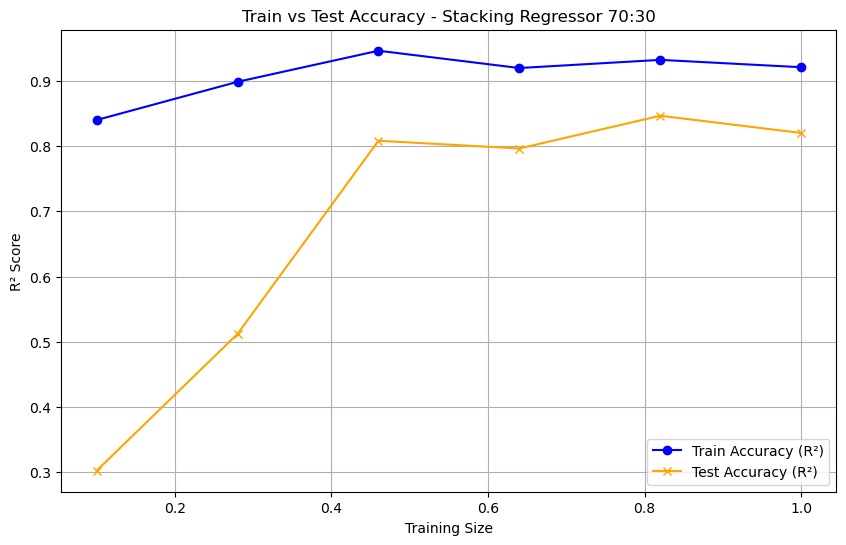

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting 4

In [67]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.333
Root Mean Squared Error (MSE):  0.395
R² Score:  0.941
Testing
Mean Absolute Error (MAE):  0.481
Root Mean Squared Error (MSE):  0.627
R² Score:  0.817


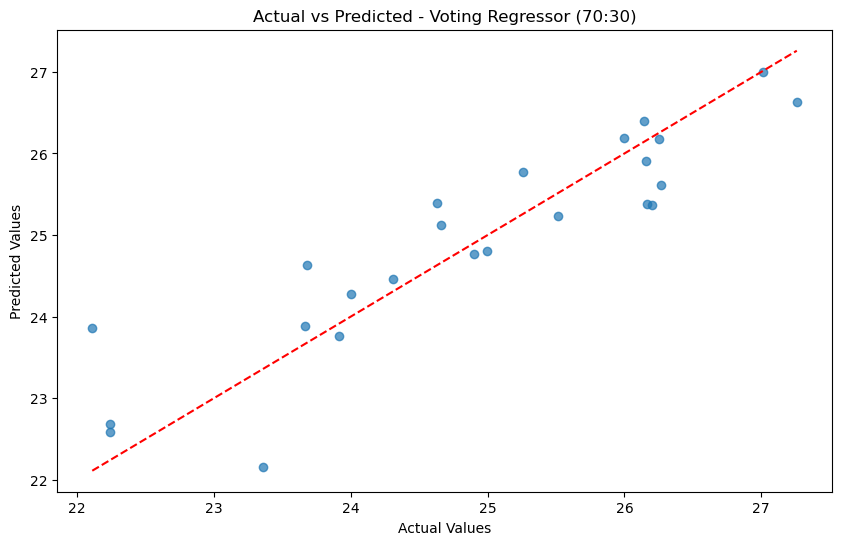

In [68]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [69]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.150138
0   23.997354  24.276796
27  26.199729  25.365366
39  22.237415  22.581047
21  26.146404  26.392752


In [70]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.165.649.938
0    Rp 26.419.136.187   Rp 34.936.436.068
27  Rp 239.000.000.001  Rp 103.762.074.003
39    Rp 4.545.551.009    Rp 6.409.498.912
21  Rp 226.589.000.001  Rp 289.885.551.301
35    Rp 4.545.551.009    Rp 7.131.816.179
10  Rp 120.781.089.488   Rp 90.565.860.788
92  Rp 228.530.000.001  Rp 177.824.091.477
4   Rp 540.031.588.145  Rp 528.903.443.260
13  Rp 195.596.000.001  Rp 237.491.708.612
64   Rp 65.000.000.001   Rp 57.068.793.871
41   Rp 24.322.000.001   Rp 20.873.423.847
88   Rp 35.905.245.001   Rp 42.039.441.044
43   Rp 18.970.782.261   Rp 23.651.402.464
89   Rp 93.541.144.803  Rp 155.978.062.478
59    Rp 3.997.225.850   Rp 23.079.834.003
95  Rp 690.000.000.001  Rp 368.791.117.714
78   Rp 49.559.404.693  Rp 107.076.238.402
72  Rp 230.570.298.290  Rp 104.728.139.235
52  Rp 254.967.000.193  Rp 132.860.928.289
9   Rp 251.146.002.001  Rp 232.430.891.436
83   Rp 71.420.000.001   Rp 59.396.939.293
5    Rp 51.

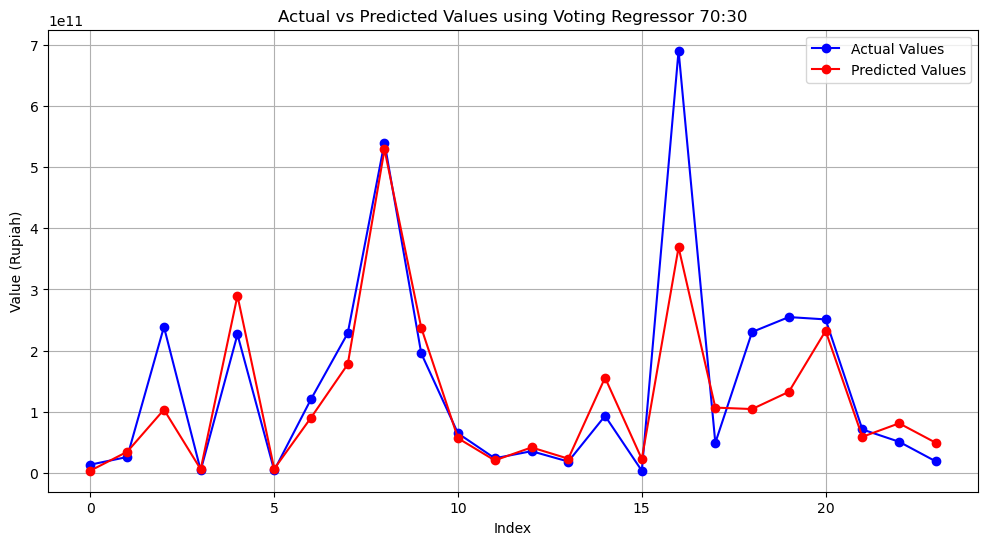

In [71]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

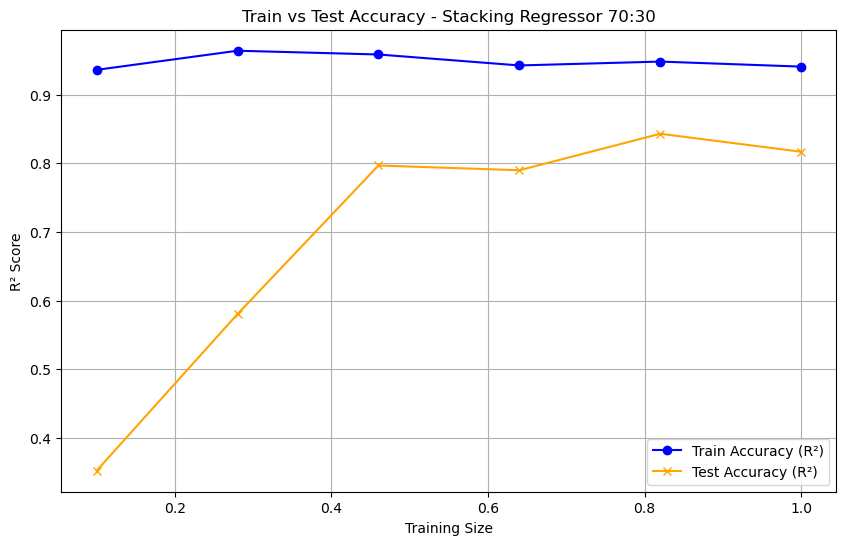

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting 5

In [73]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        ('gb', gb),
        # ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.316
Root Mean Squared Error (MSE):  0.405
R² Score:  0.938
Testing
Mean Absolute Error (MAE):  0.462
Root Mean Squared Error (MSE):  0.613
R² Score:  0.825


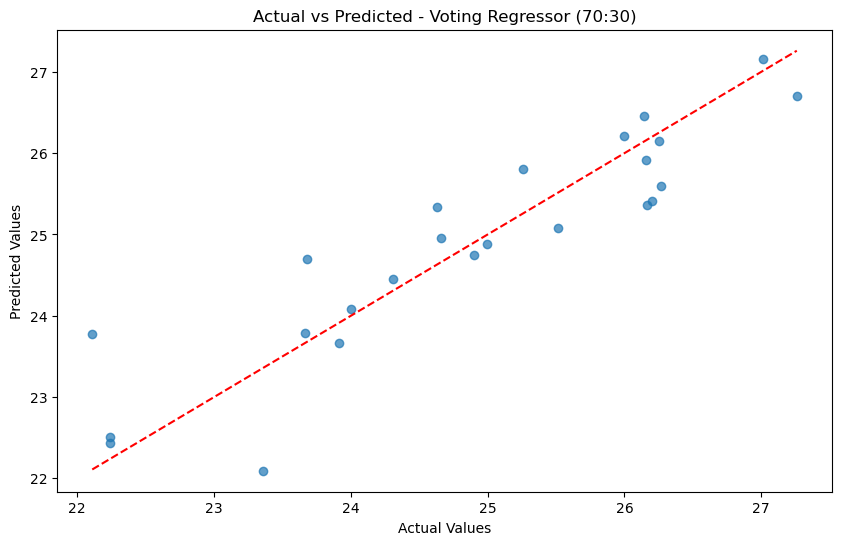

In [74]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [75]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.093489
0   23.997354  24.088658
27  26.199729  25.415541
39  22.237415  22.510928
21  26.146404  26.458134


In [76]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.936.230.503
0    Rp 26.419.136.187   Rp 28.944.837.461
27  Rp 239.000.000.001  Rp 109.101.092.726
39    Rp 4.545.551.009    Rp 5.975.466.807
21  Rp 226.589.000.001  Rp 309.472.066.267
35    Rp 4.545.551.009    Rp 5.535.744.429
10  Rp 120.781.089.488   Rp 77.841.760.821
92  Rp 228.530.000.001  Rp 180.210.257.663
4   Rp 540.031.588.145  Rp 621.111.741.012
13  Rp 195.596.000.001  Rp 242.139.702.308
64   Rp 65.000.000.001   Rp 56.081.038.924
41   Rp 24.322.000.001   Rp 18.860.124.983
88   Rp 35.905.245.001   Rp 41.648.512.685
43   Rp 18.970.782.261   Rp 21.444.915.608
89   Rp 93.541.144.803  Rp 160.698.314.181
59    Rp 3.997.225.850   Rp 21.271.632.586
95  Rp 690.000.000.001  Rp 396.082.160.077
78   Rp 49.559.404.693  Rp 100.812.204.795
72  Rp 230.570.298.290  Rp 103.247.382.507
52  Rp 254.967.000.193  Rp 131.085.827.968
9   Rp 251.146.002.001  Rp 228.315.021.514
83   Rp 71.420.000.001   Rp 63.995.492.820
5    Rp 51.

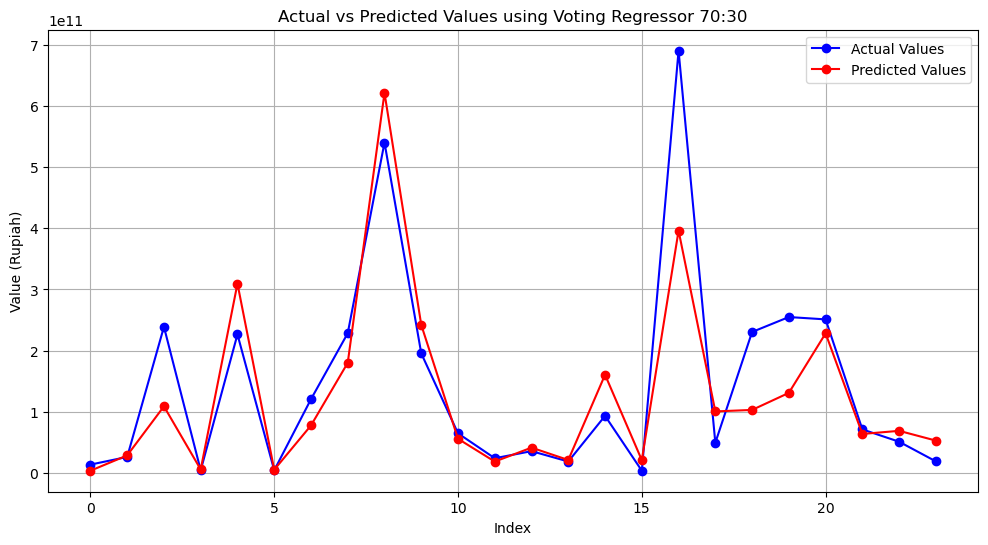

In [77]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

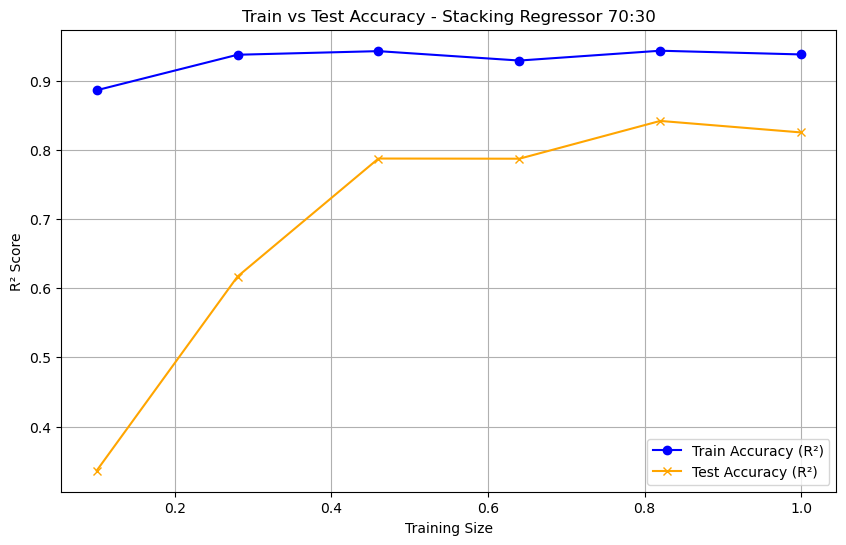

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Voting 6

In [79]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor = VotingRegressor(
   estimators=[
        ('ridge', ridge),
        ('rf', rf),
        # ('gb', gb),
        # ('adb', adb),
        # ('br', br),
        # ('xgboost', xgboost),
        # ('lr', lr),
    ])

# 4. Melatih Voting Regressor
voting_regressor.fit(X_train1, y_train1)

# Training
y_train_pred_voting = voting_regressor.predict(X_train1)
mae_train_voting = mean_absolute_error(y_train1, y_train_pred_voting)
rmse_train_voting = np.sqrt(mean_squared_error(y_train1, y_train_pred_voting))
r2_train_voting = r2_score(y_train1, y_train_pred_voting)

# Testing
y_test_pred_voting = voting_regressor.predict(X_test1)
mae_test_voting = mean_absolute_error(y_test1, y_test_pred_voting)
rmse_test_voting = np.sqrt(mean_squared_error(y_test1, y_test_pred_voting))
r2_test_voting = r2_score(y_test1, y_test_pred_voting)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting))

Training
Mean Absolute Error (MAE):  0.455
Root Mean Squared Error (MSE):  0.589
R² Score:  0.868
Testing
Mean Absolute Error (MAE):  0.464
Root Mean Squared Error (MSE):  0.616
R² Score:  0.823


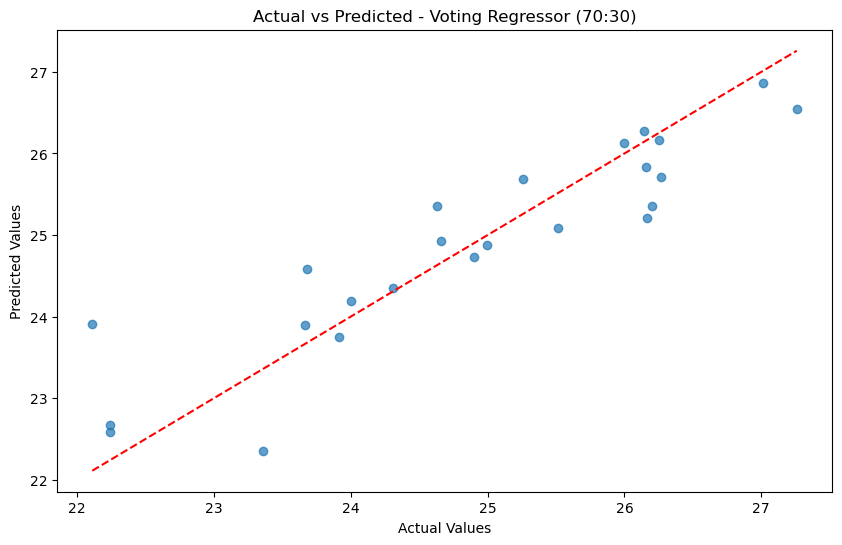

In [80]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()

In [81]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.356541
0   23.997354  24.189210
27  26.199729  25.352448
39  22.237415  22.582420
21  26.146404  26.276404


In [82]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.120.620.227
0    Rp 26.419.136.187   Rp 32.006.669.549
27  Rp 239.000.000.001  Rp 102.430.279.026
39    Rp 4.545.551.009    Rp 6.418.308.558
21  Rp 226.589.000.001  Rp 258.046.167.026
35    Rp 4.545.551.009    Rp 7.032.361.545
10  Rp 120.781.089.488   Rp 78.337.047.098
92  Rp 228.530.000.001  Rp 165.289.684.066
4   Rp 540.031.588.145  Rp 464.623.601.888
13  Rp 195.596.000.001  Rp 223.827.321.672
64   Rp 65.000.000.001   Rp 54.905.405.927
41   Rp 24.322.000.001   Rp 20.493.439.239
88   Rp 35.905.245.001   Rp 37.416.291.355
43   Rp 18.970.782.261   Rp 23.835.484.387
89   Rp 93.541.144.803  Rp 143.256.505.203
59    Rp 3.997.225.850   Rp 24.183.667.272
95  Rp 690.000.000.001  Rp 335.646.993.164
78   Rp 49.559.404.693  Rp 102.325.411.056
72  Rp 230.570.298.290   Rp 88.934.508.399
52  Rp 254.967.000.193  Rp 146.303.009.745
9   Rp 251.146.002.001  Rp 229.829.579.427
83   Rp 71.420.000.001   Rp 64.078.145.279
5    Rp 51.

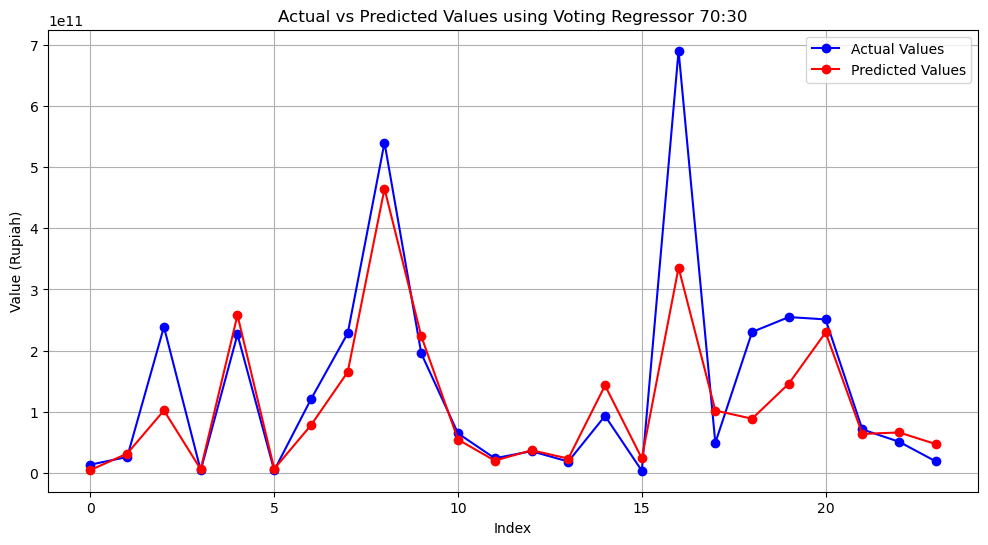

In [83]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()

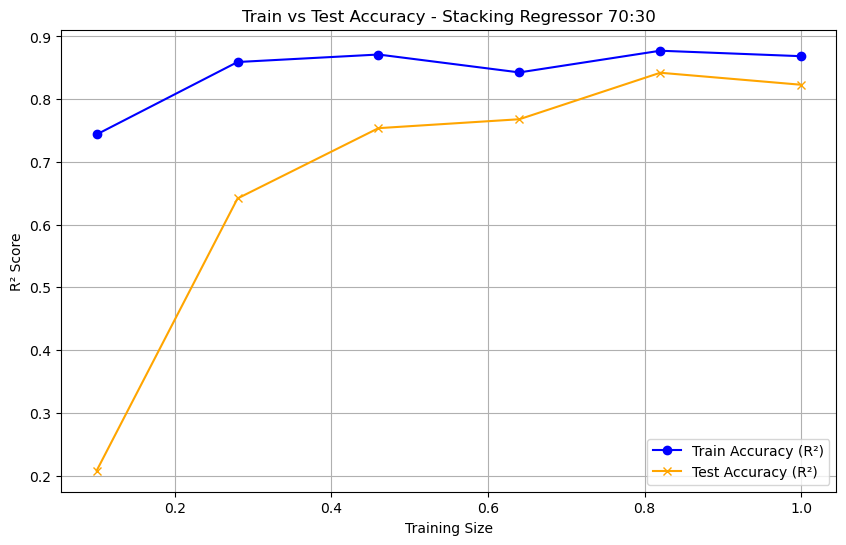

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()

Stacking Regressor 80:20

Stacking 1

In [93]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        ('KNN2', knn2),
        ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.454
Root Mean Squared Error (MSE):  0.571
R² Score:  0.870
Testing
Mean Absolute Error (MAE):  0.468
Root Mean Squared Error (MSE):  0.729
R² Score:  0.772


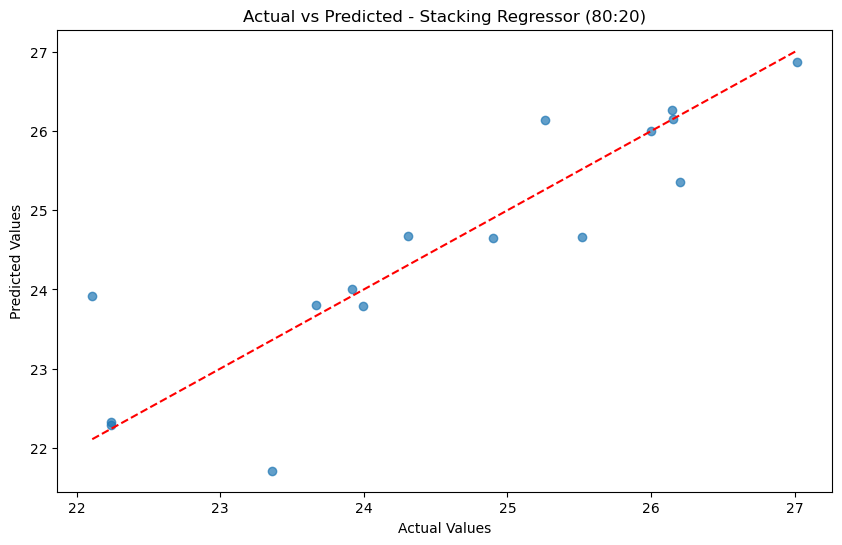

In [94]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [95]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  21.710813
0   23.997354  23.791685
27  26.199729  25.362802
39  22.237415  22.291710
21  26.146404  26.266402


In [96]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 2.684.642.218
0    Rp 26.419.136.187   Rp 21.507.884.639
27  Rp 239.000.000.001  Rp 103.496.313.714
39    Rp 4.545.551.009    Rp 4.799.176.290
21  Rp 226.589.000.001  Rp 255.478.011.575
35    Rp 4.545.551.009    Rp 4.993.127.909
10  Rp 120.781.089.488   Rp 51.135.015.195
92  Rp 228.530.000.001  Rp 228.725.403.613
4   Rp 540.031.588.145  Rp 465.763.669.316
13  Rp 195.596.000.001  Rp 195.119.363.752
64   Rp 65.000.000.001   Rp 50.944.784.336
41   Rp 24.322.000.001   Rp 26.505.435.967
88   Rp 35.905.245.001   Rp 51.860.227.841
43   Rp 18.970.782.261   Rp 21.713.943.616
89   Rp 93.541.144.803  Rp 224.305.558.003
59    Rp 3.997.225.850   Rp 24.407.720.464


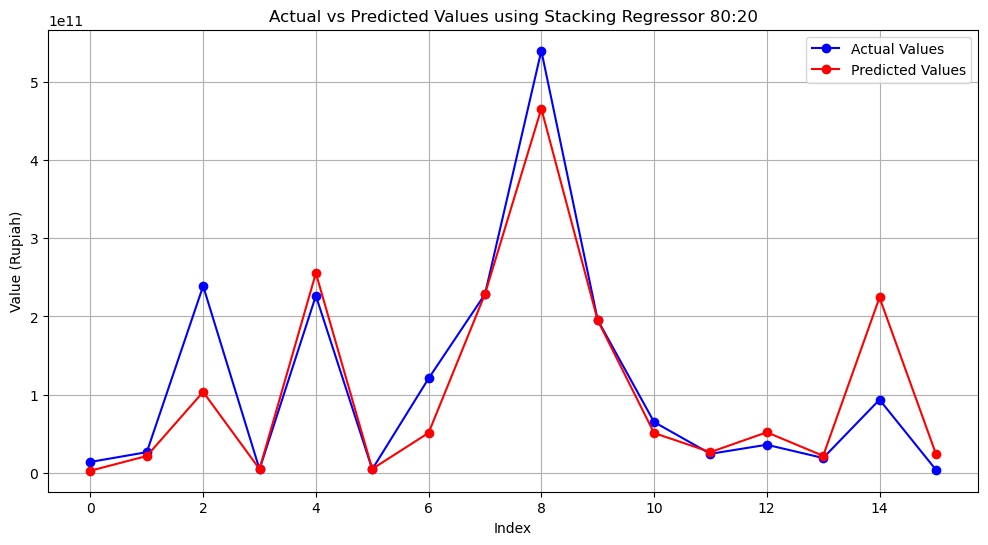

In [97]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

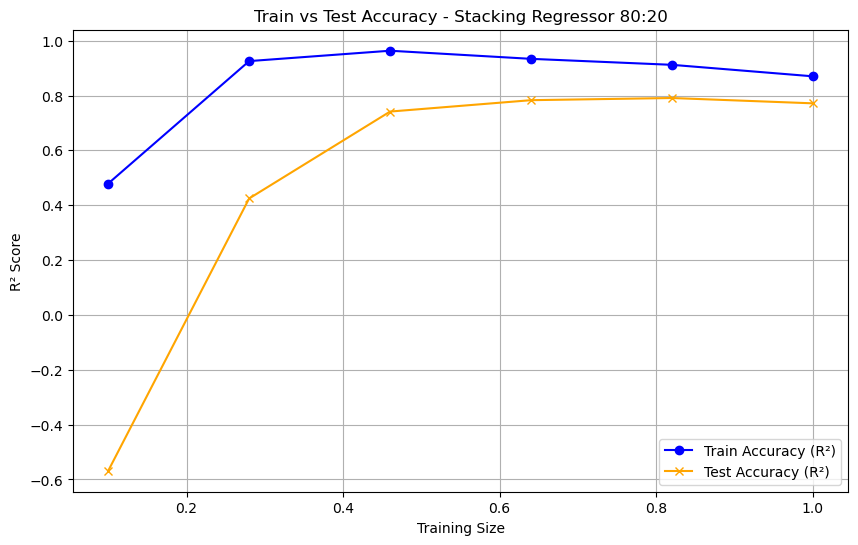

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 2

In [99]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.471
Root Mean Squared Error (MSE):  0.587
R² Score:  0.863
Testing
Mean Absolute Error (MAE):  0.478
Root Mean Squared Error (MSE):  0.695
R² Score:  0.792


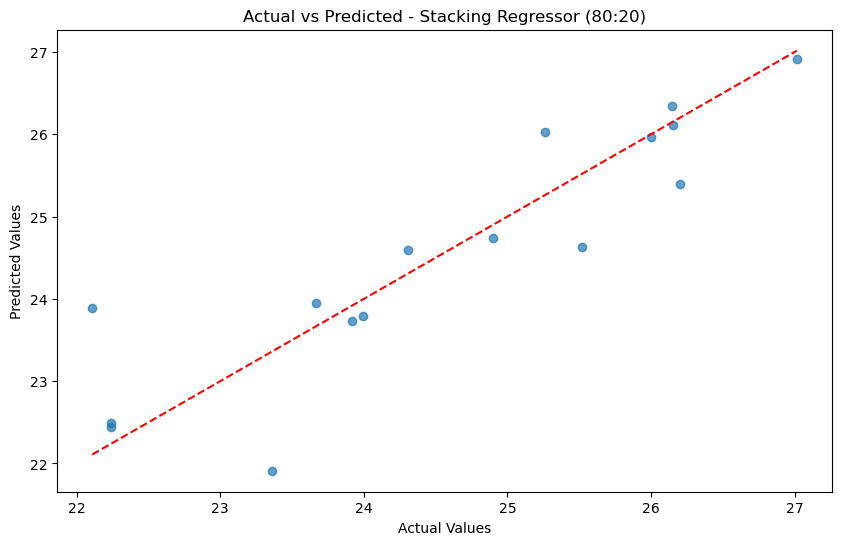

In [100]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [101]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  21.911827
0   23.997354  23.792504
27  26.199729  25.393093
39  22.237415  22.438053
21  26.146404  26.346980


In [102]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.282.356.607
0    Rp 26.419.136.187   Rp 21.525.501.172
27  Rp 239.000.000.001  Rp 106.679.339.324
39    Rp 4.545.551.009    Rp 5.555.490.393
21  Rp 226.589.000.001  Rp 276.915.998.746
35    Rp 4.545.551.009    Rp 5.834.776.090
10  Rp 120.781.089.488   Rp 49.533.703.804
92  Rp 228.530.000.001  Rp 217.797.960.471
4   Rp 540.031.588.145  Rp 486.787.831.525
13  Rp 195.596.000.001  Rp 189.514.234.605
64   Rp 65.000.000.001   Rp 55.617.970.910
41   Rp 24.322.000.001   Rp 20.301.810.268
88   Rp 35.905.245.001   Rp 47.819.678.267
43   Rp 18.970.782.261   Rp 25.197.178.626
89   Rp 93.541.144.803  Rp 201.796.008.139
59    Rp 3.997.225.850   Rp 23.824.357.669


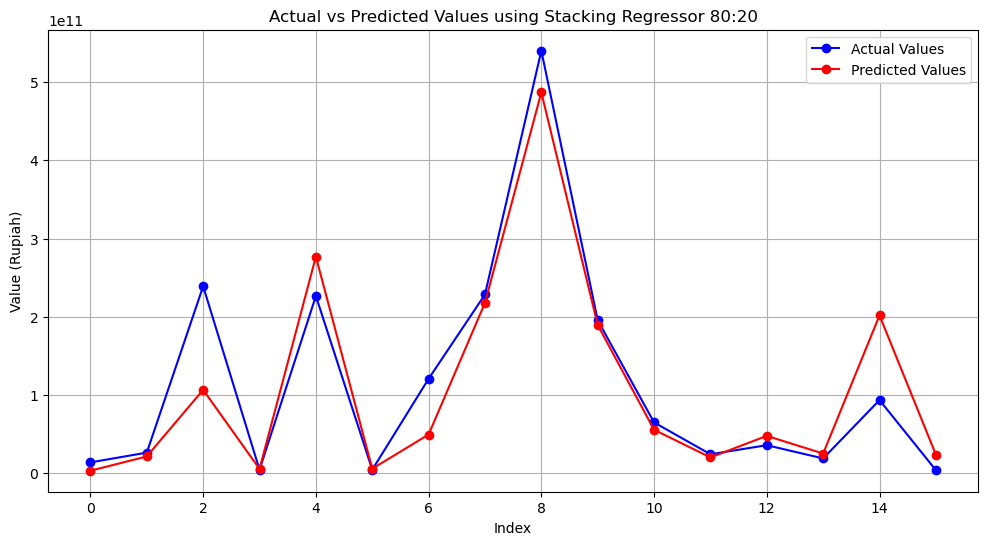

In [103]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

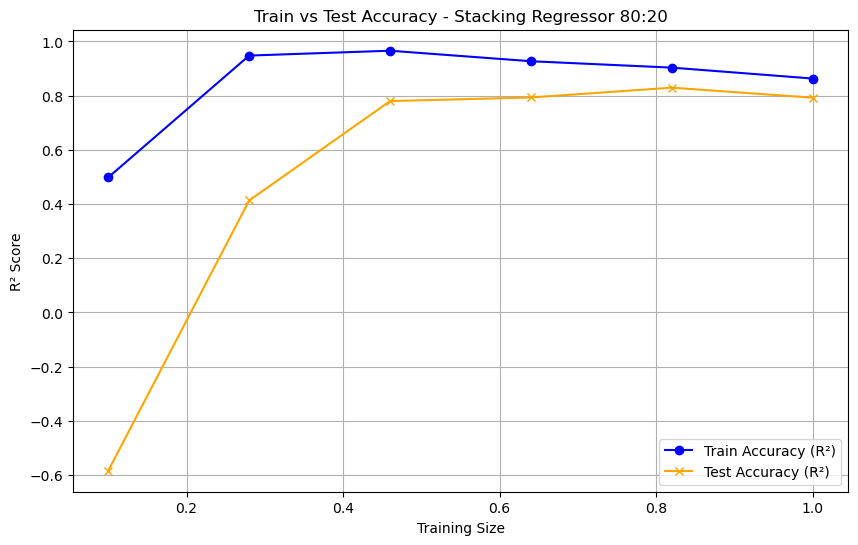

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 3

In [105]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.477
Root Mean Squared Error (MSE):  0.600
R² Score:  0.857
Testing
Mean Absolute Error (MAE):  0.421
Root Mean Squared Error (MSE):  0.649
R² Score:  0.819


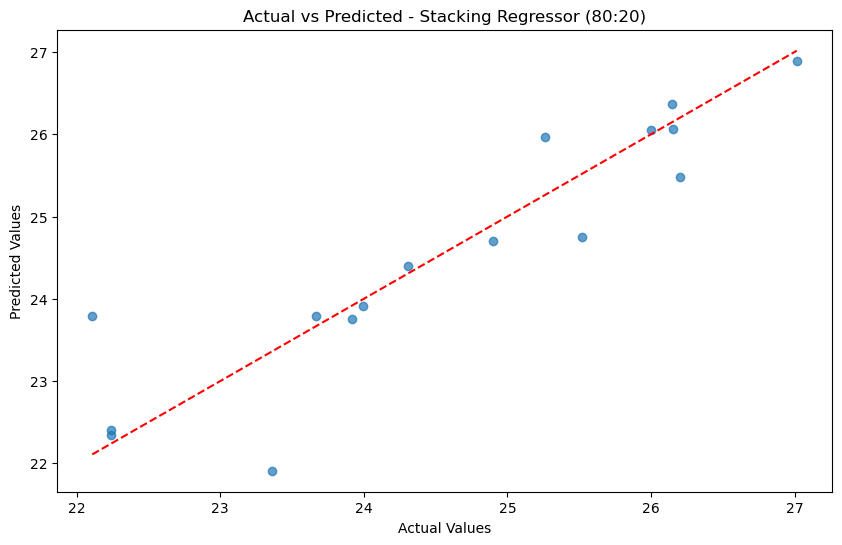

In [106]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [107]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  21.910643
0   23.997354  23.913569
27  26.199729  25.476727
39  22.237415  22.344247
21  26.146404  26.364170


In [108]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.278.469.884
0    Rp 26.419.136.187   Rp 24.295.793.075
27  Rp 239.000.000.001  Rp 115.985.070.852
39    Rp 4.545.551.009    Rp 5.058.049.447
21  Rp 226.589.000.001  Rp 281.717.385.837
35    Rp 4.545.551.009    Rp 5.351.132.644
10  Rp 120.781.089.488   Rp 56.034.461.007
92  Rp 228.530.000.001  Rp 209.459.255.975
4   Rp 540.031.588.145  Rp 475.640.619.281
13  Rp 195.596.000.001  Rp 205.412.716.837
64   Rp 65.000.000.001   Rp 53.435.191.684
41   Rp 24.322.000.001   Rp 20.646.622.700
88   Rp 35.905.245.001   Rp 39.668.088.406
43   Rp 18.970.782.261   Rp 21.584.130.313
89   Rp 93.541.144.803  Rp 188.361.663.615
59    Rp 3.997.225.850   Rp 21.505.360.417


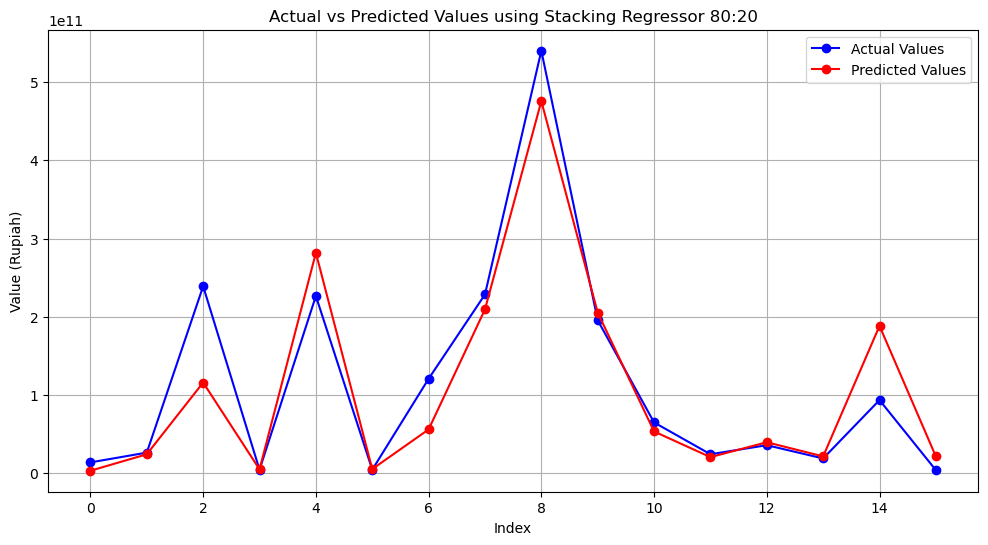

In [109]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

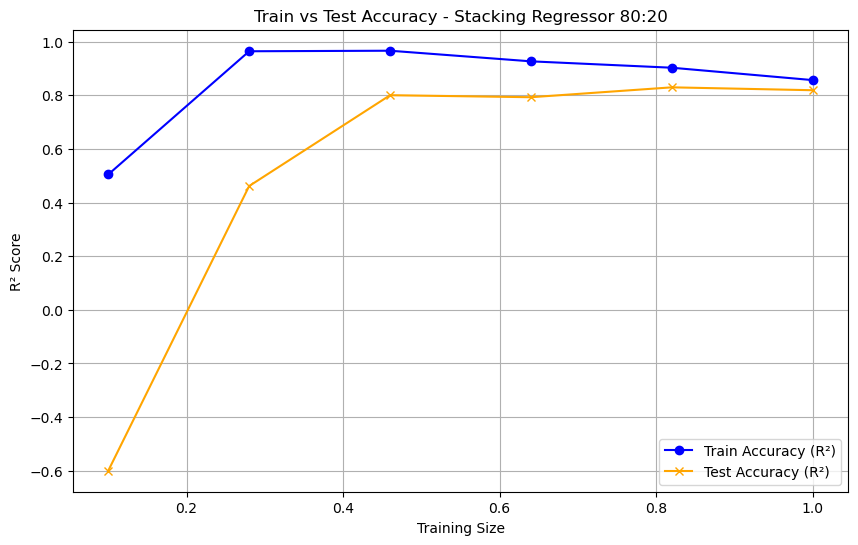

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 4

In [111]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.483
Root Mean Squared Error (MSE):  0.605
R² Score:  0.854
Testing
Mean Absolute Error (MAE):  0.404
Root Mean Squared Error (MSE):  0.646
R² Score:  0.821


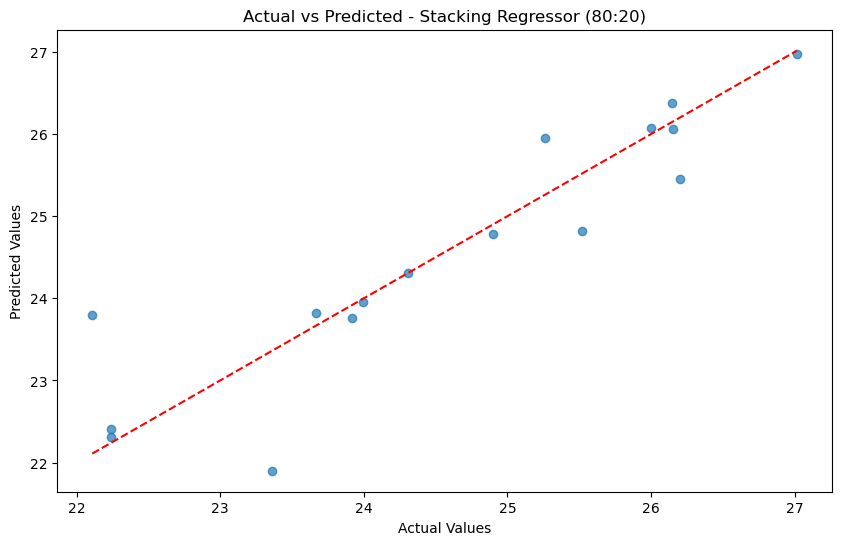

In [112]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [113]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  21.900199
0   23.997354  23.949715
27  26.199729  25.449661
39  22.237415  22.306975
21  26.146404  26.384048


In [114]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.244.407.349
0    Rp 26.419.136.187   Rp 25.190.051.670
27  Rp 239.000.000.001  Rp 112.887.854.160
39    Rp 4.545.551.009    Rp 4.872.997.273
21  Rp 226.589.000.001  Rp 287.373.209.098
35    Rp 4.545.551.009    Rp 5.409.778.077
10  Rp 120.781.089.488   Rp 59.965.111.618
92  Rp 228.530.000.001  Rp 208.025.867.058
4   Rp 540.031.588.145  Rp 517.159.034.399
13  Rp 195.596.000.001  Rp 212.001.764.861
64   Rp 65.000.000.001   Rp 57.700.341.049
41   Rp 24.322.000.001   Rp 20.833.187.496
88   Rp 35.905.245.001   Rp 36.238.747.916
43   Rp 18.970.782.261   Rp 22.226.955.897
89   Rp 93.541.144.803  Rp 186.155.362.164
59    Rp 3.997.225.850   Rp 21.602.423.612


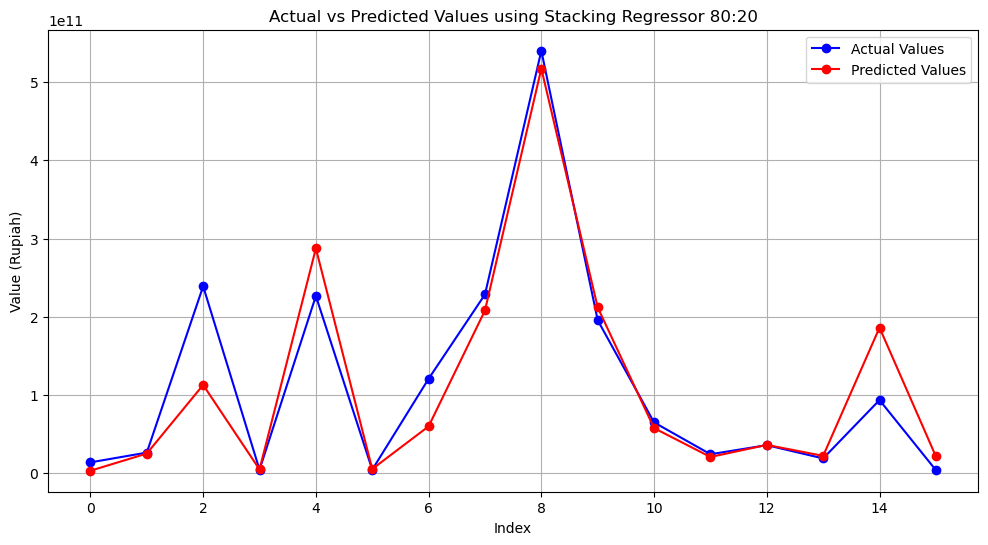

In [115]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

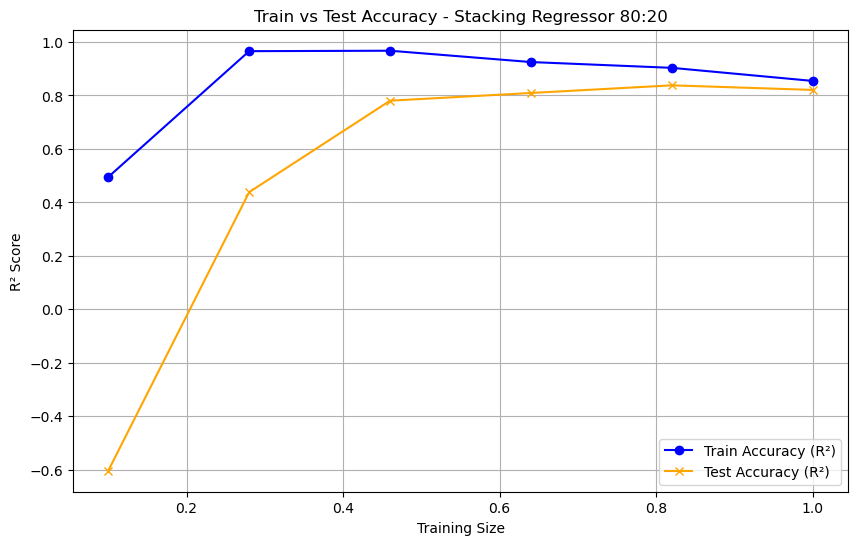

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 5

In [117]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.479
Root Mean Squared Error (MSE):  0.616
R² Score:  0.849
Testing
Mean Absolute Error (MAE):  0.397
Root Mean Squared Error (MSE):  0.637
R² Score:  0.825


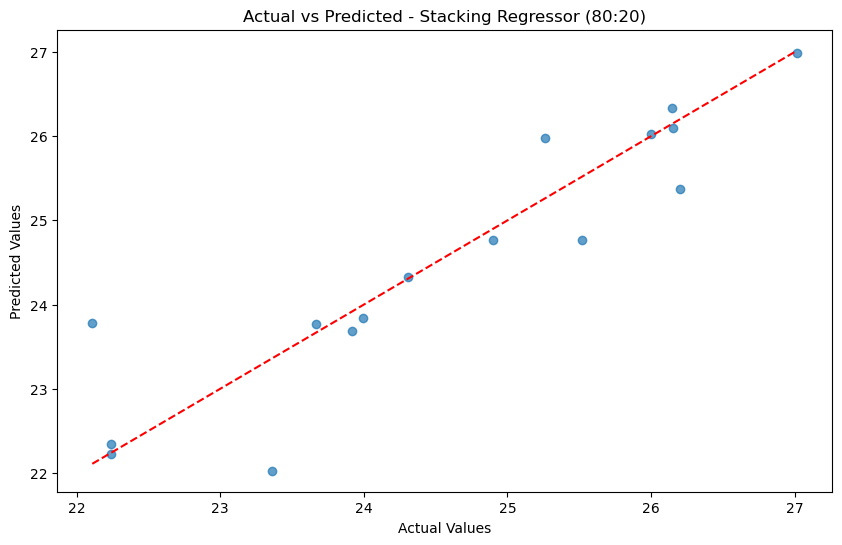

In [118]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [119]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.026835
0   23.997354  23.841638
27  26.199729  25.369205
39  22.237415  22.228230
21  26.146404  26.335249


In [120]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.682.417.019
0    Rp 26.419.136.187   Rp 22.609.545.323
27  Rp 239.000.000.001  Rp 104.161.117.716
39    Rp 4.545.551.009    Rp 4.503.992.385
21  Rp 226.589.000.001  Rp 273.686.552.257
35    Rp 4.545.551.009    Rp 5.059.076.776
10  Rp 120.781.089.488   Rp 56.983.825.682
92  Rp 228.530.000.001  Rp 214.584.740.785
4   Rp 540.031.588.145  Rp 528.741.548.149
13  Rp 195.596.000.001  Rp 201.123.644.501
64   Rp 65.000.000.001   Rp 57.286.624.825
41   Rp 24.322.000.001   Rp 19.284.531.128
88   Rp 35.905.245.001   Rp 36.664.370.578
43   Rp 18.970.782.261   Rp 21.051.311.836
89   Rp 93.541.144.803  Rp 190.827.921.546
59    Rp 3.997.225.850   Rp 21.346.837.568


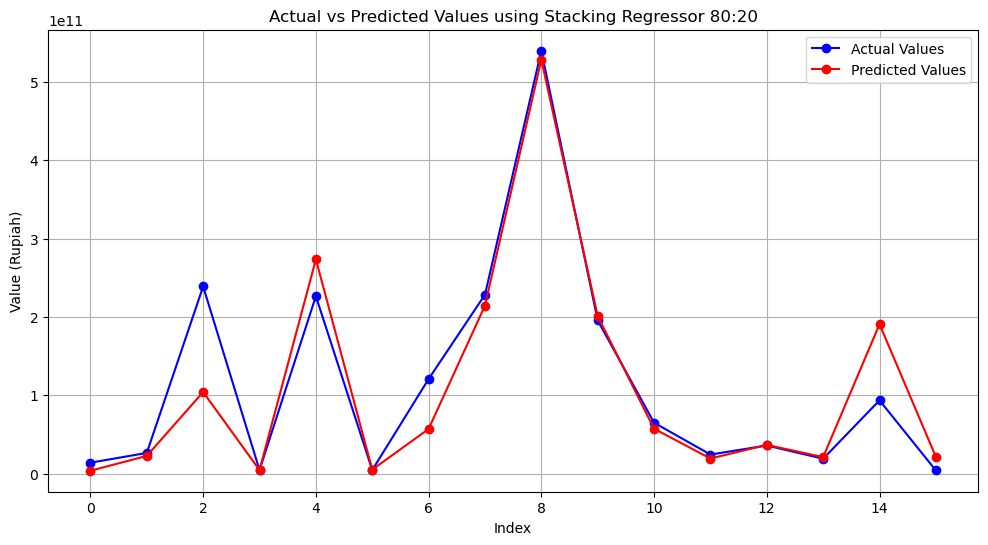

In [121]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

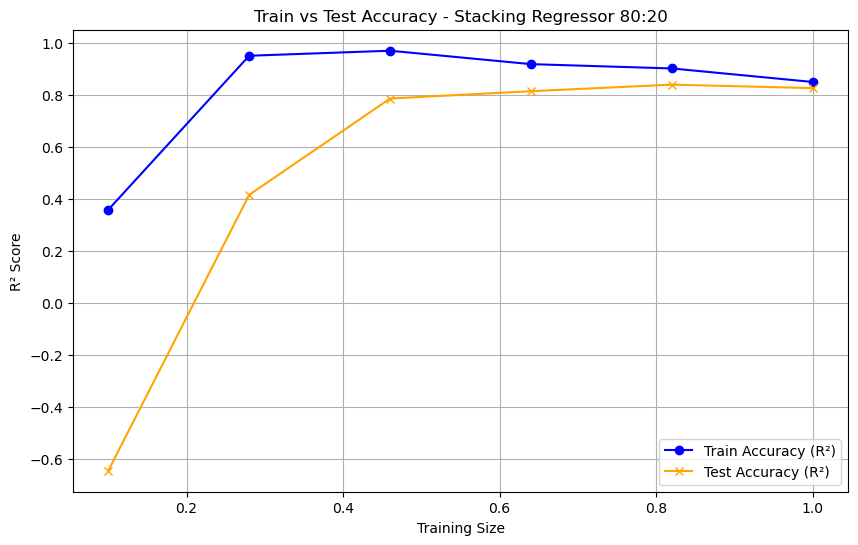

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 6

In [123]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.472
Root Mean Squared Error (MSE):  0.611
R² Score:  0.852
Testing
Mean Absolute Error (MAE):  0.397
Root Mean Squared Error (MSE):  0.629
R² Score:  0.830


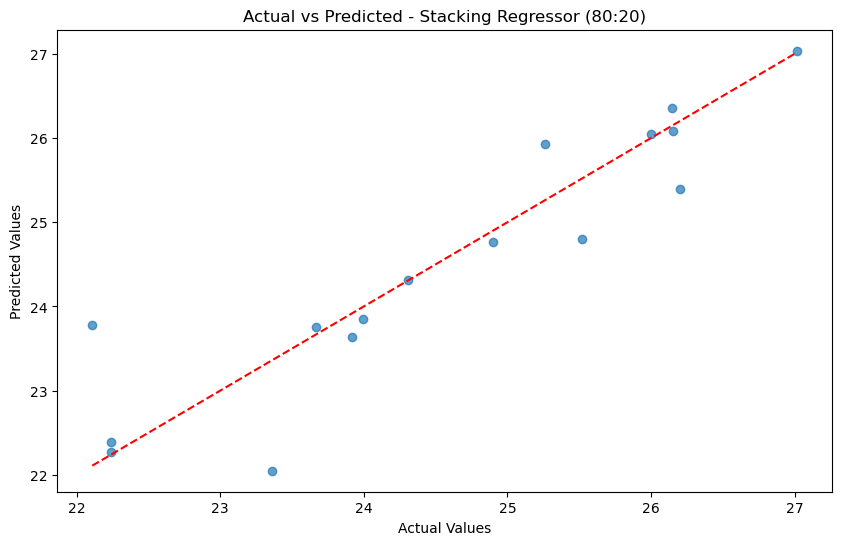

In [124]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [125]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.048951
0   23.997354  23.850169
27  26.199729  25.394152
39  22.237415  22.267614
21  26.146404  26.361320


In [126]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.764.764.783
0    Rp 26.419.136.187   Rp 22.803.252.317
27  Rp 239.000.000.001  Rp 106.792.354.739
39    Rp 4.545.551.009    Rp 4.684.914.834
21  Rp 226.589.000.001  Rp 280.915.465.544
35    Rp 4.545.551.009    Rp 5.277.009.743
10  Rp 120.781.089.488   Rp 58.977.578.838
92  Rp 228.530.000.001  Rp 213.873.568.664
4   Rp 540.031.588.145  Rp 551.758.214.047
13  Rp 195.596.000.001  Rp 204.185.711.225
64   Rp 65.000.000.001   Rp 56.974.169.811
41   Rp 24.322.000.001   Rp 18.520.798.187
88   Rp 35.905.245.001   Rp 36.081.031.213
43   Rp 18.970.782.261   Rp 20.699.527.348
89   Rp 93.541.144.803  Rp 183.065.561.262
59    Rp 3.997.225.850   Rp 21.328.916.592


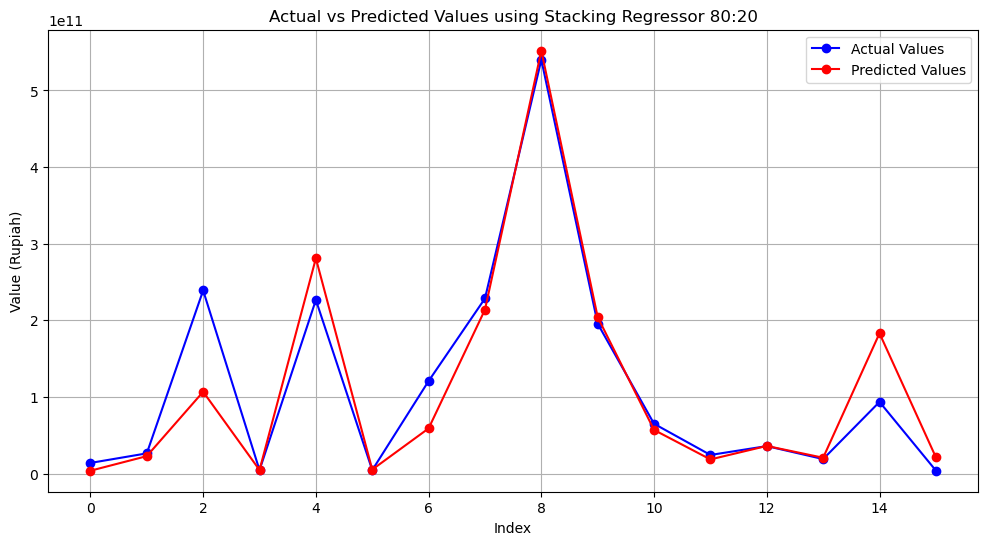

In [127]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

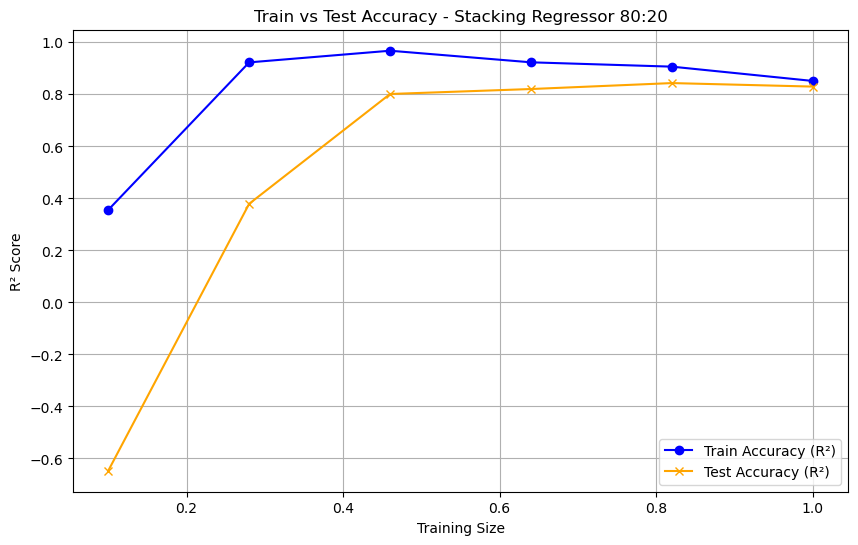

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 7

In [129]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.494
Root Mean Squared Error (MSE):  0.642
R² Score:  0.836
Testing
Mean Absolute Error (MAE):  0.388
Root Mean Squared Error (MSE):  0.597
R² Score:  0.847


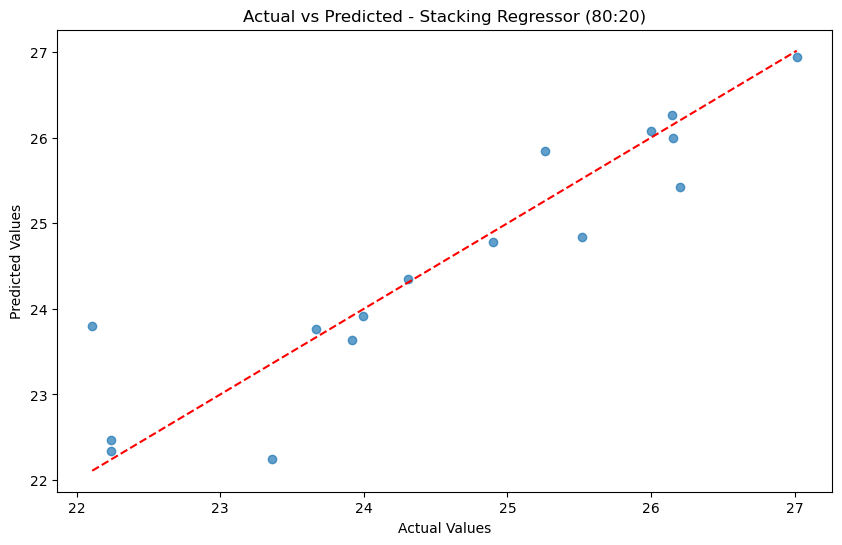

In [130]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [132]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.242558
0   23.997354  23.915202
27  26.199729  25.425584
39  22.237415  22.339041
21  26.146404  26.264829


In [133]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.568.990.841
0    Rp 26.419.136.187   Rp 24.335.491.260
27  Rp 239.000.000.001  Rp 110.202.360.149
39    Rp 4.545.551.009    Rp 5.031.785.044
21  Rp 226.589.000.001  Rp 255.076.485.812
35    Rp 4.545.551.009    Rp 5.704.314.251
10  Rp 120.781.089.488   Rp 61.415.169.218
92  Rp 228.530.000.001  Rp 195.614.937.963
4   Rp 540.031.588.145  Rp 504.549.335.794
13  Rp 195.596.000.001  Rp 210.904.659.952
64   Rp 65.000.000.001   Rp 57.548.899.032
41   Rp 24.322.000.001   Rp 18.434.726.054
88   Rp 35.905.245.001   Rp 37.626.940.141
43   Rp 18.970.782.261   Rp 20.878.948.530
89   Rp 93.541.144.803  Rp 167.519.817.289
59    Rp 3.997.225.850   Rp 21.592.775.132


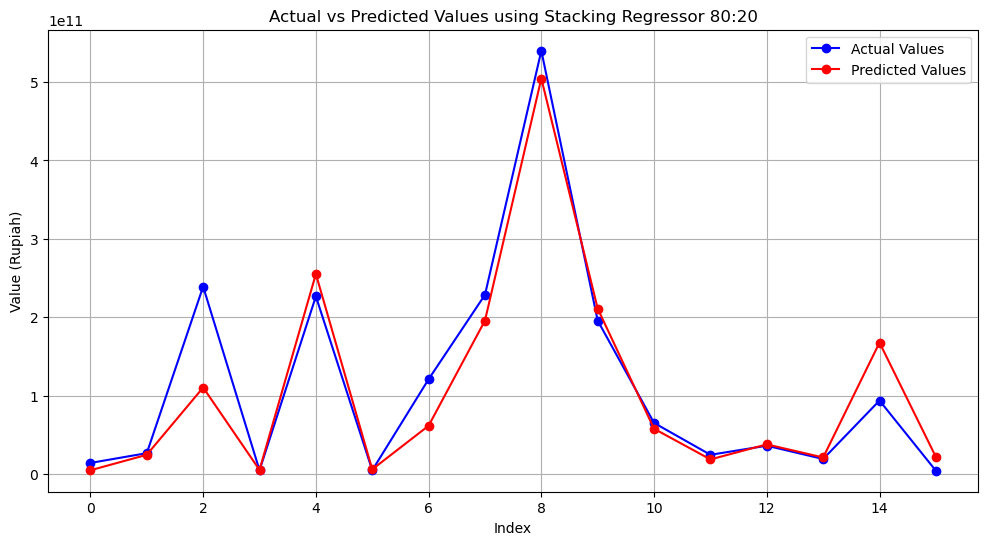

In [134]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

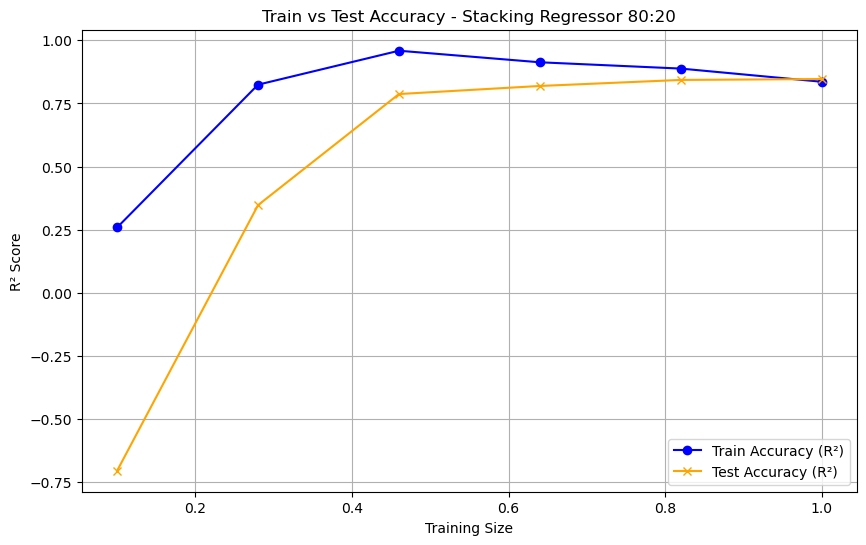

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 8

In [136]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        # ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.462
Root Mean Squared Error (MSE):  0.601
R² Score:  0.856
Testing
Mean Absolute Error (MAE):  0.382
Root Mean Squared Error (MSE):  0.576
R² Score:  0.857


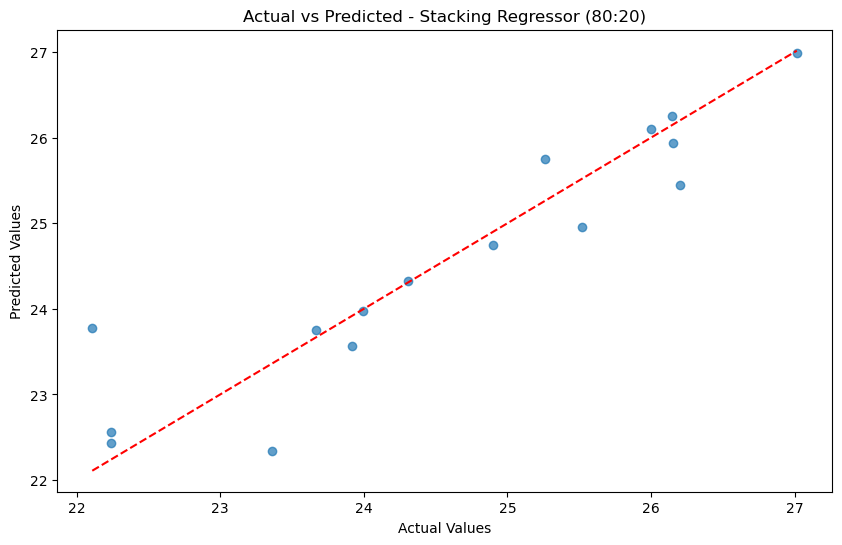

In [137]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [138]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.340923
0   23.997354  23.968871
27  26.199729  25.450737
39  22.237415  22.438469
21  26.146404  26.254274


In [139]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.041.267.777
0    Rp 26.419.136.187   Rp 25.677.242.188
27  Rp 239.000.000.001  Rp 113.009.391.819
39    Rp 4.545.551.009    Rp 5.557.802.943
21  Rp 226.589.000.001  Rp 252.398.266.537
35    Rp 4.545.551.009    Rp 6.295.362.132
10  Rp 120.781.089.488   Rp 68.624.936.172
92  Rp 228.530.000.001  Rp 183.355.339.527
4   Rp 540.031.588.145  Rp 527.591.772.718
13  Rp 195.596.000.001  Rp 217.532.953.849
64   Rp 65.000.000.001   Rp 55.838.202.097
41   Rp 24.322.000.001   Rp 17.161.734.063
88   Rp 35.905.245.001   Rp 36.836.176.652
43   Rp 18.970.782.261   Rp 20.731.971.664
89   Rp 93.541.144.803  Rp 152.515.173.302
59    Rp 3.997.225.850   Rp 21.202.475.604


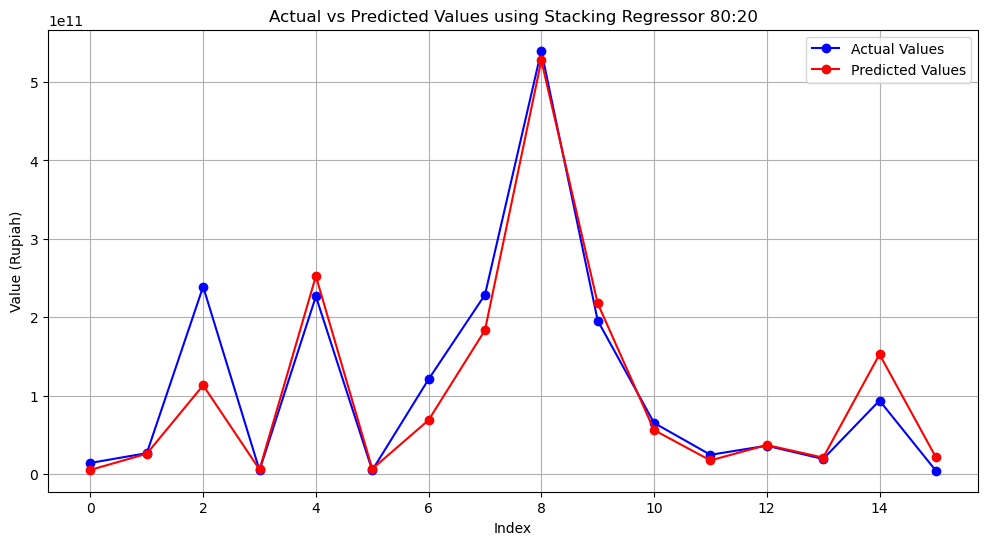

In [140]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

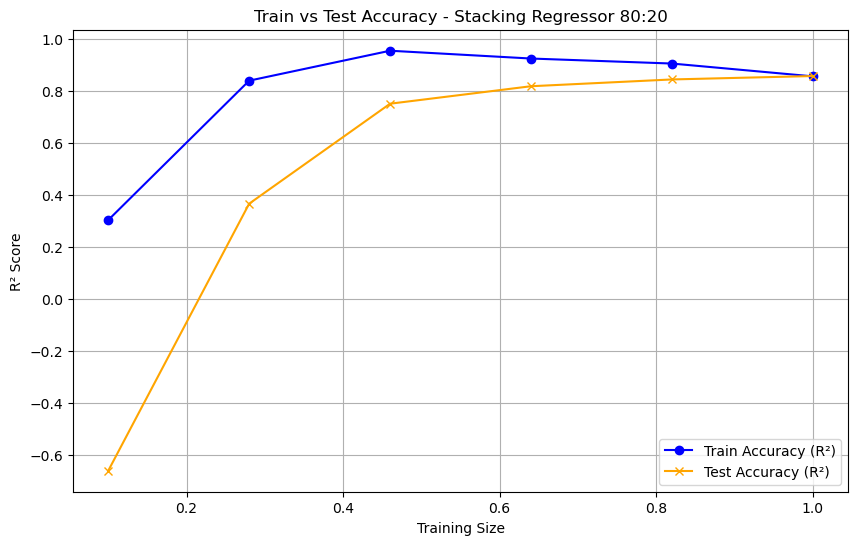

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Stacking 9

In [142]:
from sklearn.pipeline import make_pipeline

# 2. Definisi model individual

rf2 = RandomForestRegressor(random_state=42)
ridge2 = Ridge(random_state=42)
xgboost2 = xgb.XGBRegressor()
br2 = BayesianRidge()
gb2 = GradientBoostingRegressor(random_state=42)
lr2 = LinearRegression()
adb2 = AdaBoostRegressor(random_state=42)
knn2 = KNeighborsRegressor(n_neighbors=3)
svr2 = SVR()
dt2 = DecisionTreeRegressor(random_state=42)


meta_model2 = Ridge(alpha=10, random_state=42)

# 3. Membuat Stacking Regressor
stacking_regressor2 = StackingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        # ('rf2', rf2),
        # ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    final_estimator=meta_model2)

# 4. Melatih Stacking Regressor
stacking_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_stacking2 = stacking_regressor2.predict(X_train2)
mae_train_stacking2 = mean_absolute_error(y_train2, y_train_pred_stacking2)
rmse_train_stacking2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_stacking2))
r2_train_stacking2 = r2_score(y_train2, y_train_pred_stacking2)

# Testing
y_test_pred_stacking2 = stacking_regressor2.predict(X_test2)
mae_test_stacking2 = mean_absolute_error(y_test2, y_test_pred_stacking2)
rmse_test_stacking2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_stacking2))
r2_test_stacking2 = r2_score(y_test2, y_test_pred_stacking2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_train_stacking2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_stacking2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_stacking2))
print(f"R² Score: ", "{:.3f}".format(r2_test_stacking2))

Training
Mean Absolute Error (MAE):  0.463
Root Mean Squared Error (MSE):  0.607
R² Score:  0.853
Testing
Mean Absolute Error (MAE):  0.393
Root Mean Squared Error (MSE):  0.581
R² Score:  0.855


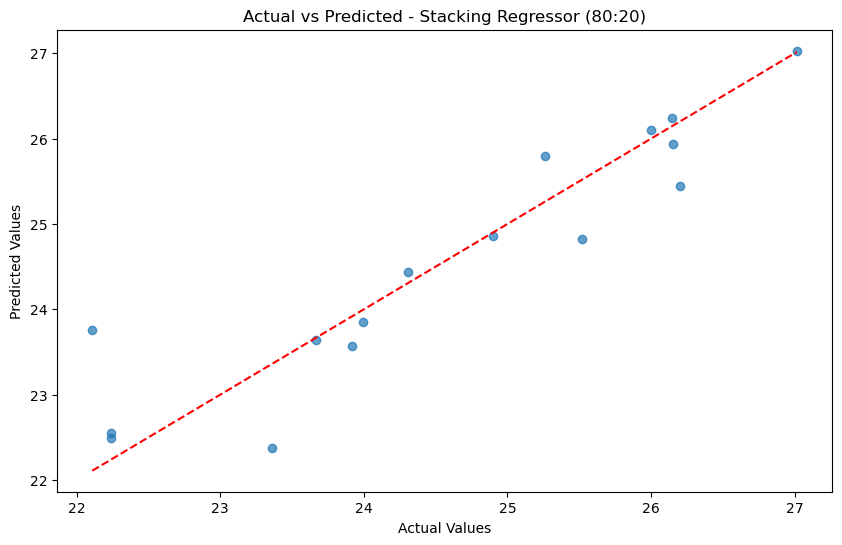

In [143]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = stacking_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Stacking Regressor (80:20)")
plt.show()

In [144]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.378582
0   23.997354  23.852625
27  26.199729  25.442828
39  22.237415  22.491670
21  26.146404  26.240875


In [145]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.234.734.244
0    Rp 26.419.136.187   Rp 22.859.317.629
27  Rp 239.000.000.001  Rp 112.119.203.790
39    Rp 4.545.551.009    Rp 5.861.492.277
21  Rp 226.589.000.001  Rp 249.039.002.306
35    Rp 4.545.551.009    Rp 6.240.667.076
10  Rp 120.781.089.488   Rp 60.214.870.373
92  Rp 228.530.000.001  Rp 184.267.056.897
4   Rp 540.031.588.145  Rp 548.360.796.683
13  Rp 195.596.000.001  Rp 216.029.271.679
64   Rp 65.000.000.001   Rp 62.858.287.635
41   Rp 24.322.000.001   Rp 17.251.260.822
88   Rp 35.905.245.001   Rp 41.197.084.433
43   Rp 18.970.782.261   Rp 18.421.295.772
89   Rp 93.541.144.803  Rp 159.529.660.732
59    Rp 3.997.225.850   Rp 20.719.682.239


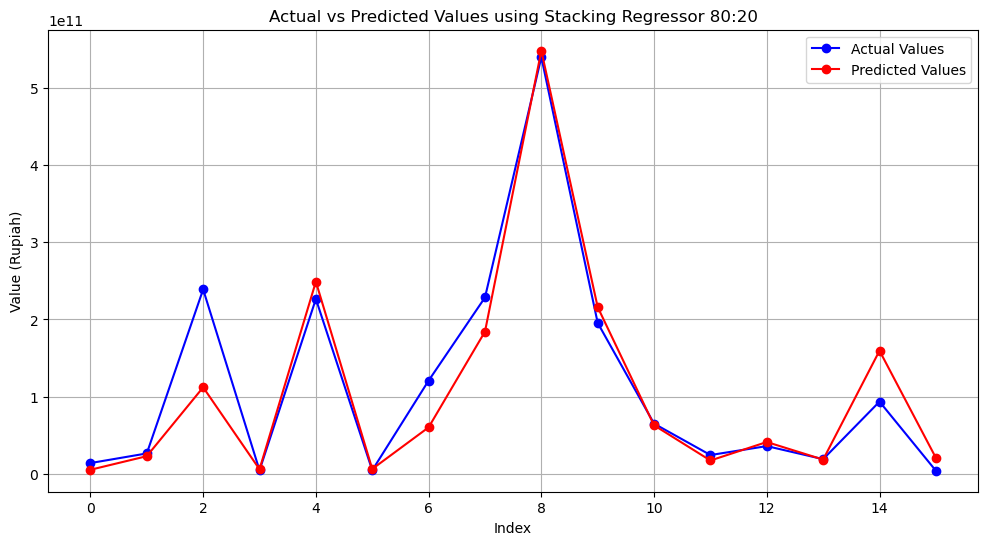

In [146]:
# Predict on the test data
y_pred_log2 = stacking_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

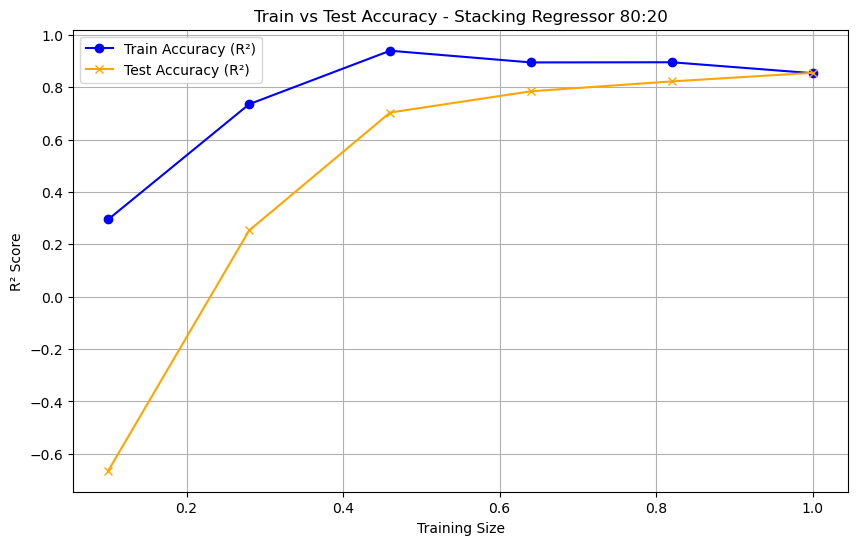

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    stacking_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = stacking_regressor2.predict(X_train_subset2)
    y_test_pred2 = stacking_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Stacking Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting Regressor 80:20

Voting 1

In [148]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        ('KNN2', knn2),
        ('SVR2', svr2),
    ],
    weights=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.331
Root Mean Squared Error (MSE):  0.415
R² Score:  0.931
Testing
Mean Absolute Error (MAE):  0.391
Root Mean Squared Error (MSE):  0.555
R² Score:  0.868


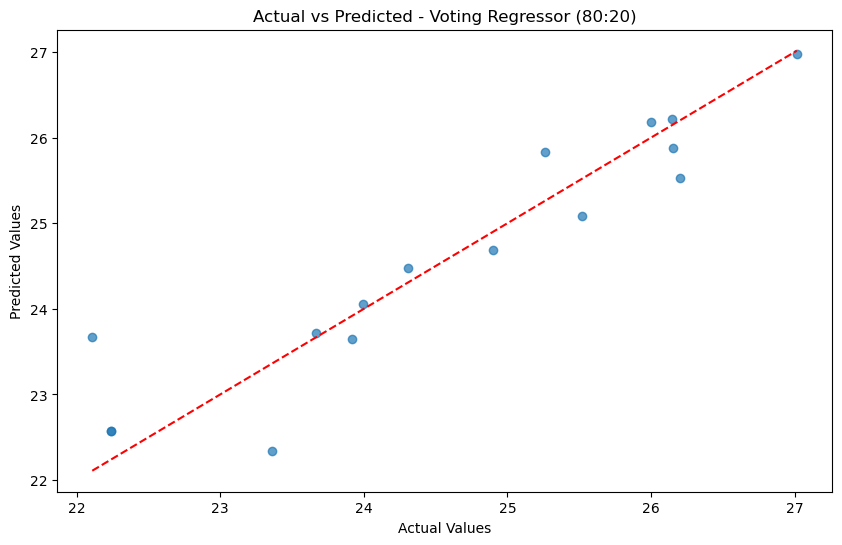

In [149]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [150]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.341912
0   23.997354  24.050562
27  26.199729  25.528434
39  22.237415  22.572758
21  26.146404  26.214231


In [151]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.046.253.647
0    Rp 26.419.136.187   Rp 27.862.896.113
27  Rp 239.000.000.001  Rp 122.139.991.984
39    Rp 4.545.551.009    Rp 6.356.587.760
21  Rp 226.589.000.001  Rp 242.491.083.526
35    Rp 4.545.551.009    Rp 6.341.109.069
10  Rp 120.781.089.488   Rp 77.892.981.076
92  Rp 228.530.000.001  Rp 172.927.882.370
4   Rp 540.031.588.145  Rp 520.638.240.053
13  Rp 195.596.000.001  Rp 234.722.888.906
64   Rp 65.000.000.001   Rp 52.833.011.770
41   Rp 24.322.000.001   Rp 18.628.392.098
88   Rp 35.905.245.001   Rp 42.836.745.081
43   Rp 18.970.782.261   Rp 20.003.809.515
89   Rp 93.541.144.803  Rp 165.700.480.590
59    Rp 3.997.225.850   Rp 19.045.637.756


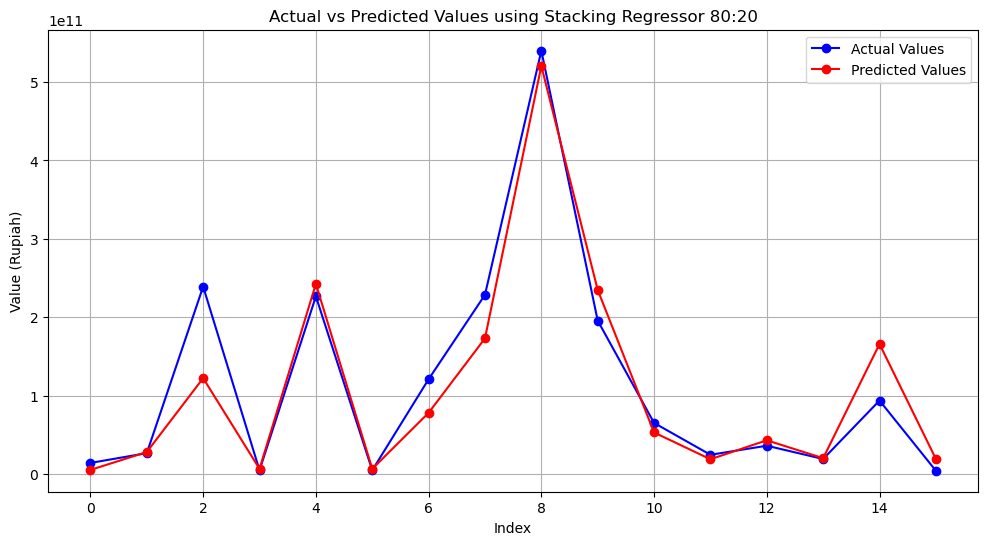

In [152]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

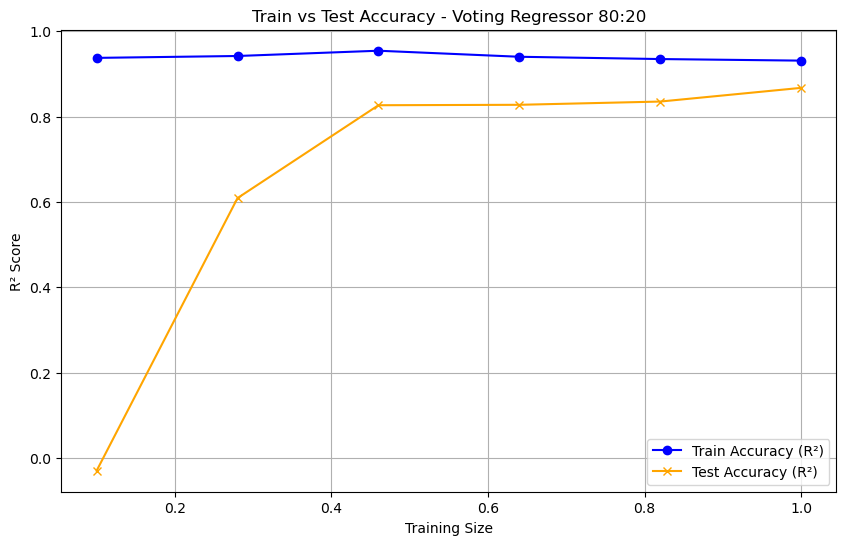

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 2

In [154]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[9, 8, 7, 6, 5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.318
Root Mean Squared Error (MSE):  0.400
R² Score:  0.936
Testing
Mean Absolute Error (MAE):  0.387
Root Mean Squared Error (MSE):  0.560
R² Score:  0.865


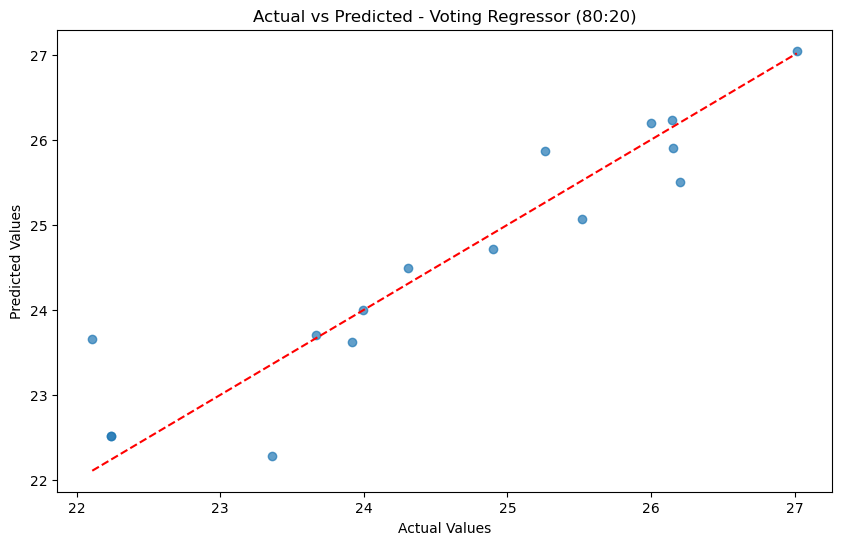

In [155]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [156]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.284061
0   23.997354  24.003001
27  26.199729  25.506895
39  22.237415  22.512033
21  26.146404  26.225996


In [157]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.762.604.661
0    Rp 26.419.136.187   Rp 26.568.740.191
27  Rp 239.000.000.001  Rp 119.537.330.144
39    Rp 4.545.551.009    Rp 5.982.070.093
21  Rp 226.589.000.001  Rp 245.360.893.072
35    Rp 4.545.551.009    Rp 6.032.468.008
10  Rp 120.781.089.488   Rp 77.067.894.728
92  Rp 228.530.000.001  Rp 177.006.878.982
4   Rp 540.031.588.145  Rp 557.226.297.043
13  Rp 195.596.000.001  Rp 239.127.116.404
64   Rp 65.000.000.001   Rp 54.009.212.335
41   Rp 24.322.000.001   Rp 18.232.057.231
88   Rp 35.905.245.001   Rp 43.264.767.188
43   Rp 18.970.782.261   Rp 19.748.776.096
89   Rp 93.541.144.803  Rp 171.132.775.434
59    Rp 3.997.225.850   Rp 18.832.622.557


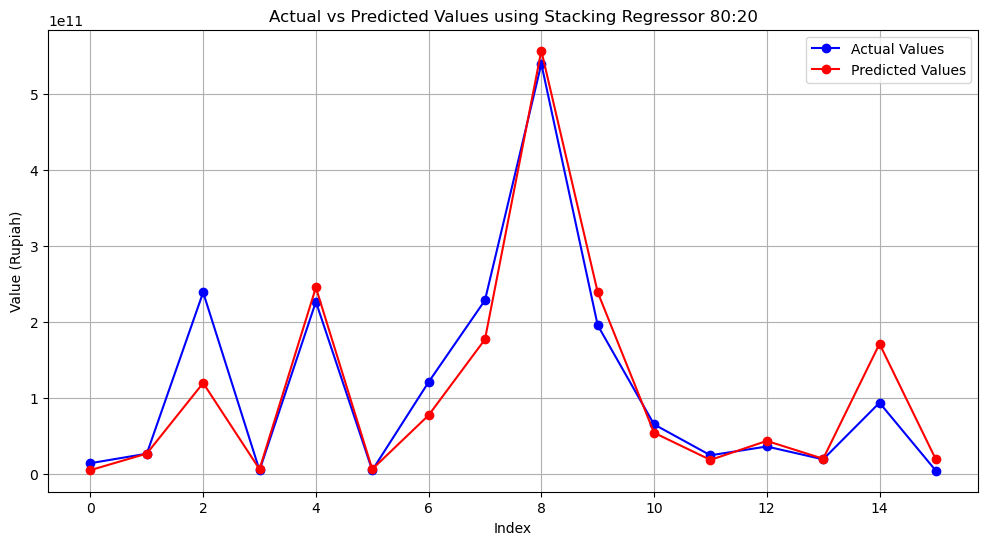

In [158]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

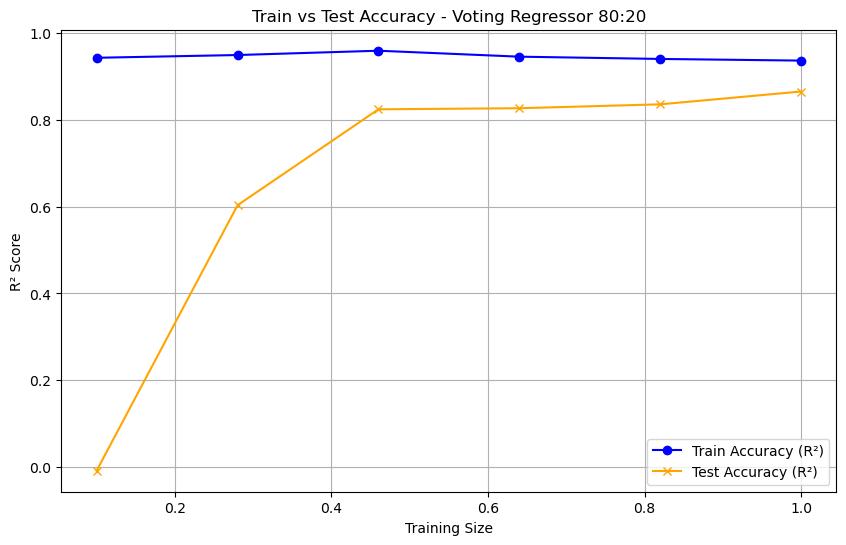

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 3

In [161]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[8, 7, 6, 5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.312
Root Mean Squared Error (MSE):  0.395
R² Score:  0.938
Testing
Mean Absolute Error (MAE):  0.395
Root Mean Squared Error (MSE):  0.565
R² Score:  0.863


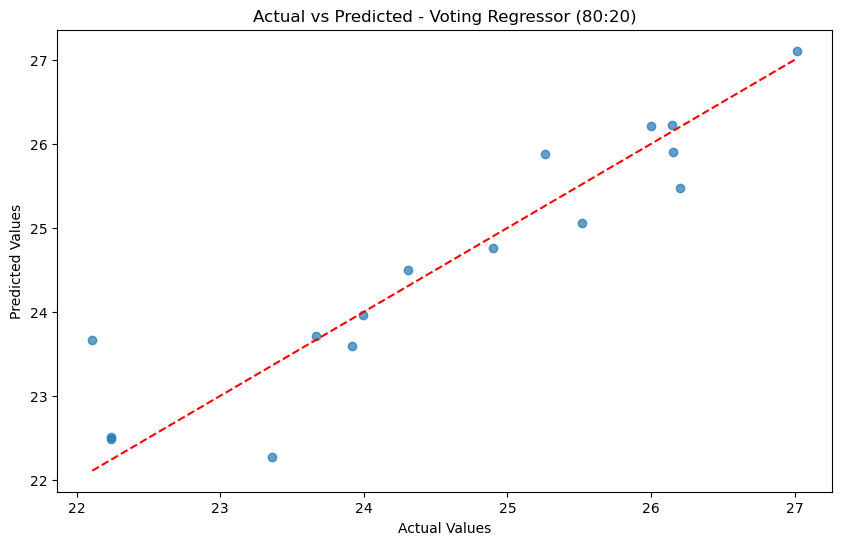

In [162]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [163]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.272444
0   23.997354  23.961426
27  26.199729  25.475414
39  22.237415  22.481131
21  26.146404  26.229341


In [164]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.707.600.598
0    Rp 26.419.136.187   Rp 25.486.790.654
27  Rp 239.000.000.001  Rp 115.832.850.277
39    Rp 4.545.551.009    Rp 5.800.044.511
21  Rp 226.589.000.001  Rp 246.182.998.573
35    Rp 4.545.551.009    Rp 5.948.871.643
10  Rp 120.781.089.488   Rp 76.214.858.478
92  Rp 228.530.000.001  Rp 178.614.423.318
4   Rp 540.031.588.145  Rp 593.099.530.111
13  Rp 195.596.000.001  Rp 240.709.838.335
64   Rp 65.000.000.001   Rp 56.326.113.396
41   Rp 24.322.000.001   Rp 17.654.707.641
88   Rp 35.905.245.001   Rp 43.444.685.537
43   Rp 18.970.782.261   Rp 19.977.135.544
89   Rp 93.541.144.803  Rp 173.548.947.410
59    Rp 3.997.225.850   Rp 18.839.237.422


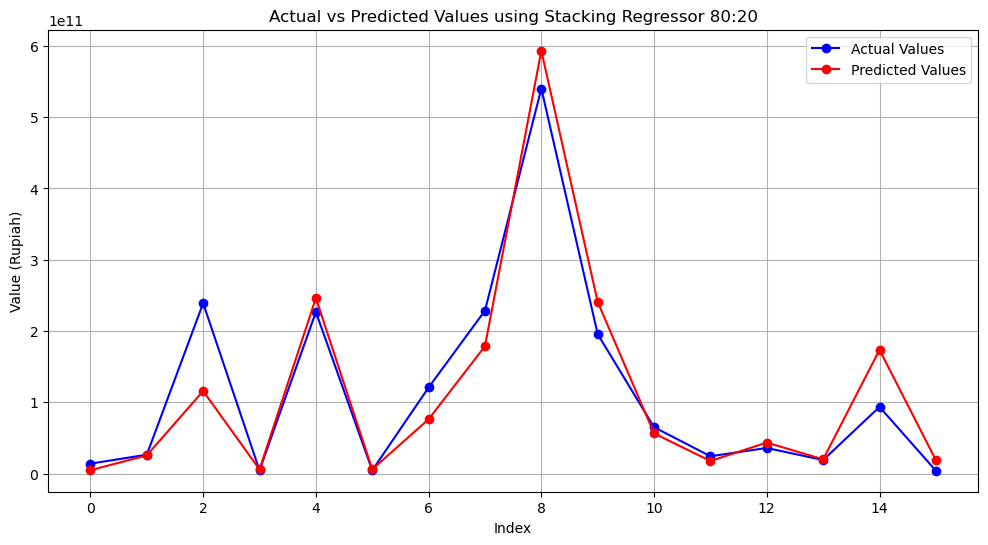

In [165]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

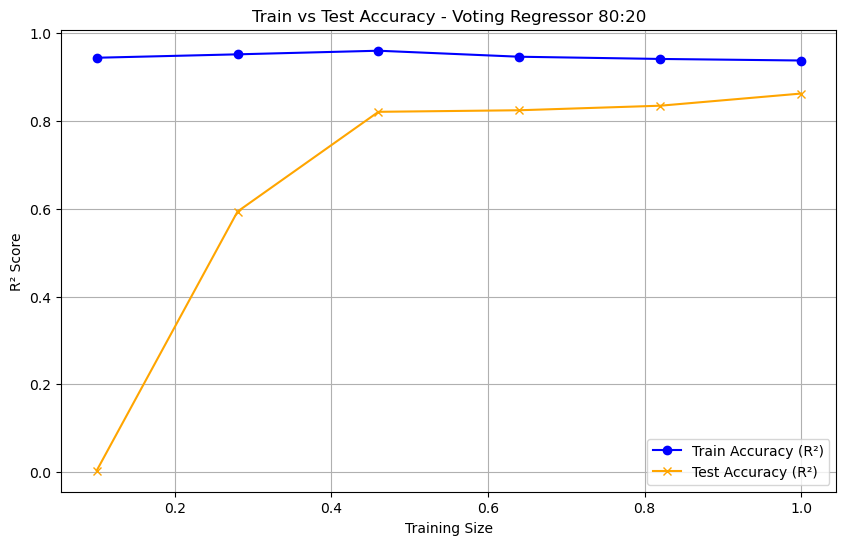

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 4

In [167]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[7, 6, 5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.316
Root Mean Squared Error (MSE):  0.402
R² Score:  0.936
Testing
Mean Absolute Error (MAE):  0.388
Root Mean Squared Error (MSE):  0.559
R² Score:  0.865


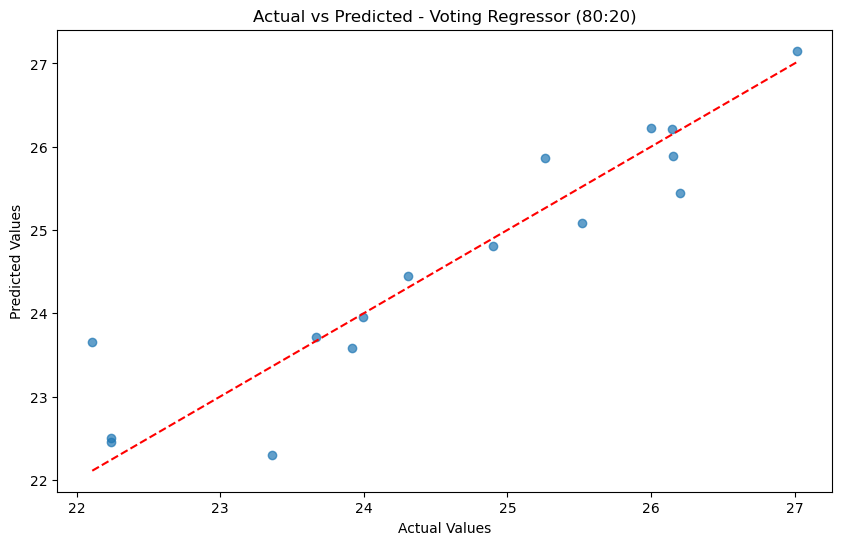

In [168]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [169]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.301699
0   23.997354  23.960636
27  26.199729  25.448195
39  22.237415  22.453536
21  26.146404  26.217365


In [170]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.847.353.916
0    Rp 26.419.136.187   Rp 25.466.656.203
27  Rp 239.000.000.001  Rp 112.722.569.365
39    Rp 4.545.551.009    Rp 5.642.179.862
21  Rp 226.589.000.001  Rp 243.252.192.890
35    Rp 4.545.551.009    Rp 5.941.353.340
10  Rp 120.781.089.488   Rp 78.167.201.232
92  Rp 228.530.000.001  Rp 175.451.577.182
4   Rp 540.031.588.145  Rp 619.594.564.032
13  Rp 195.596.000.001  Rp 243.789.096.531
64   Rp 65.000.000.001   Rp 59.060.335.631
41   Rp 24.322.000.001   Rp 17.345.902.091
88   Rp 35.905.245.001   Rp 41.463.464.581
43   Rp 18.970.782.261   Rp 19.812.441.612
89   Rp 93.541.144.803  Rp 170.018.331.285
59    Rp 3.997.225.850   Rp 18.668.429.849


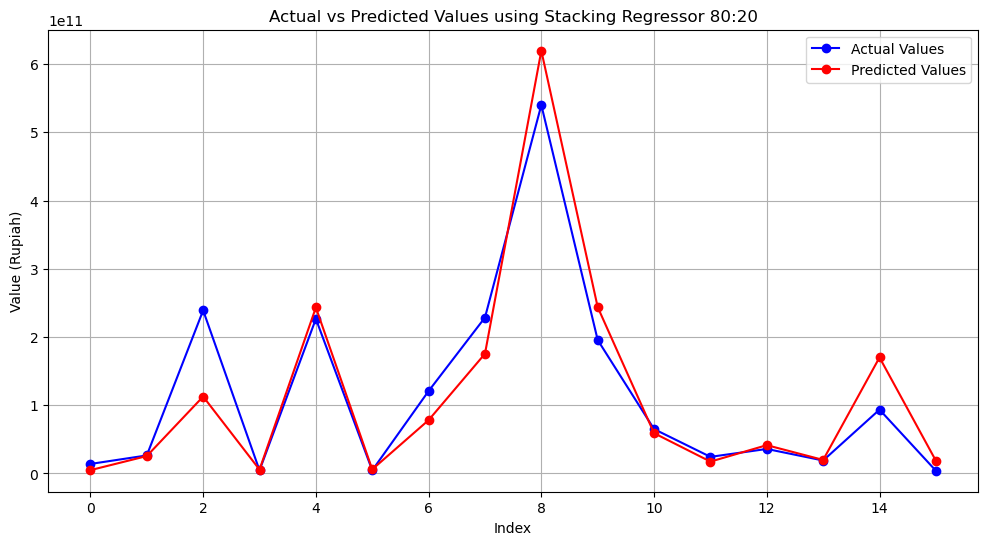

In [171]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

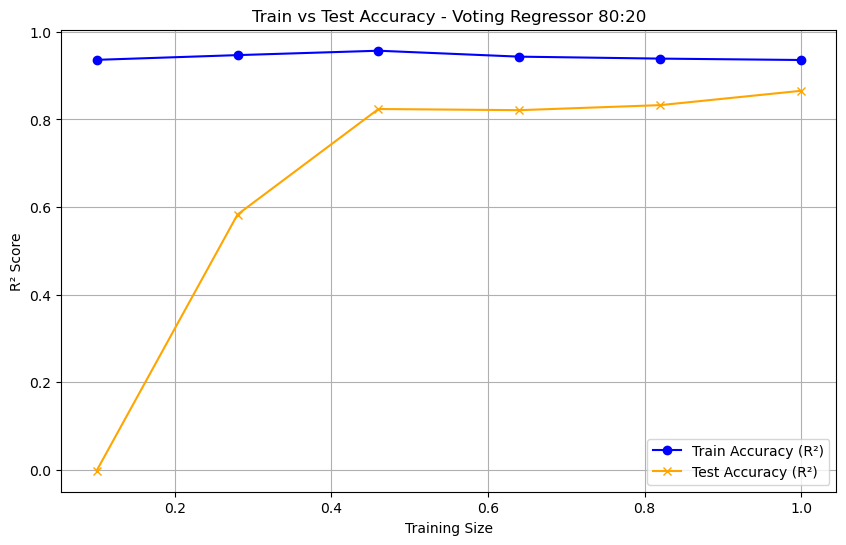

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 5

In [174]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[6, 5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.306
Root Mean Squared Error (MSE):  0.395
R² Score:  0.938
Testing
Mean Absolute Error (MAE):  0.386
Root Mean Squared Error (MSE):  0.552
R² Score:  0.869


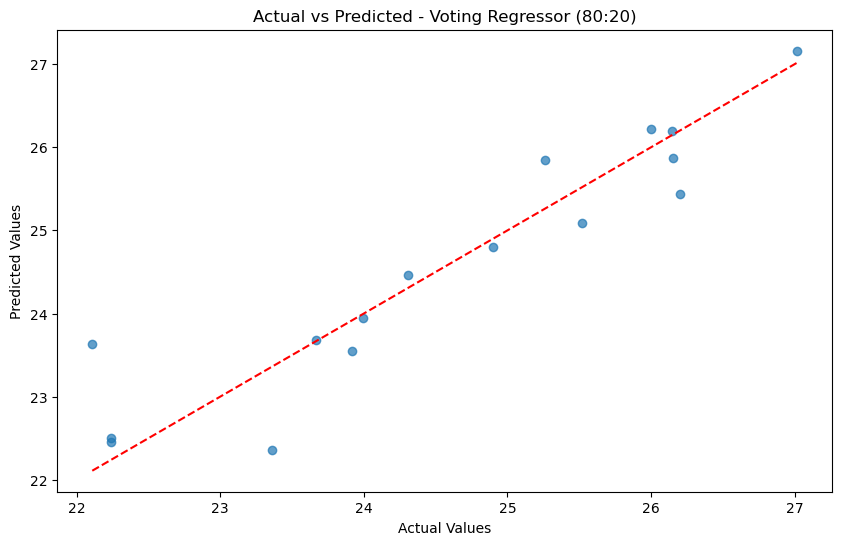

In [175]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [176]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.352725
0   23.997354  23.942492
27  26.199729  25.439465
39  22.237415  22.452879
21  26.146404  26.191614


In [177]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.101.115.582
0    Rp 26.419.136.187   Rp 25.008.760.158
27  Rp 239.000.000.001  Rp 111.742.750.552
39    Rp 4.545.551.009    Rp 5.638.474.490
21  Rp 226.589.000.001  Rp 237.068.352.731
35    Rp 4.545.551.009    Rp 5.920.856.400
10  Rp 120.781.089.488   Rp 78.534.627.404
92  Rp 228.530.000.001  Rp 172.387.400.218
4   Rp 540.031.588.145  Rp 625.175.740.097
13  Rp 195.596.000.001  Rp 244.727.950.451
64   Rp 65.000.000.001   Rp 59.093.262.883
41   Rp 24.322.000.001   Rp 16.785.322.638
88   Rp 35.905.245.001   Rp 41.889.723.048
43   Rp 18.970.782.261   Rp 19.277.840.591
89   Rp 93.541.144.803  Rp 167.330.082.189
59    Rp 3.997.225.850   Rp 18.342.461.410


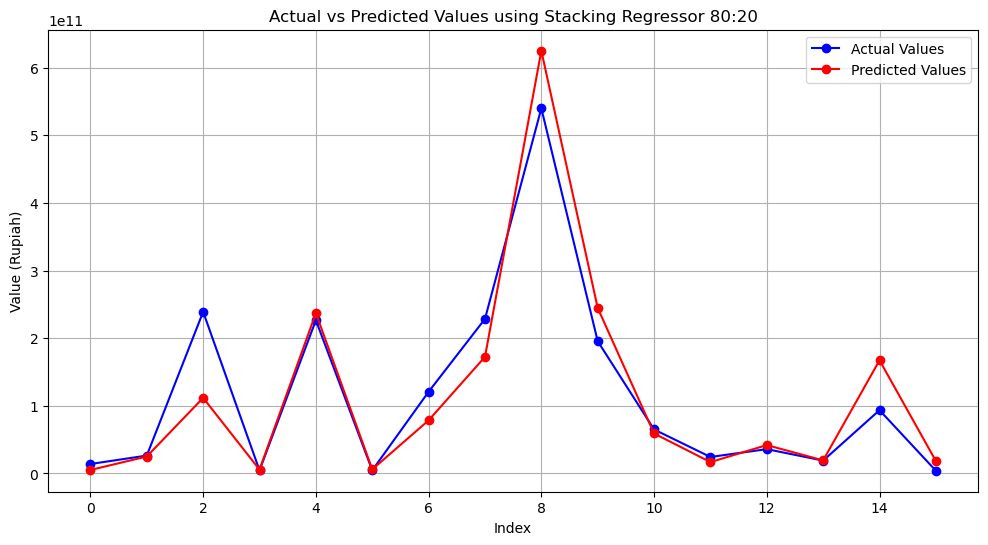

In [178]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

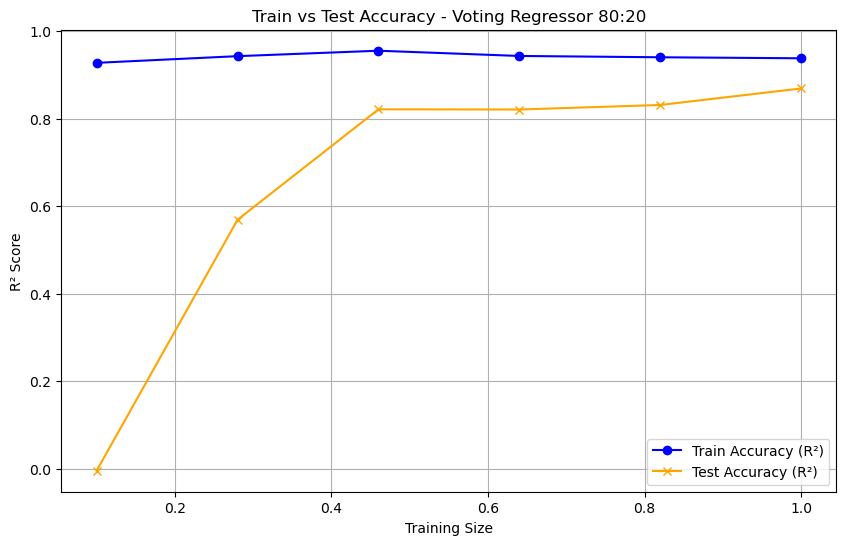

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 6

In [180]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[5, 4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.293
Root Mean Squared Error (MSE):  0.378
R² Score:  0.943
Testing
Mean Absolute Error (MAE):  0.382
Root Mean Squared Error (MSE):  0.542
R² Score:  0.874


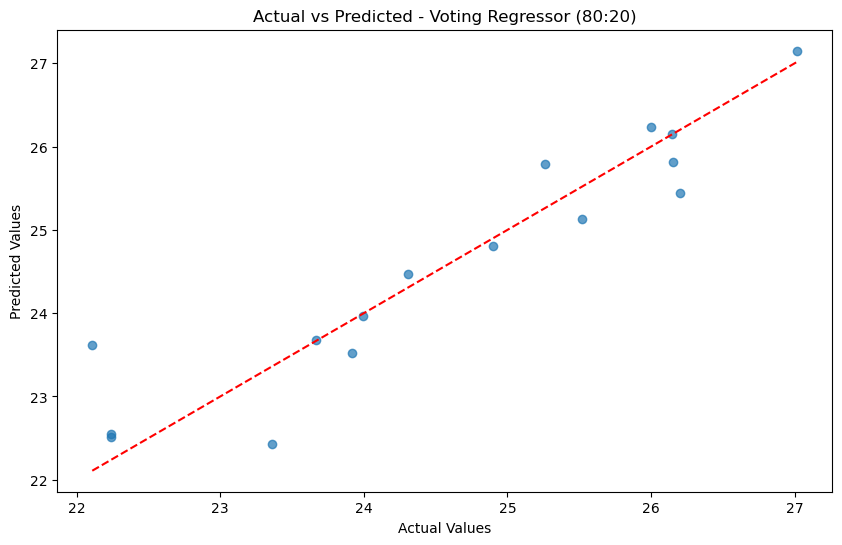

In [181]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [182]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.433656
0   23.997354  23.963988
27  26.199729  25.443626
39  22.237415  22.509293
21  26.146404  26.149195


In [184]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.531.121.567
0    Rp 26.419.136.187   Rp 25.552.168.906
27  Rp 239.000.000.001  Rp 112.208.641.845
39    Rp 4.545.551.009    Rp 5.965.707.337
21  Rp 226.589.000.001  Rp 227.222.479.720
35    Rp 4.545.551.009    Rp 6.215.916.332
10  Rp 120.781.089.488   Rp 81.578.137.435
92  Rp 228.530.000.001  Rp 163.596.194.955
4   Rp 540.031.588.145  Rp 618.584.139.221
13  Rp 195.596.000.001  Rp 247.361.388.997
64   Rp 65.000.000.001   Rp 59.038.855.388
41   Rp 24.322.000.001   Rp 16.479.110.829
88   Rp 35.905.245.001   Rp 42.567.178.882
43   Rp 18.970.782.261   Rp 19.101.064.084
89   Rp 93.541.144.803  Rp 159.612.363.225
59    Rp 3.997.225.850   Rp 18.117.537.151


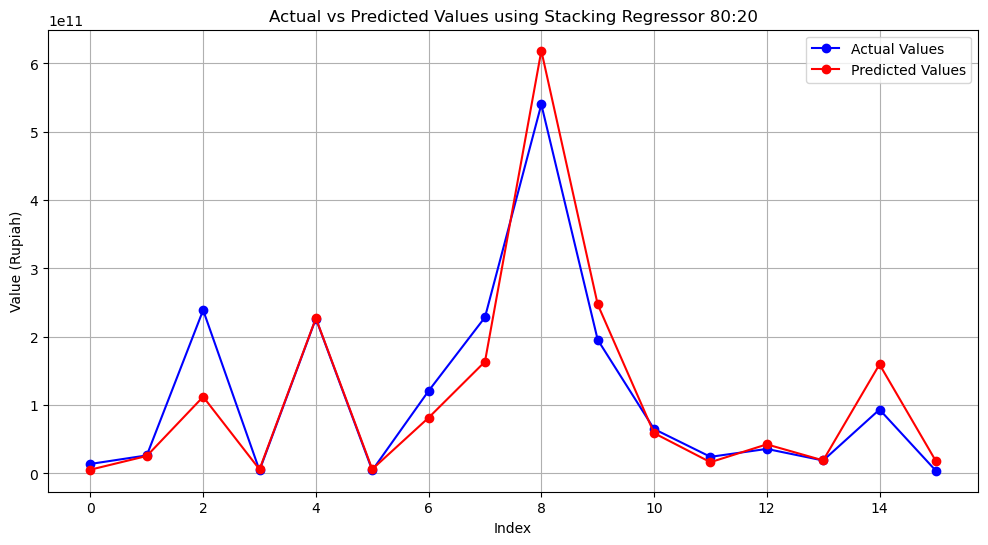

In [185]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

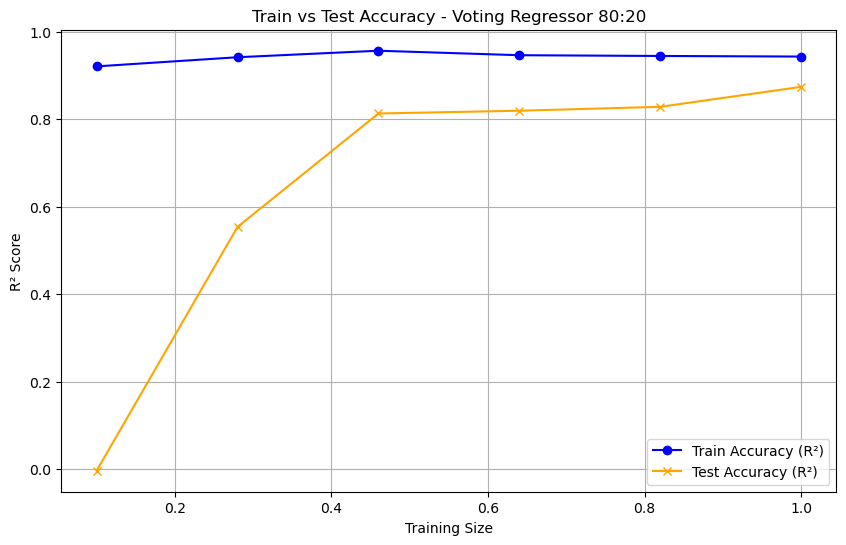

In [186]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 7

In [187]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[4, 3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.290
Root Mean Squared Error (MSE):  0.376
R² Score:  0.944
Testing
Mean Absolute Error (MAE):  0.384
Root Mean Squared Error (MSE):  0.532
R² Score:  0.878


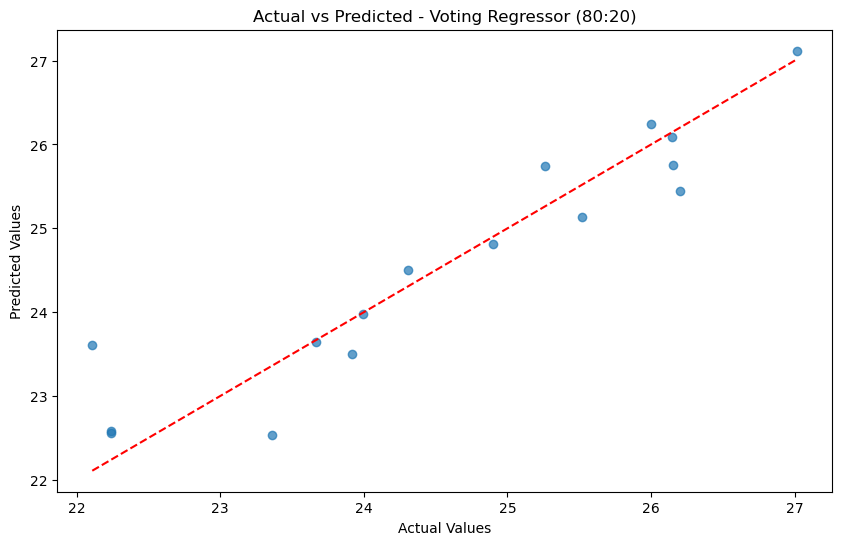

In [188]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [189]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.530129
0   23.997354  23.974311
27  26.199729  25.447350
39  22.237415  22.555112
21  26.146404  26.087685


In [190]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 6.091.308.174
0    Rp 26.419.136.187   Rp 25.817.307.646
27  Rp 239.000.000.001  Rp 112.627.342.382
39    Rp 4.545.551.009    Rp 6.245.408.276
21  Rp 226.589.000.001  Rp 213.667.057.977
35    Rp 4.545.551.009    Rp 6.443.562.788
10  Rp 120.781.089.488   Rp 82.646.945.996
92  Rp 228.530.000.001  Rp 153.705.423.681
4   Rp 540.031.588.145  Rp 598.853.426.237
13  Rp 195.596.000.001  Rp 250.181.490.686
64   Rp 65.000.000.001   Rp 59.549.639.989
41   Rp 24.322.000.001   Rp 16.158.969.447
88   Rp 35.905.245.001   Rp 43.769.093.984
43   Rp 18.970.782.261   Rp 18.639.533.257
89   Rp 93.541.144.803  Rp 151.613.048.823
59    Rp 3.997.225.850   Rp 17.817.609.593


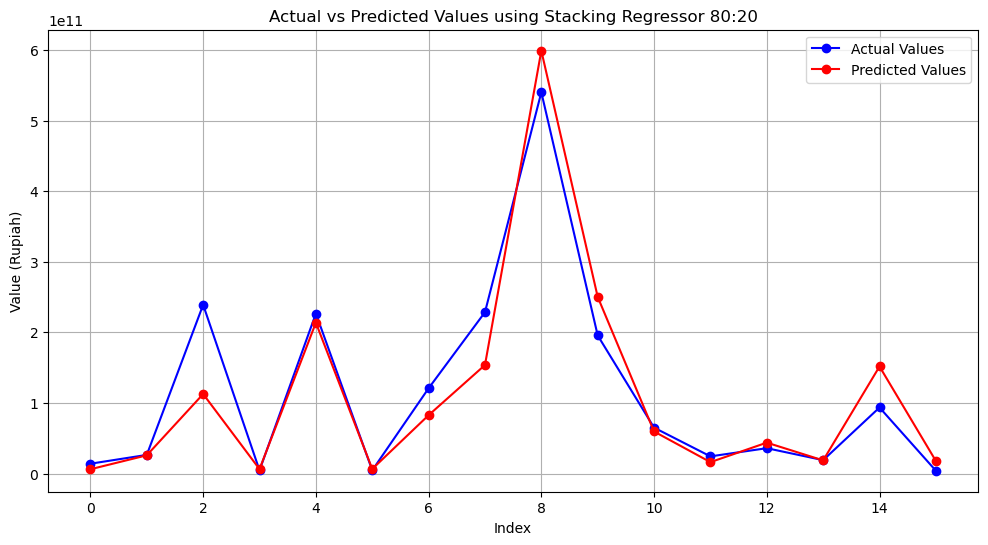

In [191]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

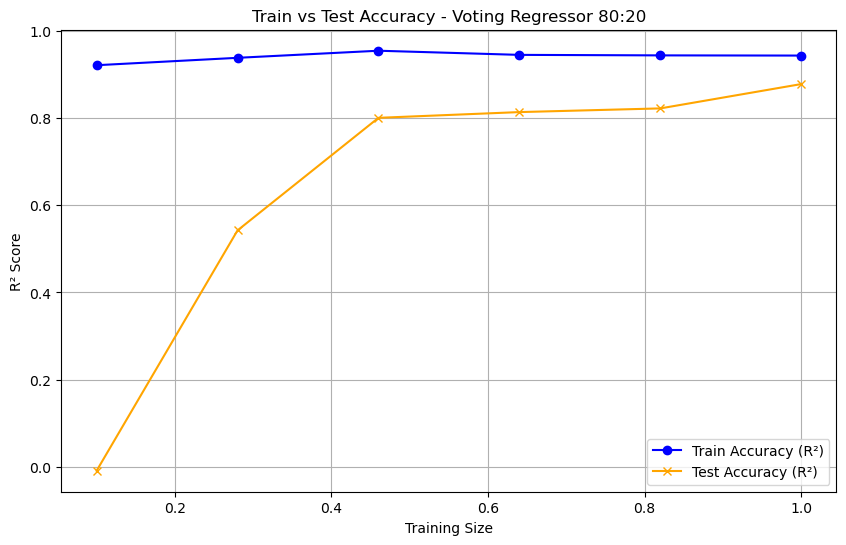

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 8

In [194]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        ('rf2', rf2),
        # ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[3, 2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.244
Root Mean Squared Error (MSE):  0.317
R² Score:  0.960
Testing
Mean Absolute Error (MAE):  0.394
Root Mean Squared Error (MSE):  0.525
R² Score:  0.882


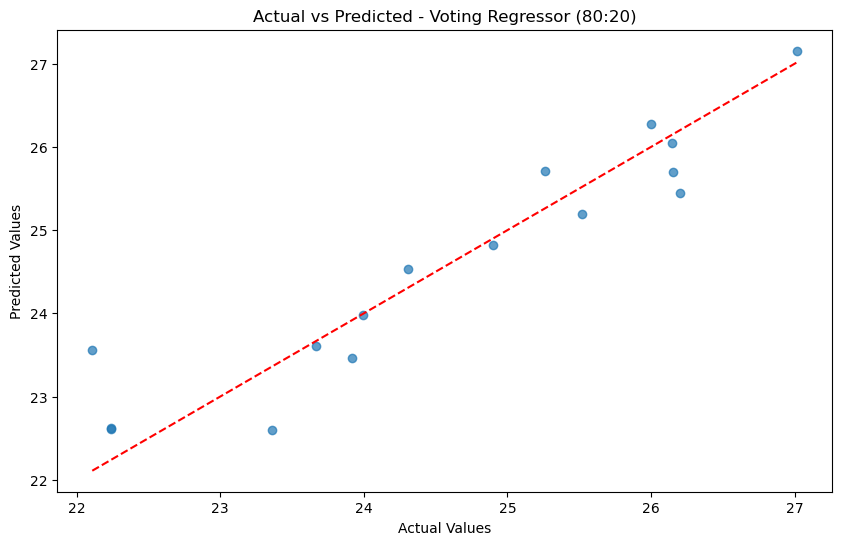

In [195]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [196]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.601988
0   23.997354  23.979067
27  26.199729  25.449127
39  22.237415  22.613211
21  26.146404  26.042815


In [197]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 6.545.138.444
0    Rp 26.419.136.187   Rp 25.940.381.193
27  Rp 239.000.000.001  Rp 112.827.641.359
39    Rp 4.545.551.009    Rp 6.619.002.473
21  Rp 226.589.000.001  Rp 204.291.843.386
35    Rp 4.545.551.009    Rp 6.658.419.881
10  Rp 120.781.089.488   Rp 87.596.718.420
92  Rp 228.530.000.001  Rp 144.512.404.206
4   Rp 540.031.588.145  Rp 621.759.949.380
13  Rp 195.596.000.001  Rp 258.617.670.384
64   Rp 65.000.000.001   Rp 60.176.419.752
41   Rp 24.322.000.001   Rp 15.574.639.723
88   Rp 35.905.245.001   Rp 45.367.865.068
43   Rp 18.970.782.261   Rp 17.955.394.718
89   Rp 93.541.144.803  Rp 146.970.698.671
59    Rp 3.997.225.850   Rp 16.998.580.781


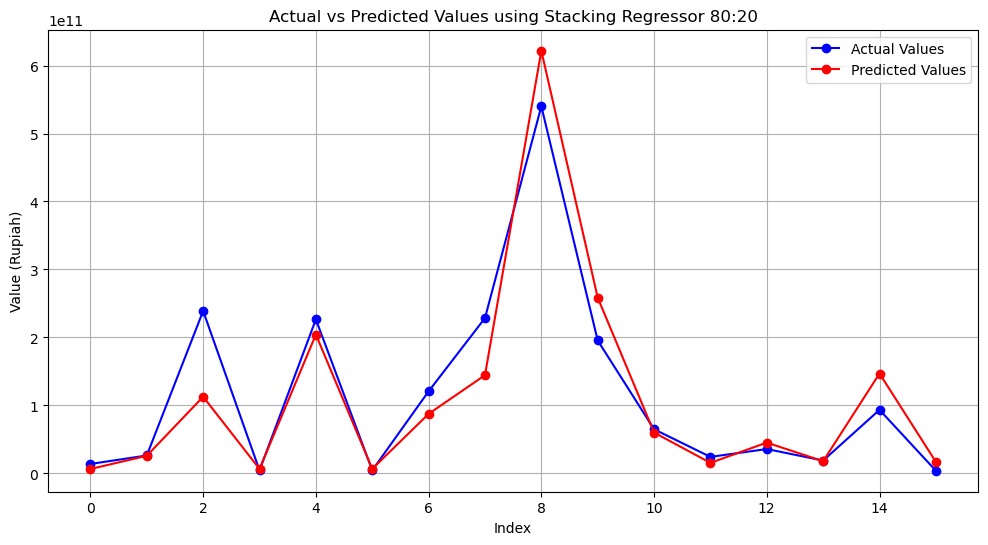

In [198]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

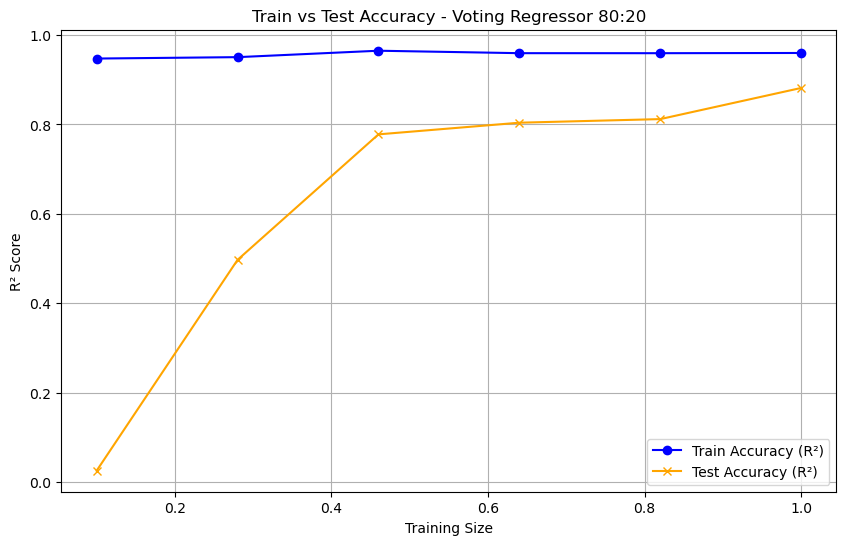

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Voting 9

In [201]:
from sklearn.pipeline import make_pipeline

# 3. Membuat Voting Regressor
voting_regressor2 = VotingRegressor(
   estimators=[
        ('xgboost2', xgboost2),
        ('ridge2', ridge2),
        # ('rf2', rf2),
        # ('br2', br2),
        # ('gb2', gb2),
        # ('lr2', lr2),
        # ('adb2', adb2),
        # ('dt2', dt2),
        # ('KNN2', knn2),
        # ('SVR2', svr2),
    ],
    weights=[2, 1])

# 4. Melatih Voting Regressor
voting_regressor2.fit(X_train2, y_train2)

# Training
y_train_pred_voting2 = voting_regressor2.predict(X_train2)
mae_train_voting2 = mean_absolute_error(y_train2, y_train_pred_voting2)
rmse_train_voting2 = np.sqrt(mean_squared_error(y_train2, y_train_pred_voting2))
r2_train_voting2 = r2_score(y_train2, y_train_pred_voting2)

# Testing
y_test_pred_voting2 = voting_regressor2.predict(X_test2)
mae_test_voting2 = mean_absolute_error(y_test2, y_test_pred_voting2)
rmse_test_voting2 = np.sqrt(mean_squared_error(y_test2, y_test_pred_voting2))
r2_test_voting2 = r2_score(y_test2, y_test_pred_voting2)

print("Training")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_train_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_train_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_train_voting2))
print("="*80)
print("Testing")
print(f"Mean Absolute Error (MAE): ", "{:.3f}".format(mae_test_voting2))
print(f"Root Mean Squared Error (MSE): ", "{:.3f}".format(rmse_test_voting2))
print(f"R² Score: ", "{:.3f}".format(r2_test_voting2))

Training
Mean Absolute Error (MAE):  0.198
Root Mean Squared Error (MSE):  0.259
R² Score:  0.973
Testing
Mean Absolute Error (MAE):  0.416
Root Mean Squared Error (MSE):  0.523
R² Score:  0.882


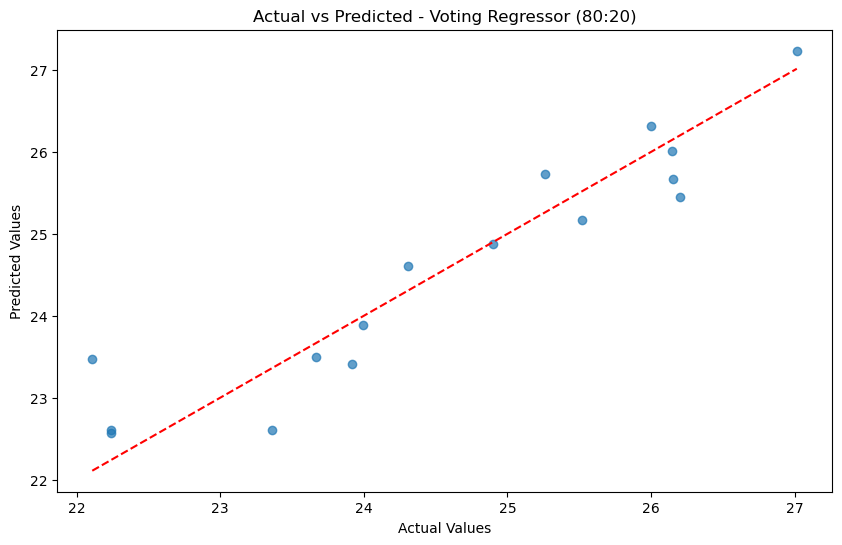

In [202]:
import matplotlib.pyplot as plt
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)


plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()

In [203]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2.head())

       Actual  Predicted
38  23.357097  22.602529
0   23.997354  23.892874
27  26.199729  25.443764
39  22.237415  22.607588
21  26.146404  26.013147


In [204]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 6.548.676.724
0    Rp 26.419.136.187   Rp 23.798.162.293
27  Rp 239.000.000.001  Rp 112.224.149.185
39    Rp 4.545.551.009    Rp 6.581.889.101
21  Rp 226.589.000.001  Rp 198.319.903.962
35    Rp 4.545.551.009    Rp 6.304.264.871
10  Rp 120.781.089.488   Rp 84.969.260.924
92  Rp 228.530.000.001  Rp 139.935.643.251
4   Rp 540.031.588.145  Rp 672.894.373.597
13  Rp 195.596.000.001  Rp 269.262.593.446
64   Rp 65.000.000.001   Rp 63.595.413.438
41   Rp 24.322.000.001   Rp 14.739.252.992
88   Rp 35.905.245.001   Rp 48.551.475.939
43   Rp 18.970.782.261   Rp 15.932.454.719
89   Rp 93.541.144.803  Rp 149.937.052.518
59    Rp 3.997.225.850   Rp 15.582.046.374


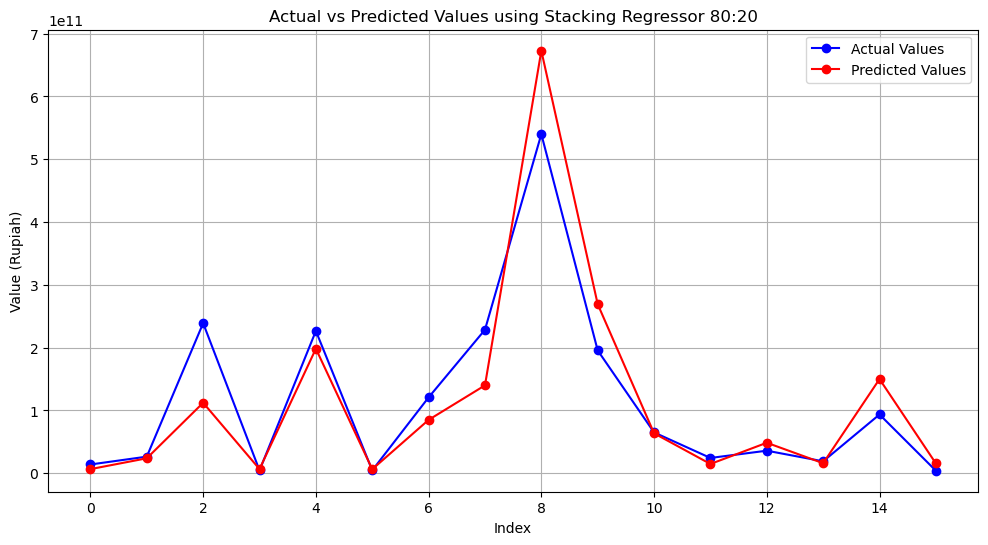

In [205]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Stacking Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()

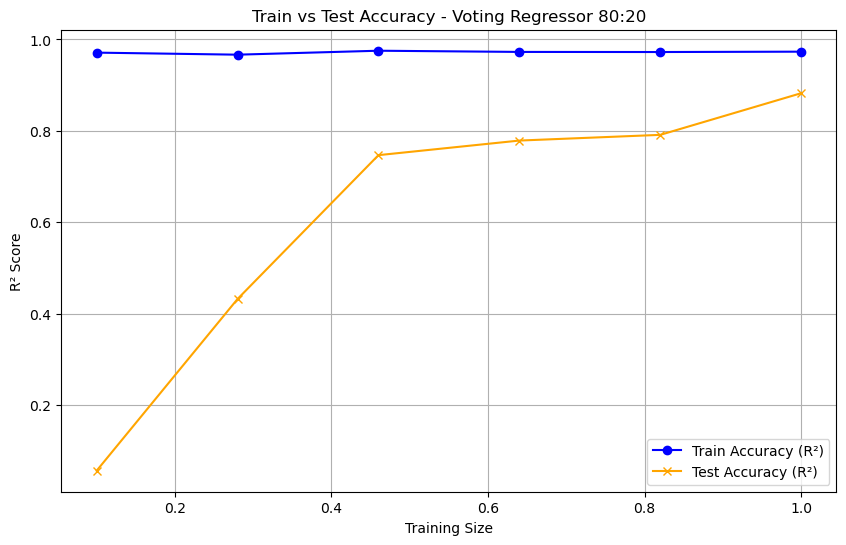

In [206]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = voting_regressor2.predict(X_train_subset2)
    y_test_pred2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()

Ke bawah program yang sebelumnya

karena yang paling bagus selalu voting jadi ambilnya voting aja

Actual dan Prediksinya

In [21]:
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = voting_regressor.predict(X_test1)

# Prediksi nilai actual dan prediksi untuk 80:20
y_actual2 = y_test2
y_pred_best2 = voting_regressor2.predict(X_test2)

Voting Regressor 70:30

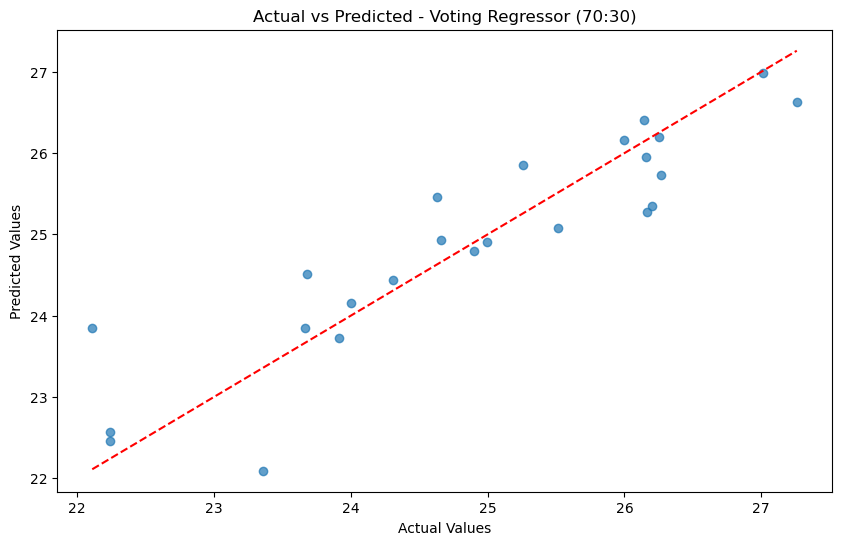

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (70:30)")
plt.show()


Voting Regressor 80:20

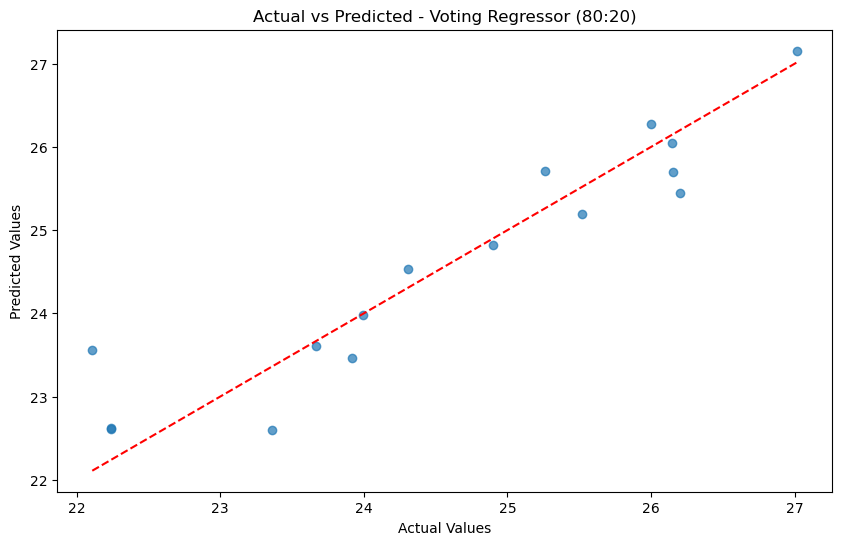

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - Voting Regressor (80:20)")
plt.show()


In [24]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})

# Dataframe untuk 80:20
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})

# Tampilkan beberapa baris pertama
print(comparison1.head())
print(comparison2.head())


       Actual  Predicted
38  23.357097  22.090811
0   23.997354  24.154135
27  26.199729  25.354297
39  22.237415  22.454495
21  26.146404  26.401900
       Actual  Predicted
38  23.357097  22.601988
0   23.997354  23.979067
27  26.199729  25.449127
39  22.237415  22.613211
21  26.146404  26.042815


In [25]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])
print()
print("*" * 100)
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])


       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.925.703.607
0    Rp 26.419.136.187   Rp 30.903.487.957
27  Rp 239.000.000.001  Rp 102.619.844.484
39    Rp 4.545.551.009    Rp 5.647.591.626
21  Rp 226.589.000.001  Rp 292.549.521.073
35    Rp 4.545.551.009    Rp 6.298.324.692
10  Rp 120.781.089.488   Rp 77.948.333.635
92  Rp 228.530.000.001  Rp 186.875.041.718
4   Rp 540.031.588.145  Rp 522.395.835.213
13  Rp 195.596.000.001  Rp 229.389.925.281
64   Rp 65.000.000.001   Rp 58.791.639.967
41   Rp 24.322.000.001   Rp 20.143.746.988
88   Rp 35.905.245.001   Rp 41.214.808.677
43   Rp 18.970.782.261   Rp 22.824.713.422
89   Rp 93.541.144.803  Rp 169.907.140.962
59    Rp 3.997.225.850   Rp 22.686.269.547
95  Rp 690.000.000.001  Rp 367.151.681.922
78   Rp 49.559.404.693  Rp 114.440.309.983
72  Rp 230.570.298.290   Rp 94.694.220.117
52  Rp 254.967.000.193  Rp 149.334.922.075
9   Rp 251.146.002.001  Rp 238.473.575.943
83   Rp 71.420.000.001   Rp 65.139.724.621
5    Rp 51.

Voting Regressor 1 70:30

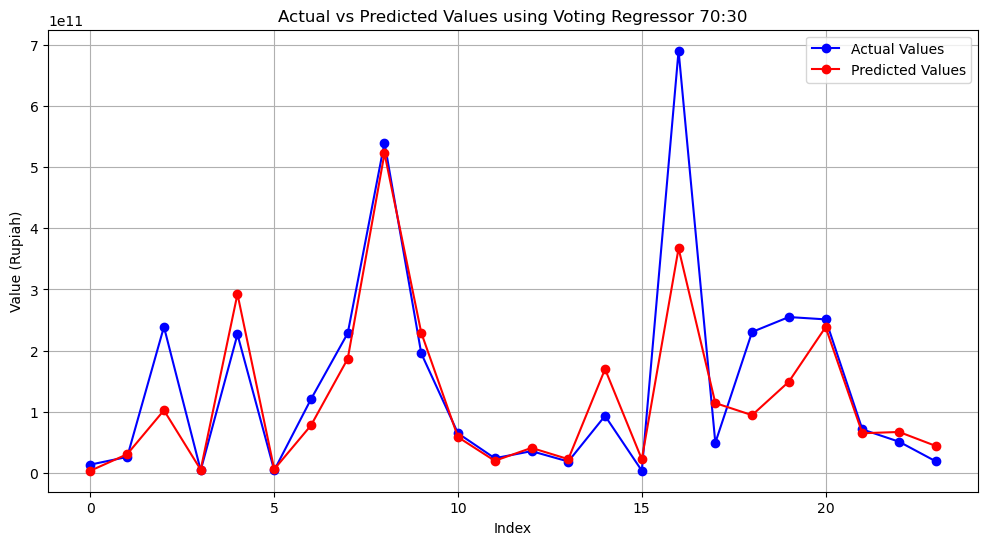

In [26]:
# Predict on the test data
y_pred_log1 = voting_regressor.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 70:30')
plt.legend()
plt.grid(True)
plt.show()


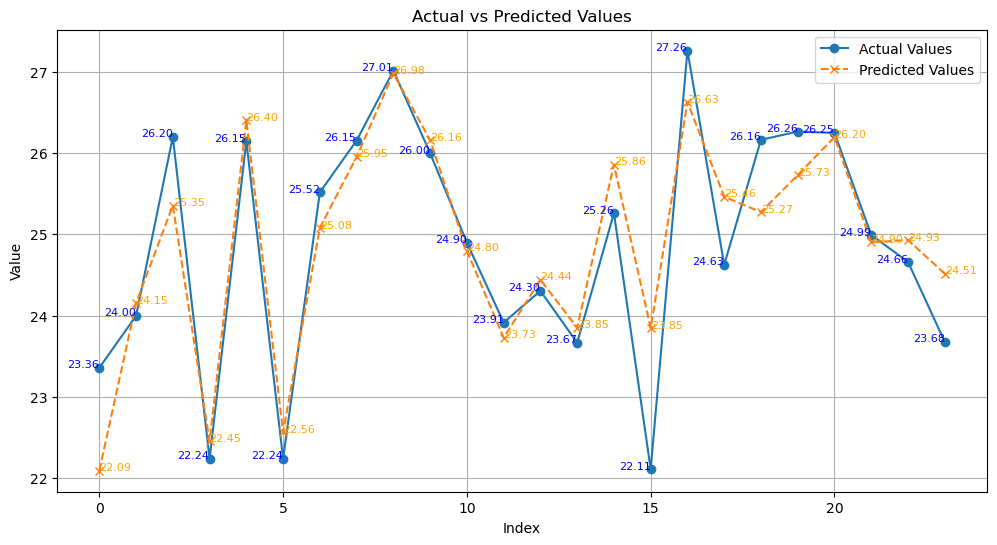

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test = np.array(y_test1)  # Nilai aktual
y_pred = np.array(y_pred_log1)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test, y_pred)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

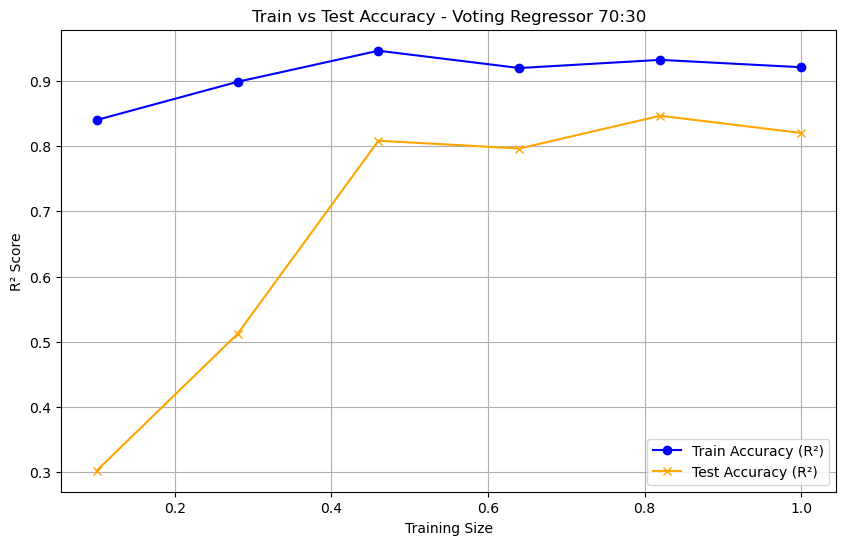

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train1))
    X_train_subset = X_train1[:train_size]
    y_train_subset = y_train1[:train_size]
    
    # Fit model dengan subset data
    voting_regressor.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = voting_regressor.predict(X_train_subset)
    y_test_pred = voting_regressor.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test1, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 70:30')
plt.grid(True)
plt.legend()
plt.show()


Voting Regressor 2 80:20

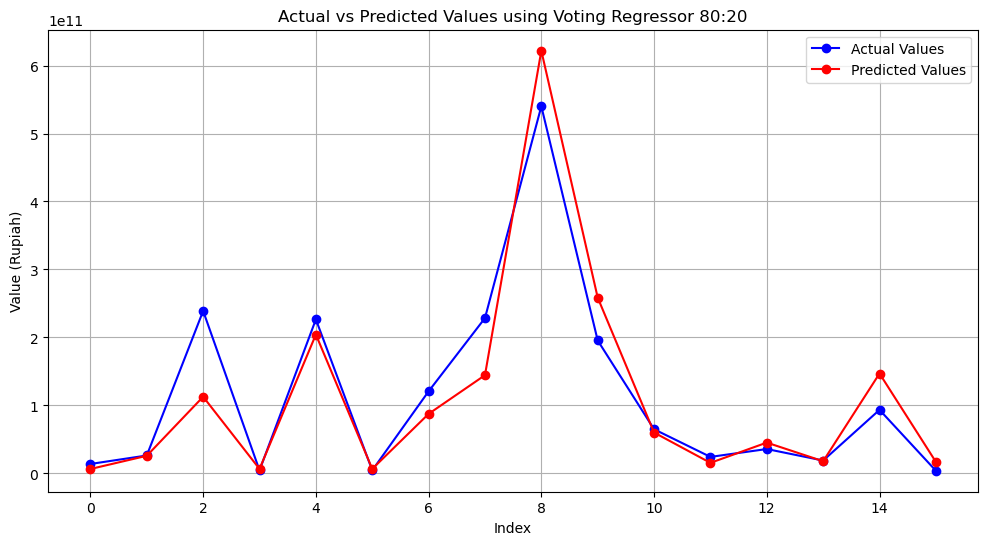

In [29]:
# Predict on the test data
y_pred_log2 = voting_regressor2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using Voting Regressor 80:20')
plt.legend()
plt.grid(True)
plt.show()


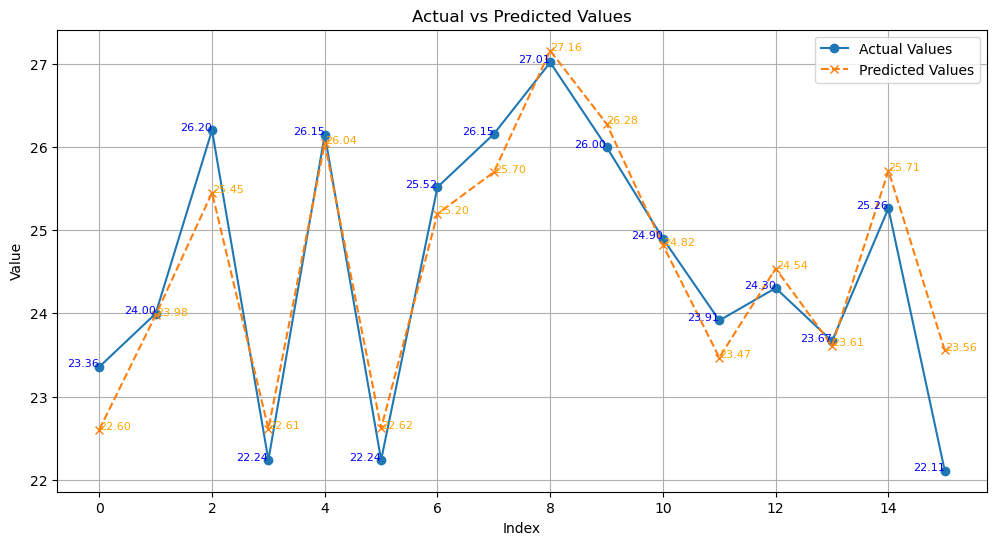

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test_voting2 = np.array(y_test2)  # Nilai aktual
y_pred_voting2 = np.array(y_pred_log2)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_voting2)), y_test_voting2, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred_voting2)), y_pred_voting2, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test_voting2, y_pred_voting2)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

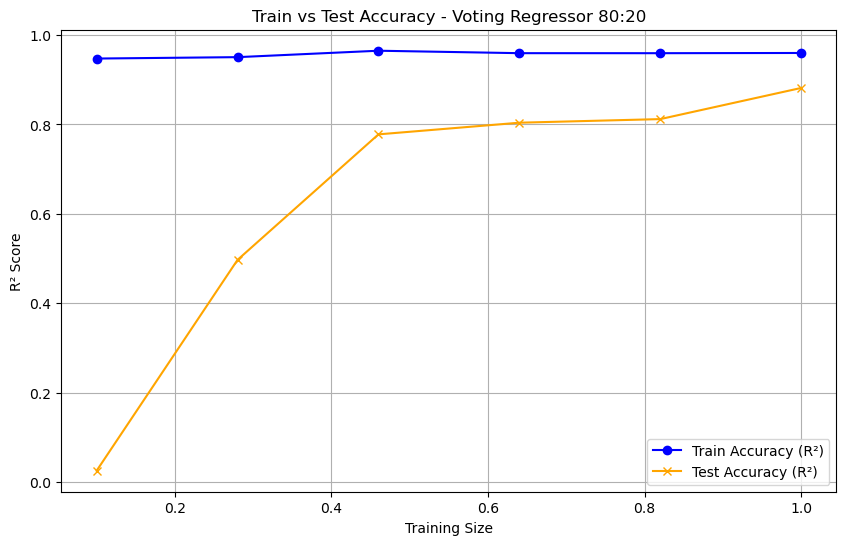

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes_voting2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best_voting2 = []
test_accuracies_best_voting2 = []

for size in training_sizes_voting2:
    # Tentukan jumlah data training sesuai ukuran
    train_size_voting2 = int(size * len(X_train2))
    X_train_subset_voting2 = X_train2[:train_size_voting2]
    y_train_subset_voting2 = y_train2[:train_size_voting2]
    
    # Fit model dengan subset data
    voting_regressor2.fit(X_train_subset_voting2, y_train_subset_voting2)
    
    # Prediksi untuk data training dan testing
    y_train_pred_voting2 = voting_regressor2.predict(X_train_subset_voting2)
    y_test_pred_voting2 = voting_regressor2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best_voting2.append(r2_score(y_train_subset_voting2, y_train_pred_voting2))
    test_accuracies_best_voting2.append(r2_score(y_test2, y_test_pred_voting2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes_voting2, train_accuracies_best_voting2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes_voting2, test_accuracies_best_voting2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor 80:20')
plt.grid(True)
plt.legend()
plt.show()


Cross Validation Voting Regressor 2 karena dia lebih tinggi dari voting yang 70:30 jadi ceknya yang paling tinggi aja

In [208]:
from sklearn.model_selection import cross_val_score

# Model terbaik
# best_model_name = results_df2.iloc[0]['Model']
# best_model = models2[best_model_name]

# Cross-validation
cv_folds = 5  # Jumlah lipatan (folds)
cv_scores = cross_val_score(voting_regressor2, X1, y1, cv=cv_folds, scoring='r2', )

# Rata-rata dan standar deviasi R² Score dari cross-validation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Tampilkan hasil
print(f"Cross-Validation Scores (R²): {cv_scores}")
print(f"Mean R² Score: {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


Cross-Validation Scores (R²): [0.56524226 0.78369694 0.57765542 0.39993524 0.67560093]
Mean R² Score: 0.6004
Standard Deviation: 0.1274


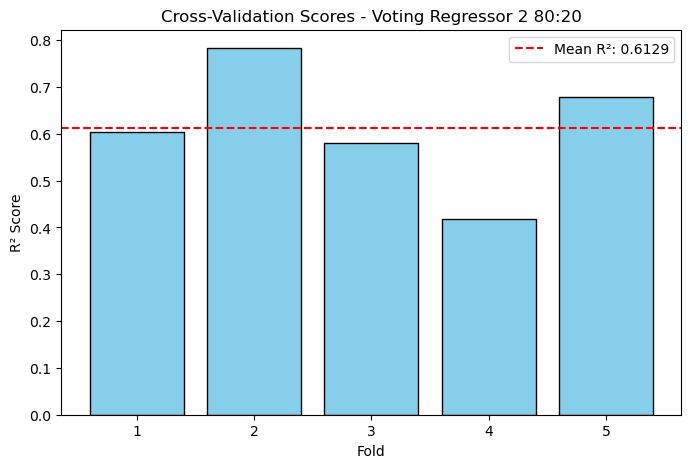

In [35]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, cv_folds + 1), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=mean_cv_score, color='red', linestyle='--', label=f"Mean R²: {mean_cv_score:.4f}")
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - Voting Regressor 2 80:20')
plt.legend()
plt.show()


Hyperparameter tuning voting regressor 2

In [70]:
param_grid = {
    'xgboost__n_estimators': [50, 100, 200],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    # 'xgboost__reg_lambda': [0.01, 0.1, 0.2],
    'ridge__alpha': [0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'weights': [[3, 2, 1], [2, 1, 3], [1, 3, 2], [1, 2, 3]]
}

In [71]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=voting_regressor2, 
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=5, 
                           n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('xgboost',
                                                    XGBRegressor(base_score=None,
                                                                 booster=None,
                                                                 callbacks=None,
                                                                 colsample_bylevel=None,
                                                                 colsample_bynode=None,
                                                                 colsample_bytree=None,
                                                                 device=None,
                                                                 early_stopping_rounds=None,
                                                                 enable_categorical=False,
                                                                 eval_metric=None,
                                                                 feature_types=None,
                                                                 gamma=None,
                                                                 grow_policy=None,
                                                                 importance_type=None,
                                                                 interactio...
                                                   ('rf',
                                                    RandomForestRegressor(random_state=42))],
                                       n_jobs=-1, weights=[3, 2, 1]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__n_estimators': [50, 100, 200],
                         'ridge__alpha': [0.1, 1.0, 10.0],
                         'weights': [[3, 2, 1], [2, 1, 3], [1, 3, 2],
                                     [1, 2, 3]],
                         'xgboost__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost__max_depth': [3, 5, 7],
                         'xgboost__n_estimators': [50, 100, 200]},
             scoring='r2')

In [72]:
# Retrieve the best model
best_model_vr2 = grid_search.best_estimator_

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score (R2):", grid_search.best_score_)

# Test set evaluation
from sklearn.metrics import r2_score

y_pred_vr2 = best_model_vr2.predict(X_test2)
print("R2 Score on test data:", r2_score(y_test2, y_pred_vr2))

Best parameters: {'rf__max_depth': 10, 'rf__n_estimators': 50, 'ridge__alpha': 0.1, 'weights': [1, 3, 2], 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200}
Best score (R2): 0.6021717455958001
R2 Score on test data: 0.8300477705389683


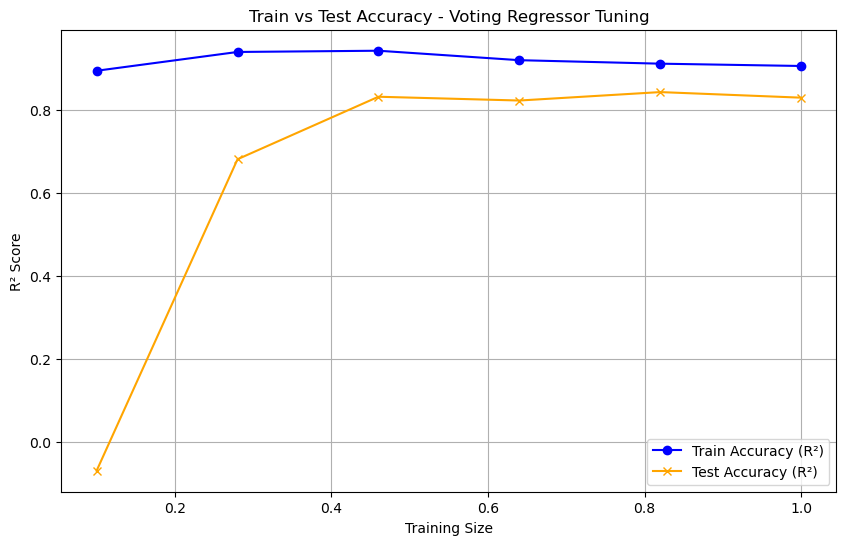

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_model_vr2.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_model_vr2.predict(X_train_subset)
    y_test_pred = best_model_vr2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor Tuning')
plt.grid(True)
plt.legend()
plt.show()


In [74]:
# Model dengan parameter default (sebelum tuning)
default_model = VotingRegressor(estimators=[
    ('xgboost', xgb.XGBRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42))
])

default_model.fit(X_train2, y_train2)
y_pred_default = default_model.predict(X_test2)

# Bandingkan dengan model hasil tuning
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test2)

# Evaluasi skor
from sklearn.metrics import r2_score
print("R2 Score (default):", r2_score(y_test2, y_pred_default))
print("R2 Score (tuned):", r2_score(y_test2, y_pred_tuned))

R2 Score (default): 0.8779235617027977
R2 Score (tuned): 0.8300477705389683


Tuning Pakai Nested Cross Validation

In [78]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import numpy as np


In [79]:
# Contoh dataset
from sklearn.model_selection import train_test_split

# Model dasar
xgboost = XGBRegressor(random_state=42)
ridge = Ridge(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Voting Regressor
vr = VotingRegressor(estimators=[
    ('xgboost', xgboost),
    ('ridge', ridge),
    ('rf', rf)
])


In [80]:
param_grid_vr = {
    'xgboost__n_estimators': [50, 100, 150, 200],
    'xgboost__max_depth': [3, 5, 6, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgboost__reg_lambda': [0.01, 0.1, 0.2, 1.0],
    'ridge__alpha': [0.1, 1.0, 5.0, 10.0],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 10, 20, 30]
}


In [81]:
# Outer Loop untuk evaluasi akhir
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner Loop untuk tuning hyperparameter
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV untuk Inner Loop
grid_search_vr = GridSearchCV(estimator=vr,
                           param_grid=param_grid_vr,
                           scoring='r2',
                           cv=inner_cv,
                           n_jobs=-1)

# Nested Cross-Validation
nested_scores = cross_val_score(grid_search_vr, X_train2, y_train2, scoring='r2', cv=outer_cv)

print("Nested CV R2 Scores:", nested_scores)
print("Mean R2 Score:", np.mean(nested_scores))


c:\Users\lenovo\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Nested CV R2 Scores: [0.69121525 0.68264886 0.66502487 0.50563304 0.26053201]
Mean R2 Score: 0.5610108048021253


In [82]:
# Fit model terbaik pada seluruh data train
grid_search_vr.fit(X_train2, y_train2)

# Best model dari GridSearchCV
best_vr = grid_search_vr.best_estimator_

# Evaluasi pada data test
from sklearn.metrics import r2_score

y_pred_vr = best_vr.predict(X_test2)
print("R2 Score on Test Data:", r2_score(y_test2, y_pred_vr))


R2 Score on Test Data: 0.8035174049094073


In [83]:
best_vr

VotingRegressor(estimators=[('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=50,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('ridge', Ridge(alpha=0.1, random_state=42)),
                            ('rf',
                             RandomForestRegressor(n_estimators=50,
                                                   random_state=42))])

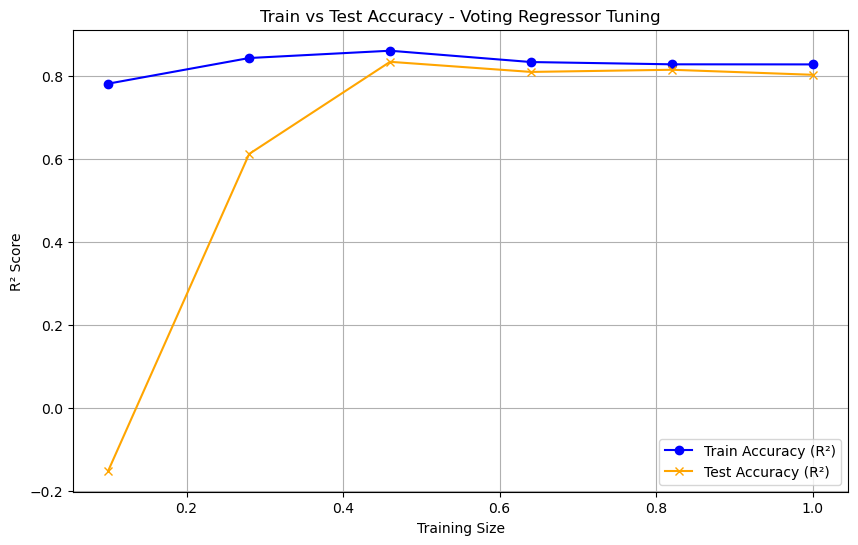

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_vr.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_vr.predict(X_train_subset)
    y_test_pred = best_vr.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - Voting Regressor Tuning')
plt.grid(True)
plt.legend()
plt.show()


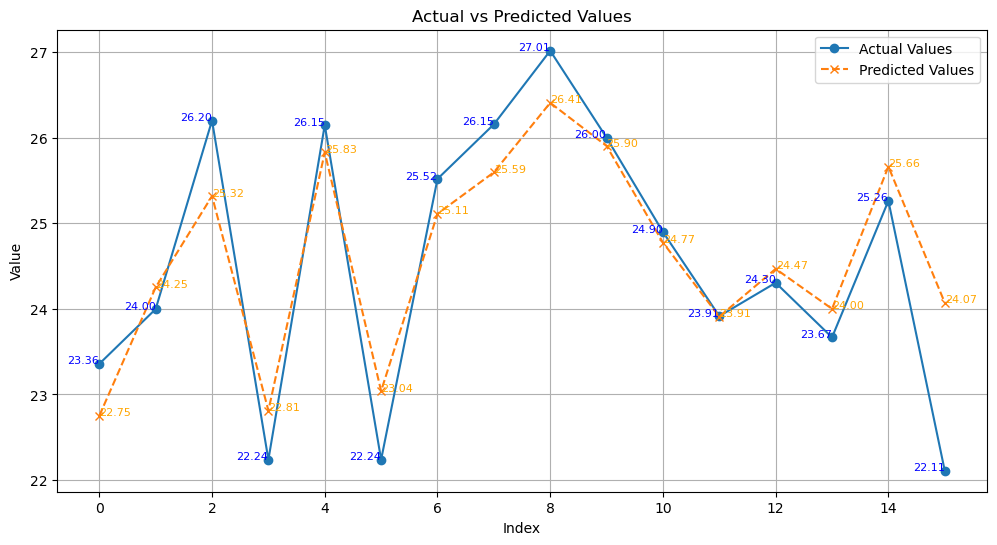

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test_voting2 = np.array(y_test2)  # Nilai aktual
y_pred_voting2 = np.array(y_test_pred)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_voting2)), y_test_voting2, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred_voting2)), y_pred_voting2, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test_voting2, y_pred_voting2)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()